# Capstone Project
## Using Machine Learning in Trading Futures

Cell below is loading data obtained from [quandl.com](https://quandl.com). You can check how the resulting csv file was produced from raw trading data of futures contracts accross multiple years.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

fee = 1.5

delta = 0.95
account_size = 10000
stop_loss = 550

trading_days_in_year = 252

start_date = datetime.date(year=2006, month=6, day=13)
end_date = datetime.date(year=2018, month=12, day=30)
validation_date = datetime.date(year=2018, month=1, day=1)

gold = pd.read_csv('data/gold_daily.csv', index_col='Date')
gold_cot = pd.read_csv('data/gold_cot.csv', index_col='Date')

corn = pd.read_csv('data/corn_daily.csv', index_col='Date')
corn_cot = pd.read_csv('data/corn_cot.csv', index_col='Date')

coffee = pd.read_csv('data/coffee_daily.csv', index_col='Date')
coffee_cot = pd.read_csv('data/coffee_cot.csv', index_col='Date')

dow = pd.read_csv('data/dow_daily.csv', index_col='Date')
nasdaq = pd.read_csv('data/nasdaq_daily.csv', index_col='Date')

Convert index to date type.

In [2]:
gold.index = pd.DatetimeIndex(data=gold.index)
gold_cot.index = pd.DatetimeIndex(data=gold_cot.index)

corn.index = pd.DatetimeIndex(data=corn.index)
corn_cot.index = pd.DatetimeIndex(data=corn_cot.index)

coffee.index = pd.DatetimeIndex(data=coffee.index)
coffee_cot.index = pd.DatetimeIndex(data=coffee_cot.index)

dow.index = pd.DatetimeIndex(data=dow.index)
nasdaq.index = pd.DatetimeIndex(data=nasdaq.index)

Ensure that dataframe is sorted by index (date).

In [3]:
gold = gold.sort_index(kind='mergesort')
gold_cot = gold_cot.sort_index(kind='mergesort')
corn = corn.sort_index(kind='mergesort')
corn_cot = corn_cot.sort_index(kind='mergesort')
coffee = coffee.sort_index(kind='mergesort')
coffee_cot = coffee_cot.sort_index(kind='mergesort')
dow = dow.sort_index(kind='mergesort')
nasdaq = nasdaq.sort_index(kind='mergesort')

Remove older dataframe - because we are missing COT.

In [4]:
gold = gold.loc[gold.index >= '2006-06-13']
corn = corn.loc[corn.index >= '2006-06-13']
coffee = coffee.loc[coffee.index >= '2006-06-13']

In [5]:
gold_cot.head(10)

,Open Interest,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,
2006-06-13,382474.0,42587.0,128892.0,19370.0,66611.0,22998.0,103211.0,30916.0,46704.0,33230.0,10656.0,58412.0,326513.0,365190.0,55961.0,17284.0
2006-06-20,390281.0,47440.0,126992.0,22404.0,64682.0,25806.0,94632.0,30963.0,48730.0,32947.0,11142.0,64458.0,336417.0,372774.0,53864.0,17507.0
2006-06-27,384321.0,48449.0,121890.0,22425.0,62640.0,25151.0,91042.0,32287.0,49614.0,31307.0,11386.0,59762.0,327749.0,362729.0,56572.0,21592.0
2006-07-03,392868.0,48087.0,122568.0,22720.0,69714.0,26352.0,92545.0,30452.0,50821.0,32874.0,8677.0,63514.0,336914.0,372098.0,55955.0,20771.0
2006-07-11,427008.0,54509.0,130618.0,21840.0,79217.0,28805.0,104213.0,27624.0,54922.0,33165.0,11194.0,70944.0,368398.0,403323.0,58611.0,23685.0
2006-07-18,443519.0,49863.0,131166.0,21681.0,83183.0,33352.0,107413.0,24296.0,62395.0,31760.0,9442.0,74272.0,380737.0,418105.0,62782.0,25414.0
2006-07-25,432413.0,52859.0,133290.0,22956.0,85604.0,28832.0,99087.0,22386.0,64810.0,29740.0,6244.0,73980.0,372265.0,415146.0,60148.0,17266.0
2006-08-01,394609.0,45161.0,135988.0,21250.0,73244.0,23643.0,99330.0,24391.0,54618.0,32195.0,4758.0,57618.0,333815.0,374260.0,60795.0,20350.0
2006-08-08,402899.0,46203.0,142240.0,20703.0,72061.0,24259.0,104600.0,24271.0,57785.0,33123.0,6489.0,57914.0,344587.0,385020.0,58312.0,17880.0


### COT Feature engineering
Determine how far we are from top across last 2 years (730 days).

In [6]:
def percentage_from_max(sr):
    mx = sr.max()
    mn = sr.min()
    return (sr[-1]-mn)/(mx-mn)

def max_positions_percentage(df):
    df['Prod_net_position'] = df['Producer/Merchant/Processor/User Longs'] - df['Producer/Merchant/Processor/User Shorts']
    df['Prod_net_position_perc'] = df.rolling('730d')['Prod_net_position'].apply(percentage_from_max, raw=False)
    df['Money_manager_net_position'] = df['Money Manager Longs'] - df['Money Manager Shorts']
    df['Money_manager_net_position_perc'] = df.rolling('730d')['Money_manager_net_position'].apply(percentage_from_max, raw=False)
    df = df[['Prod_net_position_perc', 'Money_manager_net_position_perc']]
    return df

In [7]:
gold_cot = max_positions_percentage(gold_cot)
corn_cot = max_positions_percentage(corn_cot)
coffee_cot = max_positions_percentage(coffee_cot)

### Williams %R
Create feature with Williams %R indicator

In [8]:
# code from stockstats pypy package
def get_wr(df, n_days):
    """ Williams Overbought/Oversold Index
    WMS=[(Hn—Ct)/(Hn—Ln)] ×100
    Ct - the close price
    Hn - N days high
    Ln - N days low
    :param df: data
    :param n_days: N days
    :return: None
    """
    n_days = int(n_days)
    ln = df['Low'].rolling(min_periods=1, window=n_days,
                           center=False).min()
    hn = df['High'].rolling(min_periods=1, window=n_days,
                            center=False).max()
    column_name = 'wr_{}'.format(n_days)
    column_name = 'wr'
    df[column_name] = (hn - df['Settle']) / (hn - ln) * 100

### Create Targets
Based on the threshold, fee and delta calculate targets used for supervised learning.

In [9]:
def calculate_target(row, threshold):
    global fee, delta, stop_loss
    volatility = (row['Settle']-row['Open'])*delta
    if abs(volatility) > fee + threshold:
        if volatility > 0:
            return 1
        else:
            return -1
    else:
        return 0
    return df


def create_trade_outcomes(df, contracts, threshold):
    ans_df = pd.DataFrame([])
    ans_df['gains'] = (df['Settle'] - df['Open'])*0.95*contracts
    ans_df = pd.concat([ans_df, df[['Open', 'High', 'Low', 'Settle']]*contracts], axis=1)
    ans_df['target'] = ans_df.apply(lambda x: calculate_target(x, threshold), axis=1)
    print(ans_df.head(5))
    return ans_df.shift(-1)

In [10]:
threshold = 500
contracts = 100
gold_gains = create_trade_outcomes(gold, contracts, threshold)
gold_gains_train = gold_gains.loc[gold_gains.index < '2018-1-1']
# gold_gains.head(20)

             gains     Open     High      Low   Settle  target
Date                                                          
2006-06-13 -2251.5  59050.0  59500.0  56550.0  56680.0      -1
2006-06-14  -332.5  57000.0  57550.0  56540.0  56650.0       0
2006-06-15  -304.0  57350.0  57950.0  56950.0  57030.0       0
2006-06-16    47.5  58120.0  58250.0  57050.0  58170.0       0
2006-06-19   -38.0  57280.0  57840.0  57100.0  57240.0       0


In [11]:
# get_wr(gold, 14)
gold = pd.concat([gold, gold_gains[['target']]], axis=1)
gold.head(15)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,target
Date,,,,,,,
2006-06-13,590.5,595.0,565.5,566.8,93899.0,192616.0,0.0
2006-06-14,570.0,575.5,565.4,566.5,68729.0,192917.0,0.0
2006-06-15,573.5,579.5,569.5,570.3,52628.0,193887.0,0.0
2006-06-16,581.2,582.5,570.5,581.7,43947.0,189585.0,0.0
2006-06-19,572.8,578.4,571.0,572.4,27362.0,189168.0,1.0
2006-06-20,572.0,581.0,567.8,580.5,39962.0,187696.0,1.0
2006-06-21,577.0,591.5,573.5,591.0,43918.0,187072.0,0.0
2006-06-22,588.0,593.5,584.5,585.4,42916.0,187027.0,1.0
2006-06-23,574.5,589.0,574.5,588.0,33705.0,181290.0,0.0


### Trade gains investigation

Ivestigate trade gains
- have a look at all gains (regardless of label)
- analyze gains for long trades (label 1)
- analyze gains for short trades (label -1)

### Trade labels distribution

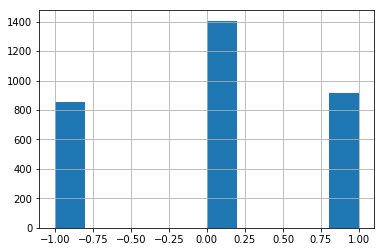

In [12]:
gold['target'].hist()

In [13]:
gold_gains_train.gains.describe()

count     2921.000000
mean        -6.878637
std       1225.716089
min     -11390.500000
25%       -560.500000
50%         28.500000
75%        627.000000
max       6555.000000
Name: gains, dtype: float64

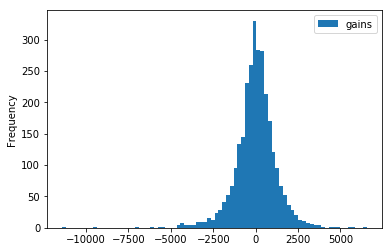

In [14]:
gold_gains_train[['gains']].plot.hist(bins=80)

In [15]:
def stop_loss_gen(df):
    df['Open_High'] = df['High'] - df['Open']
    df['Open_Low'] = df['Open'] - df['Low']
    return df

In [16]:
gold_gains_train = stop_loss_gen(gold_gains_train)

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
def plot_histogram_cumsum(df, column):
    df[column].hist(bins=50, density=True, cumulative=-1, figsize=(10,5))
    df[column].hist(bins=50, density=True, linewidth=1.5, cumulative=True, histtype='step', figsize=(10,5))
    plt.plot([0, df[column].max()], [0.9, 0.9], lw=1, color='r')

### Investigate suitable stop-loss value

Below are cummulative curves.
Red line denotes 90% mark. What stop-loss should you use when you want 90% of trades to get completed (trade from open  to close)?

Following curves are investigating stop losses based on the label.

| trade | commodity | stop loss |
|-------|-----------|-----------|
| long  |      gold |      1000 |
| short |      gold |       800 |
| long  |      corn |       300 |
| short |      corn |       300 |
| long  |    coffee |       800 |
| short |    coffee |       800 |



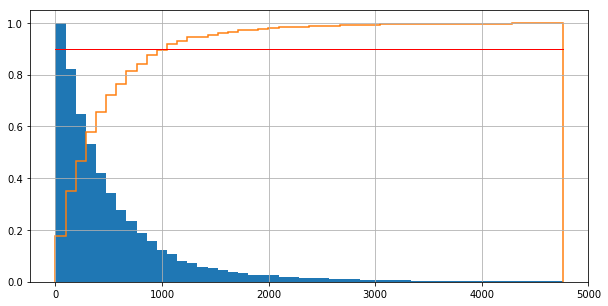

In [18]:
plot_histogram_cumsum(gold_gains_train[gold_gains_train.target == 1], 'Open_Low')

In [19]:
gold_gains_train[gold_gains_train.target == 1].Open_Low.describe()

count     860.000000
mean      472.825581
std       538.691375
min         0.000000
25%       130.000000
50%       310.000000
75%       640.000000
max      4760.000000
Name: Open_Low, dtype: float64

In [20]:
gold_gains_train[gold_gains_train.target == -1].Open_High.describe()

count     802.000000
mean      429.077307
std       439.462157
min         0.000000
25%       150.000000
50%       310.000000
75%       570.000000
max      4380.000000
Name: Open_High, dtype: float64

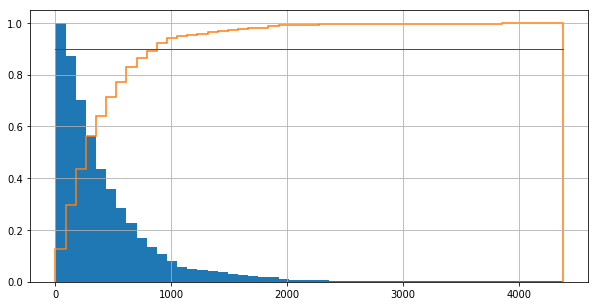

In [21]:
plot_histogram_cumsum(gold_gains_train[gold_gains_train.target == -1], 'Open_High')

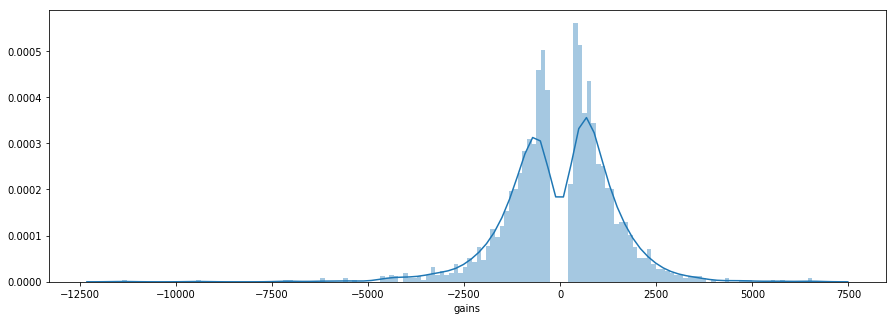

In [22]:
sr = gold_gains_train.loc[gold_gains_train.index < '2018-01-01'][gold_gains_train.gains.abs() > 300].gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, bins=150, ax=ax)

In [23]:
# Corn Contract has 5000 bushels contract is in cents therefore 50 contracts are producing desired values
contracts = 50
threshold = 150
corn_gains = create_trade_outcomes(corn, contracts, threshold)
corn_gains_train = corn_gains.loc[corn_gains.index < '2018-1-1']

              gains     Open     High      Low   Settle  target
Date                                                           
2006-06-13 -213.750  12387.5  12400.0  12112.5  12162.5      -1
2006-06-14 -332.500  12200.0  12262.5  11837.5  11850.0      -1
2006-06-15 -213.750  11875.0  11937.5  11600.0  11650.0      -1
2006-06-16   71.250  12987.5  13137.5  12962.5  13062.5       0
2006-06-19 -154.375  12950.0  13050.0  12750.0  12787.5      -1


In [24]:
corn_gains_train.gains.describe()

count    2917.000000
mean        6.122729
std       411.069273
min     -1983.125000
25%      -190.000000
50%        11.875000
75%       213.750000
max      1888.125000
Name: gains, dtype: float64

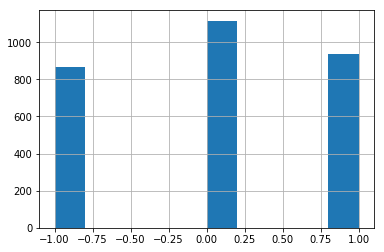

In [25]:
# get_wr(corn, 14)
corn = pd.concat([corn, corn_gains[['target']]], axis=1)

corn.loc[corn.index < '2018-1-1'].target.hist()

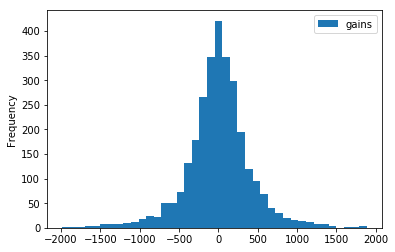

In [26]:
corn_gains_train[['gains']].plot.hist(bins=40)

In [27]:
corn_gains_train.head(10)

,gains,Open,High,Low,Settle,target
Date,,,,,,
2006-06-13,-332.500,12200.0,12262.5,11837.5,11850.0,-1.0
2006-06-14,-213.750,11875.0,11937.5,11600.0,11650.0,-1.0
2006-06-15,71.250,12987.5,13137.5,12962.5,13062.5,0.0
2006-06-16,-154.375,12950.0,13050.0,12750.0,12787.5,-1.0
2006-06-19,-23.750,12825.0,12837.5,12675.0,12800.0,0.0
2006-06-20,142.500,12800.0,12975.0,12775.0,12950.0,0.0
2006-06-21,-95.000,12950.0,13025.0,12800.0,12850.0,0.0
2006-06-22,-83.125,12850.0,12887.5,12737.5,12762.5,0.0
2006-06-23,-225.625,12687.5,12687.5,12387.5,12450.0,-1.0


In [28]:
corn_gains = stop_loss_gen(corn_gains)
corn_gains_train = corn_gains[corn_gains.index < '2018-1-1']

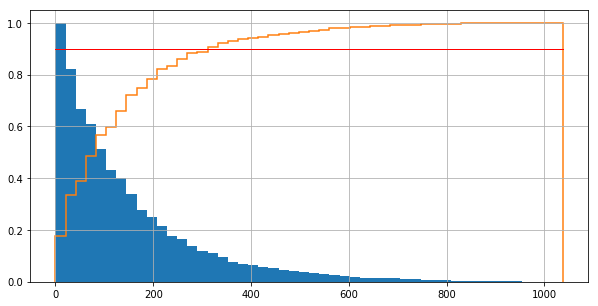

In [29]:
plot_histogram_cumsum(corn_gains_train[corn_gains_train.target == 1], 'Open_Low')

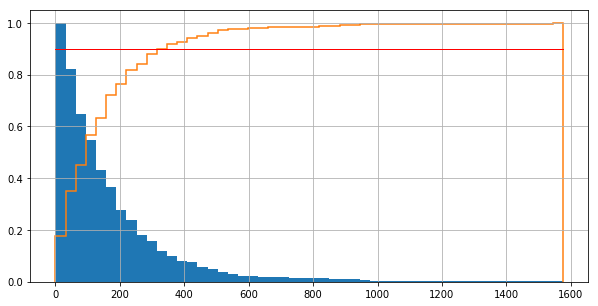

In [30]:
plot_histogram_cumsum(corn_gains_train[corn_gains_train.target == -1], 'Open_High')

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


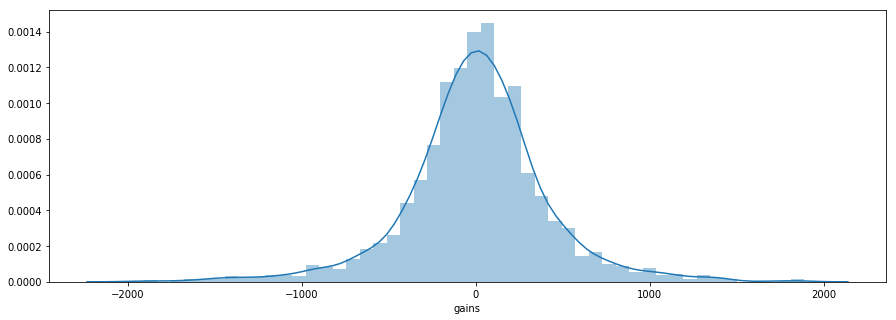

In [31]:
sr = corn_gains_train.gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, ax=ax)

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


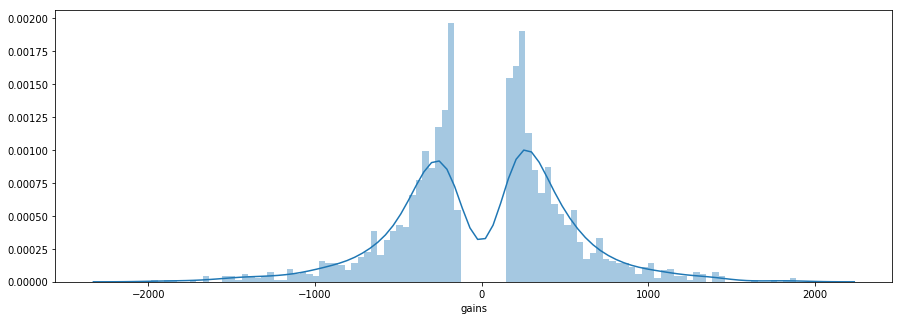

In [32]:
sr = corn_gains_train[corn_gains.gains.abs() > 150].gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, bins=100, ax=ax)

In [33]:
# coffee contract size is 37,500 pounds price is in cents per pound
contracts = 375
threshold = 275
coffee_gains = create_trade_outcomes(coffee, contracts, threshold)
coffee_gains = stop_loss_gen(coffee_gains)
coffee_gains_train = coffee_gains.loc[coffee_gains.index < '2018-1-1']

            gains      Open     High      Low    Settle  target
Date                                                           
2006-06-13    0.0  36731.25  37050.0  36712.5  36731.25       0
2006-06-14    0.0  36918.75  37275.0  36600.0  36918.75       0
2006-06-15    0.0  37106.25  37425.0  36937.5  37106.25       0
2006-06-16    0.0  36637.50  37350.0  36337.5  36637.50       0
2006-06-19    0.0  36468.75  36712.5  36375.0  36468.75       0


In [34]:
coffee_gains_train.gains.describe()

count    2908.000000
mean      -11.546273
std      1070.462227
min     -5236.875000
25%      -516.562500
50%         0.000000
75%       498.750000
max      6341.250000
Name: gains, dtype: float64

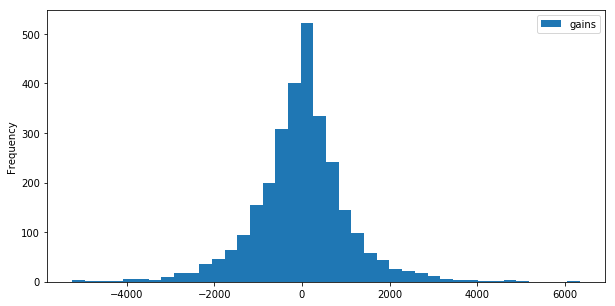

In [35]:
coffee_gains_train[['gains']].plot.hist(bins=40, figsize=(10, 5))

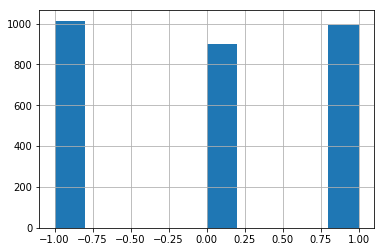

In [36]:
# get_wr(coffee, 14)
coffee = pd.concat([coffee, coffee_gains[['target']]], axis=1)
coffee.loc[coffee.index < '2018-1-1'].target.hist()

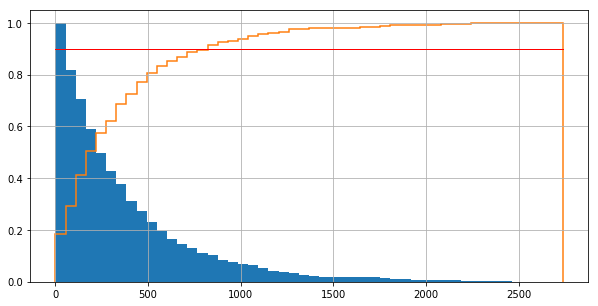

In [37]:
plot_histogram_cumsum(coffee_gains_train[coffee_gains_train.target == 1], 'Open_Low')

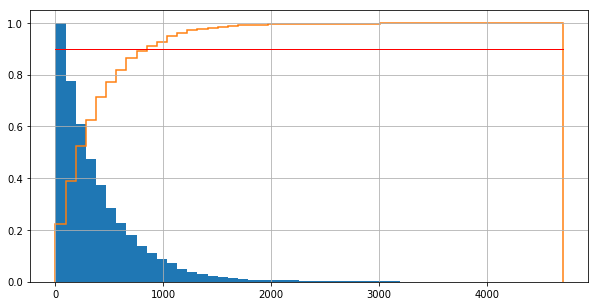

In [38]:
plot_histogram_cumsum(coffee_gains_train[coffee_gains_train.target == -1], 'Open_High')

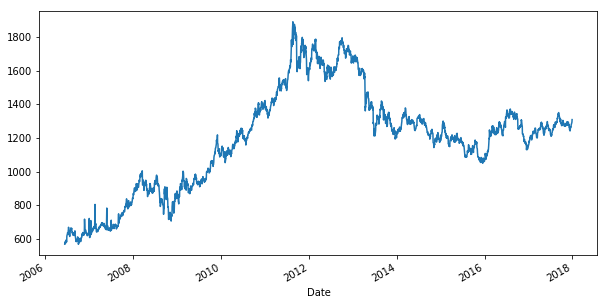

In [39]:
gold.loc[gold.index < '2018-01-01']['Settle'].plot(figsize=(10, 5))

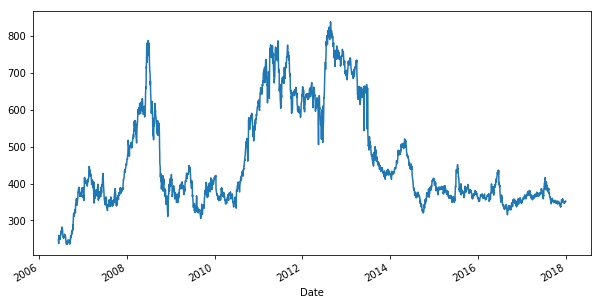

In [40]:
corn.loc[corn.index < '2018-01-01']['Open'].plot(figsize=(10, 5))

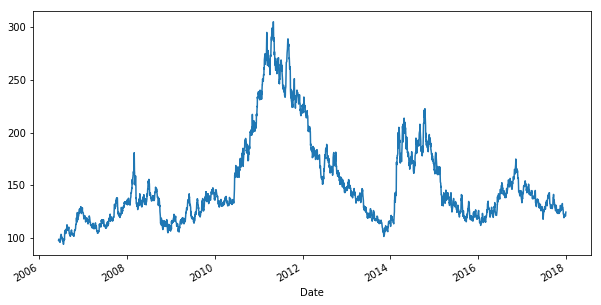

In [41]:
coffee.loc[coffee.index < '2018-01-01']['Open'].plot(figsize=(10, 5))

# Feature Engineering

Code below create date features. In order to capture cyclicality I have transformed features as trading day of month or day of week into $sin$ and $cos$ values.
I am not sure whether this transformation grants subsequent PCA usage.

In [42]:
import numpy as np
import holidays

def trading_day_of_month(tm):
    ts = (tm - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
    dt = datetime.datetime.fromtimestamp(ts)
    di = datetime.date(year=dt.year, month=dt.month, day=1)
    us_holidays = holidays.UnitedStates()
    cnt = 1
    for i in range(1, 32):
        if i == dt.day:
            break
        if di.weekday() in [0, 1, 2, 3, 4] and dt not in us_holidays:
            cnt += 1
        di += datetime.timedelta(days=1)
    return cnt


def create_cycle(x, period):
    sn = np.sin(x*(2.*np.pi/period))
    cs = np.cos(x*(2.*np.pi/period))
    return sn, cs


def create_vectors(df, df_cot):
    global trading_days_in_year
    nv = df.shape[1]-2
    i_t = df.shape[1]-1
    ans_dct = {}
    for i in range(df.shape[0]):
        if i < 2*trading_days_in_year:
            continue
        mtrx = df.iloc[i-2*trading_days_in_year:i, 0:nv].values
        size = np.prod(mtrx.shape)
        mtrx = list(mtrx.reshape(size))
        idx = df.index.values[i]
        # add COT report to the end of list
        mtrx_cot = df_cot[df_cot.index < idx].values[-8:]
        size = np.prod(mtrx_cot.shape)
        mtrx_cot = list(mtrx_cot.reshape(size))
        if size < 16:
            mtrx_cot += [0 for i in range(16-size)]
        # Date Features
        ts = (idx - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
        dt = datetime.datetime.fromtimestamp(ts)
        wsn, wcs = create_cycle(dt.weekday(), 5)
        # period for trading day in month is at most 23
        tsn, tcs = create_cycle(trading_day_of_month(idx), 23)
        dsn, dcs = create_cycle(dt.month, 12)
        qsn, qcs = create_cycle((dt.month-1)//3, 4)
        mtrx_date = [wsn, wcs, tsn, tcs, dsn, dcs, qsn, qcs]
        # mtrx_date = [wsn, wcs, tsn, tcs, dsn, dcs, qsn, qcs, df.loc[idx].wr]
        # mtrx_date = [dt.weekday(), trading_day_of_month(idx), dt.month, (dt.month-1)//3, df.loc[idx].wr]
        # Combine list
        mtrx = mtrx + mtrx_cot + mtrx_date
        mtrx.append(df.iloc[i, i_t])
        ans_dct[idx] = mtrx
    return pd.DataFrame.from_dict(ans_dct, orient='index')

In [43]:
gold_data = create_vectors(gold, gold_cot)
gold_data = gold_data.loc[:end_date]
corn_data = create_vectors(corn, corn_cot)
corn_data = corn_data.loc[:end_date]
coffee_data = create_vectors(coffee, coffee_cot)
coffee_data = coffee_data.loc[:end_date]

cols = list(range(2544))
gold_data_reg = gold_data[cols].join(gold_gains[['gains']].rename(columns={"gains": 2544}))
corn_data_reg = corn_data[cols].join(corn_gains[['gains']].rename(columns={"gains": 2544}))
coffee_data_reg = coffee_data[cols].join(corn_gains[['gains']].rename(columns={"gains": 2544}))

In [44]:
gold_data.tail()

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2018-12-21,1134.0,1138.8,1131.0,1133.2,110023.0,1133.2,1135.5,1128.6,1130.7,115561.0,...,0.346733,-0.951057,0.309017,-0.816970,-0.576680,-2.449294e-16,1.0,-1.0,-1.836970e-16,1.0
2018-12-24,1133.2,1135.5,1128.6,1130.7,115561.0,1130.0,1137.3,1129.5,1133.6,71039.0,...,0.346733,0.000000,1.000000,-0.942261,-0.334880,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0
2018-12-26,1130.0,1137.3,1129.5,1133.6,71039.0,1135.3,1151.7,1132.8,1138.8,102763.0,...,0.346733,0.587785,-0.809017,-0.979084,0.203456,-2.449294e-16,1.0,-1.0,-1.836970e-16,1.0
2018-12-27,1135.3,1151.7,1132.8,1138.8,102763.0,1139.3,1145.1,1137.1,1140.9,100470.0,...,0.346733,-0.587785,-0.809017,-0.887885,0.460065,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0
2018-12-28,1139.3,1145.1,1137.1,1140.9,100470.0,1143.1,1160.6,1142.6,1158.1,153065.0,...,0.346733,-0.951057,0.309017,-0.730836,0.682553,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0


In [45]:
gold_data_reg.head()

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2008-06-06,590.5,595.0,565.5,566.8,93899.0,570.0,575.5,565.4,566.5,68729.0,...,0.698322,-0.951057,0.309017,0.979084,0.203456,1.224647e-16,-1.0,1.0,6.123234e-17,-760.0
2008-06-09,570.0,575.5,565.4,566.5,68729.0,573.5,579.5,569.5,570.3,52628.0,...,0.698322,0.000000,1.000000,0.997669,-0.068242,1.224647e-16,-1.0,1.0,6.123234e-17,-2213.5
2008-06-10,573.5,579.5,569.5,570.3,52628.0,581.2,582.5,570.5,581.7,43947.0,...,0.698322,0.951057,0.309017,0.942261,-0.334880,1.224647e-16,-1.0,1.0,6.123234e-17,1111.5
2008-06-11,581.2,582.5,570.5,581.7,43947.0,572.8,578.4,571.0,572.4,27362.0,...,0.584221,0.587785,-0.809017,0.816970,-0.576680,1.224647e-16,-1.0,1.0,6.123234e-17,-1092.5
2008-06-12,572.8,578.4,571.0,572.4,27362.0,572.0,581.0,567.8,580.5,39962.0,...,0.584221,-0.587785,-0.809017,0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,199.5


In [46]:
gold_data.shape

(2668, 2545)

In [47]:
gold_data = gold_data.dropna()
gold_data.shape

(2668, 2545)

In [48]:
print(corn_data.shape)
corn_data = corn_data.dropna()
corn_data.shape

(2664, 2545)


(2664, 2545)

In [49]:
print(coffee_data.shape)
coffee_data = coffee_data.dropna()
coffee_data.shape

(2655, 2545)


(2655, 2545)

In [50]:
print(gold_data_reg.shape)
gold_data_reg = gold_data_reg.dropna()
gold_data_reg.shape

(2668, 2545)


(2668, 2545)

In [51]:
print(corn_data_reg.shape)
corn_data_reg = corn_data_reg.dropna()
corn_data_reg.shape

(2664, 2545)


(2664, 2545)

In [52]:
print(coffee_data_reg.shape)
coffee_data_reg = coffee_data_reg.dropna()
coffee_data_reg.shape

(2655, 2545)


(2654, 2545)

In [53]:
gold_cot.head(5)

,Prod_net_position_perc,Money_manager_net_position_perc
Date,,
2006-06-13,NaN,NaN
2006-06-20,1.000000,0.000000
2006-06-27,1.000000,0.000000
2006-07-03,0.919154,0.246529
2006-07-11,0.792600,1.000000


In [54]:
gold_data = gold_data.loc[gold_data.index >= '2007-01-01']
corn_data = corn_data.loc[corn_data.index >= '2007-01-01']
coffee_data = coffee_data.loc[coffee_data.index >= '2007-01-01']

gold_data_reg = gold_data_reg.loc[gold_data_reg.index >= '2007-01-01']
corn_data_reg = corn_data_reg.loc[corn_data_reg.index >= '2007-01-01']
coffee_data_reg = coffee_data_reg.loc[coffee_data_reg.index >= '2007-01-01']

In [55]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis

validate_date = '2018-01-01'


def data_split_pca_transform(df):
    global validate_date
    label_index = 2544
    df_validate = df.loc[validate_date <= df.index]
    df_data_tt = df.loc[validate_date > df.index]
    df_train, df_test, label_train, label_test = train_test_split(df_data_tt[list(range(label_index))], df_data_tt[label_index], test_size=0.2, random_state=2242)
    
    pca = PCA(n_components=200, random_state=2234)
    # pca = FactorAnalysis(n_components=5, random_state=2234)
    pca.fit(df_train[list(range(label_index))])
    
    return df_train, df_test, label_train, label_test, df_validate[list(range(label_index))], df_validate[label_index], pca


def pca_transform(df, pca):
    label_index = 2544
    df_pca = pca.transform(df[list(range(label_index))])
    
    return df_pca

In [56]:
gold_train, gold_test, gold_label_train, gold_label_test, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
corn_train, corn_test, corn_label_train, corn_label_test, corn_validate, corn_label_validate, corn_pca = data_split_pca_transform(corn_data)
coffee_train, coffee_test, coffee_label_train, coffee_label_test, coffee_validate, coffee_label_validate, coffee_pca = data_split_pca_transform(coffee_data)

gold_reg_train, gold_reg_test, gold_reg_label_train, gold_reg_label_test, gold_reg_validate, gold_reg_label_validate, gold_reg_pca = data_split_pca_transform(gold_data_reg)
corn_reg_train, corn_reg_test, corn_reg_label_train, corn_reg_label_test, corn_reg_validate, corn_reg_label_validate, corn_reg_pca = data_split_pca_transform(corn_data_reg)
coffee_reg_train, coffee_reg_test, coffee_reg_label_train, coffee_reg_label_test, coffee_reg_validate, coffee_reg_label_validate, coffee_reg_pca = data_split_pca_transform(coffee_data_reg)

# Outlier detection
The code below is using random forest. I am relying on automatic outlier detection.

In [57]:
from sklearn.ensemble import IsolationForest
# from sklearn.neighbors import LocalOutlierFactor

pca_gold = pca_transform(gold_train, gold_pca)
out_gold = IsolationForest(contamination='auto', behaviour='new')
modified_gold = out_gold.fit_predict(pca_gold)

pca_corn = pca_transform(corn_train, corn_pca)
out_corn = IsolationForest(contamination='auto', behaviour='new')
modified_corn = out_corn.fit_predict(pca_corn)

pca_coffee = pca_transform(coffee_train, coffee_pca)
out_coffee = IsolationForest(contamination='auto', behaviour='new')
modified_coffee = out_coffee.fit_predict(pca_coffee)


def remove_outliers(arr, y, isolation):
    lst = out_gold.predict(X)
    a = []
    y_a = []
    for v, h, k in zip(lst, y, X):
        if v == 1:
            a.append(k)
            y_a.append(h)
    a = np.array(a)
    y_a = np.array(y_a)
    return a, y_a

In [58]:
def plot_hist_perc(x):
    df = pd.DataFrame(x)

    ln = df[0].count()
    dct = {}
    dct[-1] = df[df[0] == -1][0].count() / ln
    dct[1] = df[df[0] == 1][0].count() / ln
    
    print('outliers: ' + str(df[df[0] == -1][0].count()))
    print('inliers: ' + str(df[df[0] == 1][0].count()))

    rf = pd.DataFrame.from_dict(dct, orient='index')

    ax = rf.plot(kind='bar', figsize=(10,5), legend=False)
    for i in ax.patches:
        ax.text(i.get_x()-.2, i.get_height()-.05, \
                str(round(i.get_height(),4)), fontsize=15)

outliers: 7
inliers: 1926


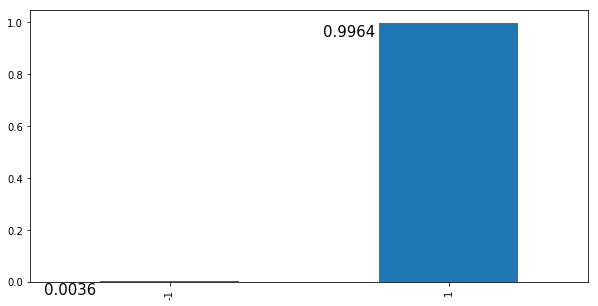

In [59]:
plot_hist_perc(modified_gold)

In [60]:
gold_out = []

for v in pca_gold:
    [p] = out_gold.predict([v])
    if p != 1:
        gold_out.append(v)

In [61]:
gold_out_orig = []

for index, row in gold_train.iterrows():
    [nv] = pca_transform(gold_train.loc[[index]], gold_pca)
    check = [1 for v in gold_out if np.allclose(v, nv)]
    if check:
        print(index)
        gold_out_orig.append(v)

2017-12-19 00:00:00
2017-09-25 00:00:00
2017-11-07 00:00:00
2017-10-20 00:00:00
2017-11-01 00:00:00
2017-09-22 00:00:00
2017-12-12 00:00:00


outliers: 19
inliers: 1911


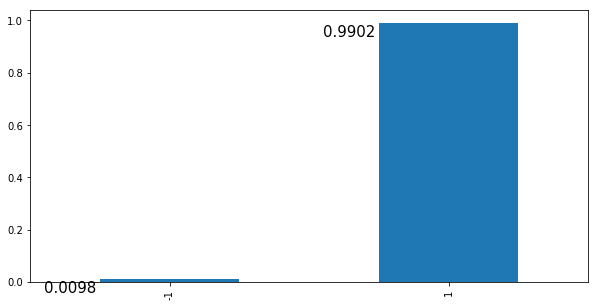

In [62]:
plot_hist_perc(modified_corn)

In [63]:
corn_out = []

for v in pca_corn:
    [p] = out_corn.predict([v])
    if p != 1:
        corn_out.append(v)
        
corn_out_orig = []

for index, row in corn_train.iterrows():
    [nv] = pca_transform(corn_train.loc[[index]], corn_pca)
    check = [1 for v in corn_out if np.allclose(v, nv)]
    if check:
        print(index)
        corn_out_orig.append(v)

2017-03-17 00:00:00
2017-10-09 00:00:00
2017-06-29 00:00:00
2017-06-27 00:00:00
2017-10-05 00:00:00
2017-06-28 00:00:00
2017-06-21 00:00:00
2017-08-28 00:00:00
2017-10-30 00:00:00
2017-08-23 00:00:00
2017-09-22 00:00:00
2016-10-26 00:00:00
2017-10-19 00:00:00
2017-12-27 00:00:00
2017-10-25 00:00:00
2017-12-05 00:00:00
2017-09-12 00:00:00
2017-11-02 00:00:00
2017-08-14 00:00:00


Coffee data contains unusualy big number of outliers - maybe this could be modified by increasing number of PCA components.

outliers: 328
inliers: 1595


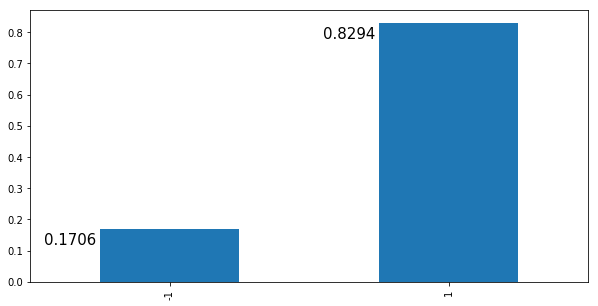

In [64]:
plot_hist_perc(modified_coffee)

In [65]:
coffee_out = []

for v in pca_coffee:
    [p] = out_coffee.predict([v])
    if p != 1:
        coffee_out.append(v)
        
coffee_out_orig = []

for index, row in coffee_train.iterrows():
    [nv] = pca_transform(coffee_train.loc[[index]], coffee_pca)
    check = [1 for v in coffee_out if np.allclose(v, nv)]
    if check:
        print(index)
        coffee_out_orig.append(v)

2008-06-26 00:00:00
2009-04-06 00:00:00
2008-07-02 00:00:00
2008-11-25 00:00:00
2008-12-04 00:00:00
2008-09-16 00:00:00
2010-01-28 00:00:00
2009-08-12 00:00:00
2010-01-08 00:00:00
2008-09-15 00:00:00
2009-09-02 00:00:00
2009-02-09 00:00:00
2009-05-29 00:00:00
2009-07-20 00:00:00
2009-09-18 00:00:00
2009-07-08 00:00:00
2009-02-11 00:00:00
2008-11-03 00:00:00
2009-03-10 00:00:00
2009-12-10 00:00:00
2009-02-02 00:00:00
2009-04-01 00:00:00
2008-08-29 00:00:00
2009-02-20 00:00:00
2008-12-01 00:00:00
2008-12-24 00:00:00
2009-08-17 00:00:00
2009-06-25 00:00:00
2009-08-21 00:00:00
2010-03-02 00:00:00
2008-07-18 00:00:00
2009-08-19 00:00:00
2009-11-30 00:00:00
2008-12-19 00:00:00
2009-11-13 00:00:00
2009-09-08 00:00:00
2009-12-14 00:00:00
2009-06-18 00:00:00
2009-04-17 00:00:00
2009-10-23 00:00:00
2009-02-06 00:00:00
2009-11-03 00:00:00
2009-01-21 00:00:00
2009-05-28 00:00:00
2008-12-30 00:00:00
2009-01-28 00:00:00
2008-10-20 00:00:00
2009-06-30 00:00:00
2009-01-07 00:00:00
2008-10-01 00:00:00


In [248]:
def create_pca_training(df, df_pca, name, validation=0.2):
    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = np.array(list(map(lambda x: x if x >= 0 else 0, df.loc[df.index < '2018-1-1'][2544].values)))
    gdf['label'] = gdf.label.astype(int)
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_long_validation.csv', index=False)
    train_df.to_csv(name + '_long_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = np.array(list(map(lambda x: x if x >= 0 else 0, df.loc[df.index >= '2018-1-1'][2544].values)))
    gdf_test['label'] = gdf_test.label.astype(int)
    gdf_test.to_csv(name + '_long_test.csv', index=False)

    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = np.array(list(map(lambda x: 1 if x < 0 else 0, df.loc[df.index < '2018-1-1'][2544].values)))
    gdf['label'] = gdf.label.astype(int)
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_short_validation.csv', index=False)
    train_df.to_csv(name + '_short_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = np.array(list(map(lambda x: 1 if x < 0 else 0, df.loc[df.index >= '2018-1-1'][2544].values)))
    gdf_test['label'] = gdf_test.label.astype(int)
    gdf_test.to_csv(name + '_short_test.csv', index=False)


def create_pca_reg_training(df, df_pca, name, validation=0.2):
    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = df.loc[df.index < '2018-1-1'][2544].values
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_validation.csv', index=False)
    train_df.to_csv(name + '_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = df.loc[df.index >= '2018-1-1'][2544].values
    gdf_test.to_csv(name + '_test.csv', index=False)


create_pca_training(gold_data, gold_pca, 'data/gold_pca')
create_pca_training(corn_data, corn_pca, 'data/corn_pca')
create_pca_training(coffee_data, coffee_pca, 'data/coffee_pca')

create_pca_reg_training(gold_data_reg, gold_pca, 'data/gold_pca_reg')
create_pca_reg_training(corn_data_reg, corn_pca, 'data/corn_pca_reg')
create_pca_reg_training(coffee_data_reg, coffee_pca, 'data/coffee_pca_reg')

### Dimension reduction with PCA

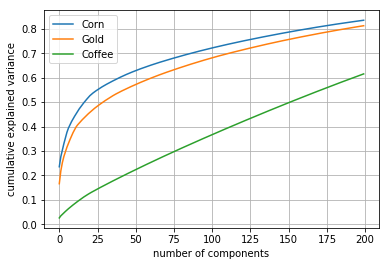

In [67]:
plt.plot(np.cumsum(corn_pca.explained_variance_ratio_), label='Corn')
plt.plot(np.cumsum(gold_pca.explained_variance_ratio_), label='Gold')
plt.plot(np.cumsum(coffee_pca.explained_variance_ratio_), label='Coffee')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid(True)
plt.legend()
plt.show()

It is intereresting Corn is best expalined by PCA transformation. It is probably due to clear seasonal patterns in trading.

I am surprised that gold is better explained by PCA transformation than Coffee. I would expect that coffee has stronger seasonal trading patterns than gold because of the growth cycle. Maybe gold mining is subject to the weather in similar way as agricultural commodities. Gold is still mostly recycled and new production has limited impact on total amount of traded gold.

Possible explanations:
- corn traded on CME is mostly US produced with stable harvest season
- production of coffee is very unpredictable depending on the conditions of a given year
- there are multiple producers around the world (coffee is more of a global market with limited US production) with different harvest periods https://driftaway.coffee/when-is-coffee-harvested/
- important difference between coffee and corn is price per unit corn is much less efficient to transport
    - 1 kg of corn is worth about 15¢
    - 1 kg of coffee is worth about 230¢
    
Based on this graph I think that pca transformation is not suitable for coffee. Information in components is growing linearly. If we don't see sharp increase of cumulative explained variance with few first components then PCA transformation is not suitable. Therefore coffee should not be considered for trading. I will continue with coffee as well but based on this transformation I would not go ahead with trading unless I would find different transformation.

In [68]:
# np.cumsum(gold_pca.explained_variance_ratio_)[268]

In [69]:
gold_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2008-06-06,590.5,595.0,565.5,566.8,93899.0,570.0,575.5,565.4,566.5,68729.0,...,0.698322,-0.951057,0.309017,0.979084,0.203456,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-09,570.0,575.5,565.4,566.5,68729.0,573.5,579.5,569.5,570.3,52628.0,...,0.698322,0.000000,1.000000,0.997669,-0.068242,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-10,573.5,579.5,569.5,570.3,52628.0,581.2,582.5,570.5,581.7,43947.0,...,0.698322,0.951057,0.309017,0.942261,-0.334880,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-11,581.2,582.5,570.5,581.7,43947.0,572.8,578.4,571.0,572.4,27362.0,...,0.584221,0.587785,-0.809017,0.816970,-0.576680,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-12,572.8,578.4,571.0,572.4,27362.0,572.0,581.0,567.8,580.5,39962.0,...,0.584221,-0.587785,-0.809017,0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,0.0
2008-06-13,572.0,581.0,567.8,580.5,39962.0,577.0,591.5,573.5,591.0,43918.0,...,0.584221,-0.951057,0.309017,0.398401,-0.917211,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-16,577.0,591.5,573.5,591.0,43918.0,588.0,593.5,584.5,585.4,42916.0,...,0.584221,0.000000,1.000000,0.136167,-0.990686,1.224647e-16,-1.0,1.0,6.123234e-17,0.0
2008-06-17,588.0,593.5,584.5,585.4,42916.0,574.5,589.0,574.5,588.0,33705.0,...,0.584221,0.951057,0.309017,-0.136167,-0.990686,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-18,574.5,589.0,574.5,588.0,33705.0,586.2,589.5,580.0,587.7,30510.0,...,0.604415,0.587785,-0.809017,-0.398401,-0.917211,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-19,586.2,589.5,580.0,587.7,30510.0,589.5,599.0,583.7,584.4,47778.0,...,0.604415,-0.587785,-0.809017,-0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,0.0


In [70]:
import os
import platform

print(platform.platform())

if platform.system() == 'Darwin':
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

Linux-4.18.0-14-generic-x86_64-with-Ubuntu-18.10-cosmic


In [71]:
def get_round_ceiling(sr):
    return (np.ceil(sr.max()+1000)//1000+1)*1000

In [243]:
from numpy import size
from sklearn.metrics import confusion_matrix


def print_2d(f):
    return format(f, '.2f')


def earnings_per_trade(df):
    ans = 0
    if df[df.trade != 0].trade.count() != 0:
        ans = (df[df.trade != 0].gains.sum())/(df[df.trade != 0].trade.count())
    return ans


def earnings_per_shorts(df):
    ans = 0
    if df[df.trade == -1].trade.count() != 0:
        ans = (df[df.trade == -1].gains.sum())/(df[df.trade == -1].trade.count())
    return ans


def earnings_per_longs(df):
    ans = 0
    if df[df.trade == 1].trade.count() != 0:
        ans = (df[df.trade == 1].gains.sum())/(df[df.trade == 1].trade.count())
    return ans


def get_performance(model, pca, df_gains, df, labels, regression=False, target=200, stop_loss_long=1000, stop_loss_short=800, debug=False):
    df = pca_transform(df, pca)
    preds = model.predict(df)
    if regression and not np.isscalar(preds[0]):
        preds = np.reshape(preds, (preds.shape[0],))
    l = preds.shape[0]
    if regression:
        ax = sns.distplot(preds - df_gains.gains.values[:l], hist = False, kde = True,
                          kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Residual")
        title = ax.set_title('Kernel density of residuals', size=15)
        fig1, ax1 = plt.subplots()
        ax1 = sns.scatterplot(x=preds, y=df_gains.gains.values[:l])
        ax1.set_xlabel('Predictions')
        ax1.set_ylabel('Actuals')
        title = ax1.set_title('Actual vs Prediction scatter plot', size=15)
        print("Predictions/Actual volatility correlation: ", np.corrcoef(preds, df_gains.gains.values[:l])[0][1])
    # print("Predictions/Actual volatility correlation for : ", np.corrcoef(preds, df_gains.gains.values[:l][0][1]))
    if debug:
        print(preds)
    predictions = []
    for v in preds:
        if not regression:
            i = pd.Series(v).idxmax()
            if i == 0:
                predictions.append(0)
            elif i == 1:
                predictions.append(-1)
            else:
                predictions.append(1)
        else:
            if abs(v) > target:
                if v > 0:
                    predictions.append(1)
                else:
                    predictions.append(-1)
            else:
                predictions.append(0)
    return get_account(predictions, df_gains, labels, stop_loss_long, stop_loss_short, True)


def get_account(predictions, df_gains, labels, stop_loss_long=1000, stop_loss_short=800, regression=False):
    global account_size, fee
    acc = account_size
    dct = {}
    dct['account'] = [acc]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['short'] = [0]
    dct['long'] = [0]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['stop_loss'] = [0]
    dct['gains'] = [0]
    dct['predicted_value'] = [0]
    dct['true_value'] = [0]
    for p, l, v in zip(predictions, labels, df_gains.values):
        short = 0
        long = 0
        s_l = 0
        gains = 0
        if p == -1.0:
            short = 1
            if (v[2] - v[1]) > stop_loss_short:
                gains = -stop_loss
                s_l = 1
            else:
                gains = -v[0] - fee
        elif p == 1.0:
            long = 1
            if (v[1] - v[3]) > stop_loss_long:
                gains = -stop_loss
                s_l = 1
            else:
                gains = v[0] - fee
        else:
            pass
        acc += gains
        dct['account'].append(acc)
        dct['short'].append(short)
        dct['long'].append(long)
        dct['stop_loss'].append(s_l)
        dct['trade'].append(float(p))
        dct['label'].append(l)
        dct['gains'].append(gains)
        dct['predicted_value'].append(p)
        dct['true_value'].append(v[0])
        if acc <= 0:
            break
    rf = pd.DataFrame.from_dict(dct)
    rf['id'] = rf.index.values
    rf['trade_visual'] = rf.trade*1000
    ax1 = rf[['account']].plot(grid=True, figsize=(15, 5))
    rf.plot(ax=ax1, x='id', y='trade_visual', color='g', grid=True)
    ax1.set_ylim(-2000, get_round_ceiling(rf.account))
    print("Returns ", print_2d((rf.account.values[-1]/rf.account.values[0])*100-100), "%")
    print("Number of trades: ", rf[rf.trade != 0].trade.count())
    print("Number of short trades: ", rf[rf.trade == -1].trade.count())
    print("Number of long trades: ", rf[rf.trade == 1].trade.count())
    print("Earnings per trade: ", print_2d(earnings_per_trade(rf)))
    print("Earnings per short trade: ", print_2d(earnings_per_shorts(rf)))
    print("Earnings per long trade: ", print_2d(earnings_per_longs(rf)))
    if not regression:
        fig3, ax3 = plt.subplots()
        cm = confusion_matrix(rf['label'].astype(int), rf['trade'].astype(int))
        sns.heatmap(cm, annot=True, fmt="d", ax=ax3)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig4, ax4 = plt.subplots()
        sns.heatmap(cm, annot=True, fmt="f", ax=ax4)
    fig2, ax2 = plt.subplots()
    rf.trade.hist(ax=ax2)
    title = ax2.set_title('Histogram of trades -1 short, 0 no trade, 1 long', size=15)
    return rf

# General strategy for training
I tried the same model for all three commodities (gold, corn and coffee). I am looking for classifier with the same parameters for any commodity. This way I can be sure that I have found some general classification and good results are not just a coincidence.

Following exploration can be split into:
- classificator
- regresssor

# LightGBM Regressor
I tried training lightGBM classifier to train on data with created labels.

- gold 57% gains
- corn 2% gains
- coffee 34% gains

In [110]:
# %%capture cpt_gold_train
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold
import lightgbm as lgb
# import xgboost as xgb

# categoricals = [10, 11, 12, 13]
X = pca_transform(gold_reg_train, gold_reg_pca)
y = gold_reg_label_train
# train_data = lgb.Dataset(X, label=y, categorical_feature=categoricals) # categorical_feature=[3040,3041,3042,3043])
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(gold_reg_test, gold_reg_pca)
y_test = gold_reg_label_test
# test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categoricals)
test_data = lgb.Dataset(X_test, label=y_test)

param = {}
param['num_leaves'] = 40
param['objective'] = 'regression'
param['boosting'] = 'dart'
# param['metric'] = 'binary_error'
# param['metric'] = 'ROC'
param['metric'] = 'l2'
param['estimators'] = 1000
param['learning_rate'] = 0.001
param['num_class'] = 1
param['max_bin'] = 30
param['reg_alpha'] = 5
param['reg_lambda'] = 10
num_round = 1000

np.random.seed = 4567
gold_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's l2: 1.62038e+06
[2]	valid_0's l2: 1.62037e+06
[3]	valid_0's l2: 1.62036e+06
[4]	valid_0's l2: 1.62035e+06
[5]	valid_0's l2: 1.62034e+06
[6]	valid_0's l2: 1.62033e+06
[7]	valid_0's l2: 1.62032e+06
[8]	valid_0's l2: 1.62033e+06
[9]	valid_0's l2: 1.62032e+06
[10]	valid_0's l2: 1.62031e+06
[11]	valid_0's l2: 1.6203e+06
[12]	valid_0's l2: 1.6203e+06
[13]	valid_0's l2: 1.62029e+06
[14]	valid_0's l2: 1.62029e+06
[15]	valid_0's l2: 1.62028e+06
[16]	valid_0's l2: 1.62027e+06
[17]	valid_0's l2: 1.62026e+06
[18]	valid_0's l2: 1.62024e+06
[19]	valid_0's l2: 1.62024e+06
[20]	valid_0's l2: 1.62022e+06
[21]	valid_0's l2: 1.62022e+06
[22]	valid_0's l2: 1.6202e+06
[23]	valid_0's l2: 1.6202e+06
[24]	valid_0's l2: 1.62018e+06
[25]	valid_0's l2: 1.62017e+06
[26]	valid_0's l2: 1.62015e+06
[27]	valid_0's l2: 1.62015e+06
[28]	valid_0's l2: 1.62015e+06
[29]	valid_0's l2: 1.62014e+06
[30]	valid_0's l2: 1.62014e+06
[31]	valid_0's l2: 1.62014e+06
[32]	valid_0's l2: 1.62012e+06
[33]	valid_0's l2: 1.

[301]	valid_0's l2: 1.62218e+06
[302]	valid_0's l2: 1.62224e+06
[303]	valid_0's l2: 1.62222e+06
[304]	valid_0's l2: 1.62219e+06
[305]	valid_0's l2: 1.62217e+06
[306]	valid_0's l2: 1.62215e+06
[307]	valid_0's l2: 1.62213e+06
[308]	valid_0's l2: 1.62218e+06
[309]	valid_0's l2: 1.62216e+06
[310]	valid_0's l2: 1.62218e+06
[311]	valid_0's l2: 1.62223e+06
[312]	valid_0's l2: 1.6223e+06
[313]	valid_0's l2: 1.62232e+06
[314]	valid_0's l2: 1.6223e+06
[315]	valid_0's l2: 1.62228e+06
[316]	valid_0's l2: 1.62229e+06
[317]	valid_0's l2: 1.62235e+06
[318]	valid_0's l2: 1.62242e+06
[319]	valid_0's l2: 1.62239e+06
[320]	valid_0's l2: 1.62244e+06
[321]	valid_0's l2: 1.62242e+06
[322]	valid_0's l2: 1.62244e+06
[323]	valid_0's l2: 1.62247e+06
[324]	valid_0's l2: 1.62245e+06
[325]	valid_0's l2: 1.62249e+06
[326]	valid_0's l2: 1.62247e+06
[327]	valid_0's l2: 1.62251e+06
[328]	valid_0's l2: 1.62249e+06
[329]	valid_0's l2: 1.62255e+06
[330]	valid_0's l2: 1.62252e+06
[331]	valid_0's l2: 1.6225e+06
[332]	valid

[584]	valid_0's l2: 1.62562e+06
[585]	valid_0's l2: 1.62565e+06
[586]	valid_0's l2: 1.62563e+06
[587]	valid_0's l2: 1.62569e+06
[588]	valid_0's l2: 1.62566e+06
[589]	valid_0's l2: 1.62563e+06
[590]	valid_0's l2: 1.62561e+06
[591]	valid_0's l2: 1.62558e+06
[592]	valid_0's l2: 1.62556e+06
[593]	valid_0's l2: 1.62562e+06
[594]	valid_0's l2: 1.6256e+06
[595]	valid_0's l2: 1.62558e+06
[596]	valid_0's l2: 1.62559e+06
[597]	valid_0's l2: 1.62557e+06
[598]	valid_0's l2: 1.62554e+06
[599]	valid_0's l2: 1.62561e+06
[600]	valid_0's l2: 1.62567e+06
[601]	valid_0's l2: 1.62573e+06
[602]	valid_0's l2: 1.6257e+06
[603]	valid_0's l2: 1.62577e+06
[604]	valid_0's l2: 1.62574e+06
[605]	valid_0's l2: 1.62571e+06
[606]	valid_0's l2: 1.62569e+06
[607]	valid_0's l2: 1.62567e+06
[608]	valid_0's l2: 1.62569e+06
[609]	valid_0's l2: 1.62573e+06
[610]	valid_0's l2: 1.62579e+06
[611]	valid_0's l2: 1.62585e+06
[612]	valid_0's l2: 1.62589e+06
[613]	valid_0's l2: 1.62586e+06
[614]	valid_0's l2: 1.62586e+06
[615]	vali

[851]	valid_0's l2: 1.62906e+06
[852]	valid_0's l2: 1.62916e+06
[853]	valid_0's l2: 1.62914e+06
[854]	valid_0's l2: 1.62912e+06
[855]	valid_0's l2: 1.6292e+06
[856]	valid_0's l2: 1.62924e+06
[857]	valid_0's l2: 1.62922e+06
[858]	valid_0's l2: 1.62919e+06
[859]	valid_0's l2: 1.62917e+06
[860]	valid_0's l2: 1.62921e+06
[861]	valid_0's l2: 1.62926e+06
[862]	valid_0's l2: 1.62934e+06
[863]	valid_0's l2: 1.62932e+06
[864]	valid_0's l2: 1.62929e+06
[865]	valid_0's l2: 1.62933e+06
[866]	valid_0's l2: 1.62939e+06
[867]	valid_0's l2: 1.62945e+06
[868]	valid_0's l2: 1.62942e+06
[869]	valid_0's l2: 1.62944e+06
[870]	valid_0's l2: 1.62941e+06
[871]	valid_0's l2: 1.62939e+06
[872]	valid_0's l2: 1.62939e+06
[873]	valid_0's l2: 1.62936e+06
[874]	valid_0's l2: 1.62934e+06
[875]	valid_0's l2: 1.62931e+06
[876]	valid_0's l2: 1.62934e+06
[877]	valid_0's l2: 1.62932e+06
[878]	valid_0's l2: 1.62936e+06
[879]	valid_0's l2: 1.62933e+06
[880]	valid_0's l2: 1.6293e+06
[881]	valid_0's l2: 1.62928e+06
[882]	vali

Predictions/Actual volatility correlation:  0.09617259288031146
Returns  57.29 %
Number of trades:  45
Number of short trades:  27
Number of long trades:  18
Earnings per trade:  127.31
Earnings per short trade:  208.85
Earnings per long trade:  5.00


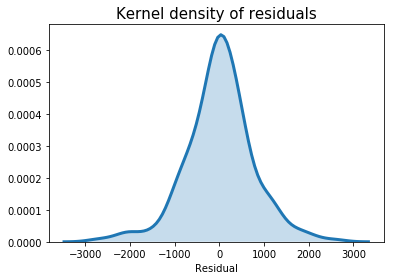

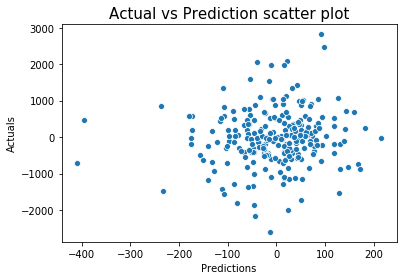

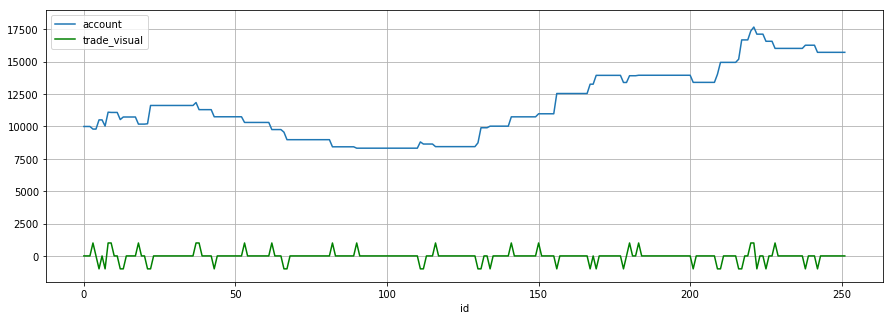

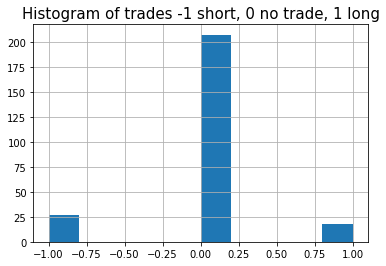

In [195]:
gold_account = get_performance(gold_clf, gold_reg_pca, gold_gains.loc[gold_gains.index > validate_date], gold_reg_validate, gold_reg_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True, target=100)

In [112]:
X = pca_transform(corn_reg_train, corn_reg_pca)
y = corn_reg_label_train
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(corn_reg_test, corn_reg_pca)
y_test = corn_reg_label_test
test_data = lgb.Dataset(X_test, label=y_test)

corn_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's l2: 175904
[2]	valid_0's l2: 175905
[3]	valid_0's l2: 175907
[4]	valid_0's l2: 175908
[5]	valid_0's l2: 175900
[6]	valid_0's l2: 175902
[7]	valid_0's l2: 175894
[8]	valid_0's l2: 175893
[9]	valid_0's l2: 175895
[10]	valid_0's l2: 175887
[11]	valid_0's l2: 175889
[12]	valid_0's l2: 175888
[13]	valid_0's l2: 175881
[14]	valid_0's l2: 175883
[15]	valid_0's l2: 175876
[16]	valid_0's l2: 175877
[17]	valid_0's l2: 175870
[18]	valid_0's l2: 175872
[19]	valid_0's l2: 175866
[20]	valid_0's l2: 175869
[21]	valid_0's l2: 175867
[22]	valid_0's l2: 175860
[23]	valid_0's l2: 175863
[24]	valid_0's l2: 175856
[25]	valid_0's l2: 175859
[26]	valid_0's l2: 175853
[27]	valid_0's l2: 175855
[28]	valid_0's l2: 175855
[29]	valid_0's l2: 175850
[30]	valid_0's l2: 175852
[31]	valid_0's l2: 175852
[32]	valid_0's l2: 175847
[33]	valid_0's l2: 175849
[34]	valid_0's l2: 175849
[35]	valid_0's l2: 175850
[36]	valid_0's l2: 175850
[37]	valid_0's l2: 175852
[38]	valid_0's l2: 175849
[39]	valid_0's l2: 17

[338]	valid_0's l2: 175834
[339]	valid_0's l2: 175834
[340]	valid_0's l2: 175833
[341]	valid_0's l2: 175831
[342]	valid_0's l2: 175825
[343]	valid_0's l2: 175821
[344]	valid_0's l2: 175821
[345]	valid_0's l2: 175829
[346]	valid_0's l2: 175833
[347]	valid_0's l2: 175833
[348]	valid_0's l2: 175843
[349]	valid_0's l2: 175841
[350]	valid_0's l2: 175840
[351]	valid_0's l2: 175838
[352]	valid_0's l2: 175832
[353]	valid_0's l2: 175834
[354]	valid_0's l2: 175834
[355]	valid_0's l2: 175834
[356]	valid_0's l2: 175831
[357]	valid_0's l2: 175831
[358]	valid_0's l2: 175828
[359]	valid_0's l2: 175827
[360]	valid_0's l2: 175829
[361]	valid_0's l2: 175829
[362]	valid_0's l2: 175826
[363]	valid_0's l2: 175826
[364]	valid_0's l2: 175825
[365]	valid_0's l2: 175819
[366]	valid_0's l2: 175819
[367]	valid_0's l2: 175819
[368]	valid_0's l2: 175822
[369]	valid_0's l2: 175822
[370]	valid_0's l2: 175828
[371]	valid_0's l2: 175828
[372]	valid_0's l2: 175825
[373]	valid_0's l2: 175826
[374]	valid_0's l2: 175822
[

[650]	valid_0's l2: 175881
[651]	valid_0's l2: 175886
[652]	valid_0's l2: 175885
[653]	valid_0's l2: 175884
[654]	valid_0's l2: 175884
[655]	valid_0's l2: 175894
[656]	valid_0's l2: 175896
[657]	valid_0's l2: 175895
[658]	valid_0's l2: 175897
[659]	valid_0's l2: 175896
[660]	valid_0's l2: 175901
[661]	valid_0's l2: 175900
[662]	valid_0's l2: 175902
[663]	valid_0's l2: 175901
[664]	valid_0's l2: 175900
[665]	valid_0's l2: 175899
[666]	valid_0's l2: 175899
[667]	valid_0's l2: 175898
[668]	valid_0's l2: 175897
[669]	valid_0's l2: 175900
[670]	valid_0's l2: 175904
[671]	valid_0's l2: 175903
[672]	valid_0's l2: 175907
[673]	valid_0's l2: 175906
[674]	valid_0's l2: 175907
[675]	valid_0's l2: 175911
[676]	valid_0's l2: 175916
[677]	valid_0's l2: 175919
[678]	valid_0's l2: 175918
[679]	valid_0's l2: 175923
[680]	valid_0's l2: 175926
[681]	valid_0's l2: 175925
[682]	valid_0's l2: 175924
[683]	valid_0's l2: 175929
[684]	valid_0's l2: 175928
[685]	valid_0's l2: 175927
[686]	valid_0's l2: 175915
[

[983]	valid_0's l2: 175875
[984]	valid_0's l2: 175866
[985]	valid_0's l2: 175864
[986]	valid_0's l2: 175864
[987]	valid_0's l2: 175862
[988]	valid_0's l2: 175861
[989]	valid_0's l2: 175860
[990]	valid_0's l2: 175859
[991]	valid_0's l2: 175867
[992]	valid_0's l2: 175869
[993]	valid_0's l2: 175868
[994]	valid_0's l2: 175878
[995]	valid_0's l2: 175877
[996]	valid_0's l2: 175885
[997]	valid_0's l2: 175889
[998]	valid_0's l2: 175888
[999]	valid_0's l2: 175879
[1000]	valid_0's l2: 175878


Predictions/Actual volatility correlation:  0.030004906267008552
Returns  2.48 %
Earnings per trade:  6.89
Earnings per Shorts:  43.29
Earnings per Longs:  -16.28


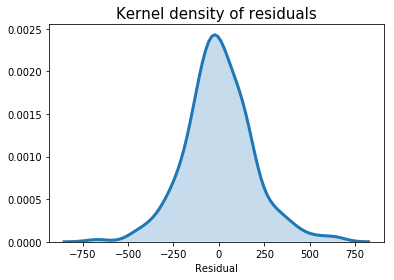

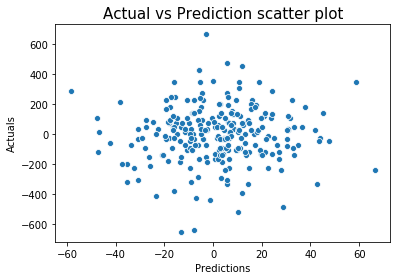

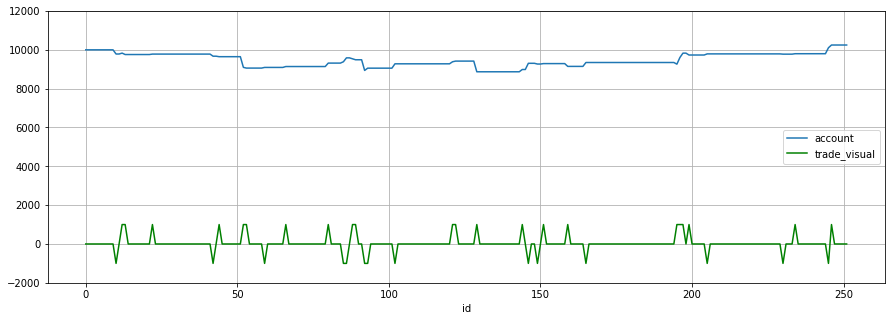

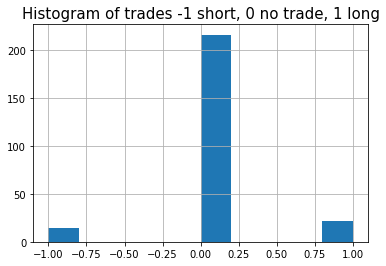

In [113]:
corn_account = get_performance(corn_clf, corn_reg_pca, corn_gains.loc[corn_gains.index > validate_date], corn_reg_validate, corn_reg_label_validate, stop_loss_long=300, stop_loss_short=300, regression=True, target=30)

In [114]:
X = pca_transform(coffee_reg_train, coffee_reg_pca)
y = coffee_reg_label_train.values
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(coffee_reg_test, coffee_reg_pca)
y_test = coffee_reg_label_test.values
test_data = lgb.Dataset(X_test, label=y_test)

coffee_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's l2: 161691
[2]	valid_0's l2: 161691
[3]	valid_0's l2: 161691
[4]	valid_0's l2: 161692
[5]	valid_0's l2: 161693
[6]	valid_0's l2: 161693
[7]	valid_0's l2: 161695
[8]	valid_0's l2: 161695
[9]	valid_0's l2: 161695
[10]	valid_0's l2: 161697
[11]	valid_0's l2: 161701
[12]	valid_0's l2: 161700
[13]	valid_0's l2: 161701
[14]	valid_0's l2: 161704
[15]	valid_0's l2: 161706
[16]	valid_0's l2: 161709
[17]	valid_0's l2: 161700
[18]	valid_0's l2: 161704
[19]	valid_0's l2: 161695
[20]	valid_0's l2: 161699
[21]	valid_0's l2: 161698
[22]	valid_0's l2: 161690
[23]	valid_0's l2: 161694
[24]	valid_0's l2: 161685
[25]	valid_0's l2: 161690
[26]	valid_0's l2: 161692
[27]	valid_0's l2: 161686
[28]	valid_0's l2: 161684
[29]	valid_0's l2: 161685
[30]	valid_0's l2: 161679
[31]	valid_0's l2: 161679
[32]	valid_0's l2: 161685
[33]	valid_0's l2: 161683
[34]	valid_0's l2: 161683
[35]	valid_0's l2: 161683
[36]	valid_0's l2: 161684
[37]	valid_0's l2: 161690
[38]	valid_0's l2: 161688
[39]	valid_0's l2: 16

[309]	valid_0's l2: 161447
[310]	valid_0's l2: 161443
[311]	valid_0's l2: 161437
[312]	valid_0's l2: 161441
[313]	valid_0's l2: 161432
[314]	valid_0's l2: 161434
[315]	valid_0's l2: 161434
[316]	valid_0's l2: 161430
[317]	valid_0's l2: 161422
[318]	valid_0's l2: 161428
[319]	valid_0's l2: 161430
[320]	valid_0's l2: 161421
[321]	valid_0's l2: 161423
[322]	valid_0's l2: 161415
[323]	valid_0's l2: 161413
[324]	valid_0's l2: 161414
[325]	valid_0's l2: 161416
[326]	valid_0's l2: 161417
[327]	valid_0's l2: 161421
[328]	valid_0's l2: 161423
[329]	valid_0's l2: 161415
[330]	valid_0's l2: 161417
[331]	valid_0's l2: 161419
[332]	valid_0's l2: 161420
[333]	valid_0's l2: 161421
[334]	valid_0's l2: 161423
[335]	valid_0's l2: 161427
[336]	valid_0's l2: 161428
[337]	valid_0's l2: 161425
[338]	valid_0's l2: 161429
[339]	valid_0's l2: 161429
[340]	valid_0's l2: 161430
[341]	valid_0's l2: 161437
[342]	valid_0's l2: 161428
[343]	valid_0's l2: 161432
[344]	valid_0's l2: 161433
[345]	valid_0's l2: 161425
[

[634]	valid_0's l2: 161722
[635]	valid_0's l2: 161728
[636]	valid_0's l2: 161727
[637]	valid_0's l2: 161734
[638]	valid_0's l2: 161733
[639]	valid_0's l2: 161732
[640]	valid_0's l2: 161733
[641]	valid_0's l2: 161732
[642]	valid_0's l2: 161732
[643]	valid_0's l2: 161739
[644]	valid_0's l2: 161738
[645]	valid_0's l2: 161747
[646]	valid_0's l2: 161747
[647]	valid_0's l2: 161757
[648]	valid_0's l2: 161754
[649]	valid_0's l2: 161753
[650]	valid_0's l2: 161753
[651]	valid_0's l2: 161760
[652]	valid_0's l2: 161760
[653]	valid_0's l2: 161759
[654]	valid_0's l2: 161759
[655]	valid_0's l2: 161770
[656]	valid_0's l2: 161769
[657]	valid_0's l2: 161769
[658]	valid_0's l2: 161765
[659]	valid_0's l2: 161764
[660]	valid_0's l2: 161775
[661]	valid_0's l2: 161774
[662]	valid_0's l2: 161780
[663]	valid_0's l2: 161780
[664]	valid_0's l2: 161779
[665]	valid_0's l2: 161779
[666]	valid_0's l2: 161778
[667]	valid_0's l2: 161778
[668]	valid_0's l2: 161777
[669]	valid_0's l2: 161770
[670]	valid_0's l2: 161776
[

[950]	valid_0's l2: 162150
[951]	valid_0's l2: 162162
[952]	valid_0's l2: 162161
[953]	valid_0's l2: 162160
[954]	valid_0's l2: 162159
[955]	valid_0's l2: 162153
[956]	valid_0's l2: 162155
[957]	valid_0's l2: 162153
[958]	valid_0's l2: 162152
[959]	valid_0's l2: 162153
[960]	valid_0's l2: 162165
[961]	valid_0's l2: 162167
[962]	valid_0's l2: 162165
[963]	valid_0's l2: 162180
[964]	valid_0's l2: 162179
[965]	valid_0's l2: 162181
[966]	valid_0's l2: 162179
[967]	valid_0's l2: 162179
[968]	valid_0's l2: 162178
[969]	valid_0's l2: 162177
[970]	valid_0's l2: 162176
[971]	valid_0's l2: 162186
[972]	valid_0's l2: 162188
[973]	valid_0's l2: 162186
[974]	valid_0's l2: 162185
[975]	valid_0's l2: 162184
[976]	valid_0's l2: 162181
[977]	valid_0's l2: 162180
[978]	valid_0's l2: 162191
[979]	valid_0's l2: 162190
[980]	valid_0's l2: 162198
[981]	valid_0's l2: 162197
[982]	valid_0's l2: 162195
[983]	valid_0's l2: 162191
[984]	valid_0's l2: 162189
[985]	valid_0's l2: 162188
[986]	valid_0's l2: 162188
[

Predictions/Actual volatility correlation:  -0.03164539084652848
Returns  34.10 %
Earnings per trade:  75.78
Earnings per Shorts:  158.71
Earnings per Longs:  -90.07


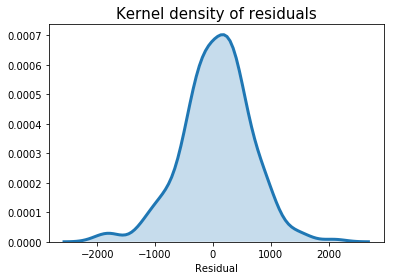

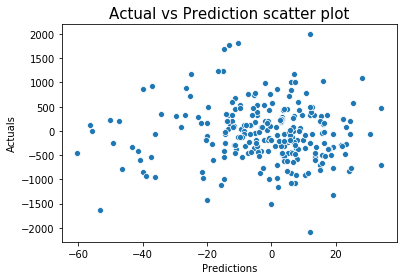

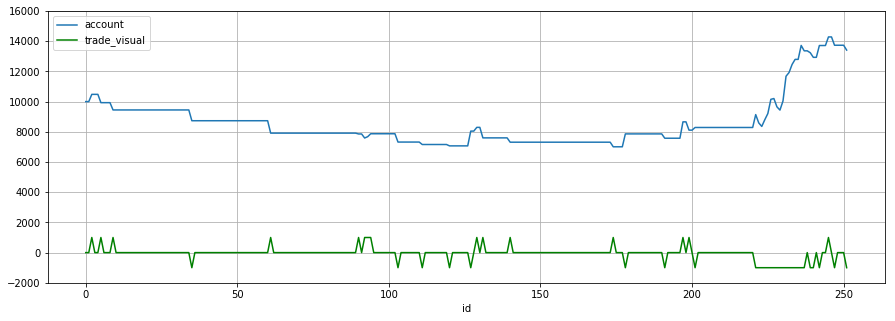

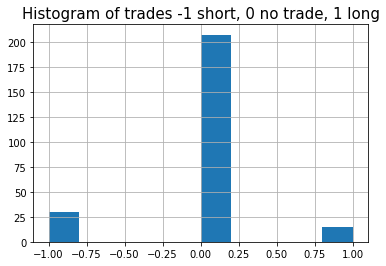

In [115]:
coffee_account = get_performance(coffee_clf, coffee_reg_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_reg_validate, coffee_reg_label_validate, stop_loss_long=1000, stop_loss_short=1000, regression=True, target=20)

# Neural Networks classifier

- gold 187% gains (only shorts were triggered)
- corn 

In [116]:
def create_target(x):
    if x == 1.0:
        return [0,0,1]
    elif x == 0.0:
        return [1,0,0]
    else:
        return [0,1,0]

In [117]:
X = pca_transform(gold_train, gold_pca)
y = gold_label_train
# remove outliers
X, y = remove_outliers(X, y, out_gold)

X_test = pca_transform(gold_test, gold_pca)
y_test = gold_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_gold)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

In [118]:
# %%capture training_gold
from keras.layers import Dropout, Flatten, Dense, Activation, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam
from keras.models import Sequential
from keras.metrics import categorical_accuracy, binary_accuracy, sparse_categorical_accuracy
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import RMSprop

input_shape = 200
num_classes = 3

def define_model(input_shape, num_classes):
    # Define a model
    opt = RMSprop(lr=0.0001)
    
    model = Sequential()  
    model.add(Dense(32, input_dim=input_shape, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Dense(8, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    model.add(Dense(num_classes))
    model.add(Activation('tanh'))

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# opt = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
# opt = Nadam(lr=0.002)
batch_size = 20
epochs = 200
model = define_model(input_shape, num_classes)

In [119]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.gold.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

In [120]:
# model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

model.summary()

Train on 1926 samples, validate on 484 samples
Epoch 1/200
1926/1926 [==============================] - 1s 631us/step - loss: 78736637797.8152 - acc: 0.3484 - val_loss: 74607882925.4876 - val_acc: 0.3760

Epoch 00001: val_loss improved from inf to 74607882925.48761, saving model to saved_models/weights.gold.hdf5
Epoch 2/200
1926/1926 [==============================] - 0s 124us/step - loss: 72040433578.9325 - acc: 0.3572 - val_loss: 68230869415.1405 - val_acc: 0.3781

Epoch 00002: val_loss improved from 74607882925.48761 to 68230869415.14050, saving model to saved_models/weights.gold.hdf5
Epoch 3/200
1926/1926 [==============================] - 0s 126us/step - loss: 65780554544.6480 - acc: 0.3629 - val_loss: 62245799927.5372 - val_acc: 0.3781

Epoch 00003: val_loss improved from 68230869415.14050 to 62245799927.53719, saving model to saved_models/weights.gold.hdf5
Epoch 4/200
1926/1926 [==============================] - 0s 127us/step - loss: 59854118318.6542 - acc: 0.3494 - val_loss: 56

1926/1926 [==============================] - 0s 106us/step - loss: 2352033717.0343 - acc: 0.3754 - val_loss: 2057665687.2727 - val_acc: 0.3843

Epoch 00030: val_loss improved from 2523674383.86777 to 2057665687.27273, saving model to saved_models/weights.gold.hdf5
Epoch 31/200
1926/1926 [==============================] - 0s 110us/step - loss: 1904084838.2471 - acc: 0.3525 - val_loss: 1645278577.4545 - val_acc: 0.3905

Epoch 00031: val_loss improved from 2057665687.27273 to 1645278577.45455, saving model to saved_models/weights.gold.hdf5
Epoch 32/200
1926/1926 [==============================] - 0s 111us/step - loss: 1513523187.9377 - acc: 0.3567 - val_loss: 1287578295.0083 - val_acc: 0.3926

Epoch 00032: val_loss improved from 1645278577.45455 to 1287578295.00826, saving model to saved_models/weights.gold.hdf5
Epoch 33/200
1926/1926 [==============================] - 0s 112us/step - loss: 1167806407.8754 - acc: 0.3593 - val_loss: 977389671.4050 - val_acc: 0.3926

Epoch 00033: val_loss i

1926/1926 [==============================] - 0s 104us/step - loss: 185000.5553 - acc: 0.3557 - val_loss: 190389.0669 - val_acc: 0.3223

Epoch 00064: val_loss did not improve from 165346.60925
Epoch 65/200
1926/1926 [==============================] - 0s 108us/step - loss: 178138.7022 - acc: 0.3645 - val_loss: 165178.0659 - val_acc: 0.3657

Epoch 00065: val_loss improved from 165346.60925 to 165178.06586, saving model to saved_models/weights.gold.hdf5
Epoch 66/200
1926/1926 [==============================] - 0s 104us/step - loss: 185064.8411 - acc: 0.3598 - val_loss: 164679.9832 - val_acc: 0.3388

Epoch 00066: val_loss improved from 165178.06586 to 164679.98321, saving model to saved_models/weights.gold.hdf5
Epoch 67/200
1926/1926 [==============================] - 0s 105us/step - loss: 181815.3838 - acc: 0.3593 - val_loss: 180372.3363 - val_acc: 0.3471

Epoch 00067: val_loss did not improve from 164679.98321
Epoch 68/200
1926/1926 [==============================] - 0s 104us/step - loss:

1926/1926 [==============================] - 0s 105us/step - loss: 181898.3191 - acc: 0.3479 - val_loss: 175099.0435 - val_acc: 0.3657

Epoch 00103: val_loss did not improve from 152336.50023
Epoch 104/200
1926/1926 [==============================] - 0s 109us/step - loss: 182389.2494 - acc: 0.3645 - val_loss: 187855.0870 - val_acc: 0.3037

Epoch 00104: val_loss did not improve from 152336.50023
Epoch 105/200
1926/1926 [==============================] - 0s 103us/step - loss: 184087.1225 - acc: 0.3640 - val_loss: 171343.7292 - val_acc: 0.3512

Epoch 00105: val_loss did not improve from 152336.50023
Epoch 106/200
1926/1926 [==============================] - 0s 104us/step - loss: 182519.3960 - acc: 0.3359 - val_loss: 177386.2144 - val_acc: 0.3430

Epoch 00106: val_loss did not improve from 152336.50023
Epoch 107/200
1926/1926 [==============================] - 0s 104us/step - loss: 183653.3524 - acc: 0.3572 - val_loss: 179958.0579 - val_acc: 0.3244

Epoch 00107: val_loss did not improve fr

1926/1926 [==============================] - 0s 107us/step - loss: 181308.2203 - acc: 0.3598 - val_loss: 165965.3624 - val_acc: 0.3657

Epoch 00143: val_loss did not improve from 152336.50023
Epoch 144/200
1926/1926 [==============================] - 0s 110us/step - loss: 182540.0606 - acc: 0.3609 - val_loss: 203737.7216 - val_acc: 0.3698

Epoch 00144: val_loss did not improve from 152336.50023
Epoch 145/200
1926/1926 [==============================] - 0s 103us/step - loss: 184905.0066 - acc: 0.3385 - val_loss: 171800.2874 - val_acc: 0.3616

Epoch 00145: val_loss did not improve from 152336.50023
Epoch 146/200
1926/1926 [==============================] - 0s 105us/step - loss: 184364.3105 - acc: 0.3499 - val_loss: 180219.5739 - val_acc: 0.3388

Epoch 00146: val_loss did not improve from 152336.50023
Epoch 147/200
1926/1926 [==============================] - 0s 105us/step - loss: 181358.3322 - acc: 0.3588 - val_loss: 180141.5840 - val_acc: 0.3306

Epoch 00147: val_loss did not improve fr


Epoch 00182: val_loss did not improve from 152336.50023
Epoch 183/200
1926/1926 [==============================] - 0s 104us/step - loss: 184106.9508 - acc: 0.3463 - val_loss: 181333.8280 - val_acc: 0.3471

Epoch 00183: val_loss did not improve from 152336.50023
Epoch 184/200
1926/1926 [==============================] - 0s 108us/step - loss: 182127.7854 - acc: 0.3567 - val_loss: 181975.8798 - val_acc: 0.3781

Epoch 00184: val_loss did not improve from 152336.50023
Epoch 185/200
1926/1926 [==============================] - 0s 105us/step - loss: 180834.0010 - acc: 0.3551 - val_loss: 205029.7542 - val_acc: 0.3450

Epoch 00185: val_loss did not improve from 152336.50023
Epoch 186/200
1926/1926 [==============================] - 0s 106us/step - loss: 183388.3443 - acc: 0.3271 - val_loss: 147665.9099 - val_acc: 0.3678

Epoch 00186: val_loss improved from 152336.50023 to 147665.90995, saving model to saved_models/weights.gold.hdf5
Epoch 187/200
1926/1926 [==============================] - 0s 

In [121]:
model.load_weights('saved_models/weights.gold.hdf5')
gold_clf_nn = model

Returns  -2.74 %
Earnings per trade:  -9.15
Earnings per Shorts:  164.19
Earnings per Longs:  -72.18


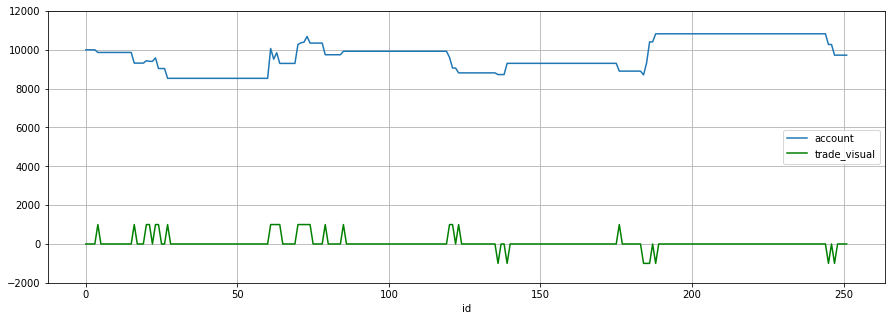

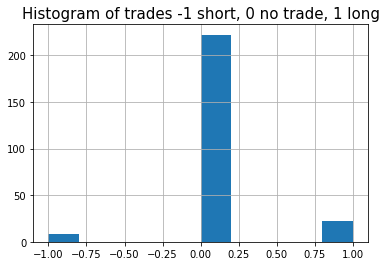

In [154]:
gold_account_nn = get_performance(gold_clf_nn, gold_pca, gold_gains.loc[gold_gains.index > validate_date], gold_validate, gold_label_validate, stop_loss_long=1000, stop_loss_short=800)

In [123]:
X = pca_transform(corn_train, corn_pca)
y = corn_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(corn_test, corn_pca)
y_test = corn_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_corn)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

model = define_model(input_shape, num_classes)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.corn.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

model.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

model.summary()
model.load_weights('saved_models/weights.corn.hdf5')
corn_clf_nn = model

Train on 1930 samples, validate on 483 samples
Epoch 1/200
1930/1930 [==============================] - 1s 693us/step - loss: 67049832023.5440 - acc: 0.3451 - val_loss: 63303556026.0373 - val_acc: 0.3313

Epoch 00001: val_loss improved from inf to 63303556026.03727, saving model to saved_models/weights.corn.hdf5
Epoch 2/200
1930/1930 [==============================] - 0s 127us/step - loss: 60804322712.5389 - acc: 0.3311 - val_loss: 57417700716.6543 - val_acc: 0.3271

Epoch 00002: val_loss improved from 63303556026.03727 to 57417700716.65424, saving model to saved_models/weights.corn.hdf5
Epoch 3/200
1930/1930 [==============================] - 0s 125us/step - loss: 55060895415.0466 - acc: 0.3378 - val_loss: 51949125072.2981 - val_acc: 0.3313

Epoch 00003: val_loss improved from 57417700716.65424 to 51949125072.29813, saving model to saved_models/weights.corn.hdf5
Epoch 4/200
1930/1930 [==============================] - 0s 127us/step - loss: 49729195405.9275 - acc: 0.3130 - val_loss: 46

1930/1930 [==============================] - 0s 107us/step - loss: 1983115162.1969 - acc: 0.3337 - val_loss: 1766386254.2112 - val_acc: 0.3147

Epoch 00030: val_loss improved from 2144115731.04762 to 1766386254.21118, saving model to saved_models/weights.corn.hdf5
Epoch 31/200
1930/1930 [==============================] - 0s 107us/step - loss: 1623674358.0518 - acc: 0.3316 - val_loss: 1433681915.6936 - val_acc: 0.3126

Epoch 00031: val_loss improved from 1766386254.21118 to 1433681915.69358, saving model to saved_models/weights.corn.hdf5
Epoch 32/200
1930/1930 [==============================] - 0s 109us/step - loss: 1309924580.1451 - acc: 0.3254 - val_loss: 1140685186.5176 - val_acc: 0.3147

Epoch 00032: val_loss improved from 1433681915.69358 to 1140685186.51760, saving model to saved_models/weights.corn.hdf5
Epoch 33/200
1930/1930 [==============================] - 0s 106us/step - loss: 1030779701.3886 - acc: 0.3249 - val_loss: 884888986.4017 - val_acc: 0.3188

Epoch 00033: val_loss i

1930/1930 [==============================] - 0s 106us/step - loss: 155890.1288 - acc: 0.3342 - val_loss: 168452.8523 - val_acc: 0.2836

Epoch 00063: val_loss did not improve from 125544.18855
Epoch 64/200
1930/1930 [==============================] - 0s 105us/step - loss: 154676.6400 - acc: 0.3181 - val_loss: 159240.8919 - val_acc: 0.3168

Epoch 00064: val_loss did not improve from 125544.18855
Epoch 65/200
1930/1930 [==============================] - 0s 112us/step - loss: 155477.4685 - acc: 0.3440 - val_loss: 162452.0460 - val_acc: 0.3437

Epoch 00065: val_loss did not improve from 125544.18855
Epoch 66/200
1930/1930 [==============================] - 0s 107us/step - loss: 157994.0997 - acc: 0.3466 - val_loss: 151458.1381 - val_acc: 0.3644

Epoch 00066: val_loss did not improve from 125544.18855
Epoch 67/200
1930/1930 [==============================] - 0s 106us/step - loss: 155197.1389 - acc: 0.3130 - val_loss: 182436.1393 - val_acc: 0.3478

Epoch 00067: val_loss did not improve from 1

1930/1930 [==============================] - 0s 105us/step - loss: 158412.9567 - acc: 0.3150 - val_loss: 160895.6151 - val_acc: 0.3375

Epoch 00103: val_loss did not improve from 125544.18855
Epoch 104/200
1930/1930 [==============================] - 0s 110us/step - loss: 154488.7317 - acc: 0.3321 - val_loss: 150633.7475 - val_acc: 0.3395

Epoch 00104: val_loss did not improve from 125544.18855
Epoch 105/200
1930/1930 [==============================] - 0s 104us/step - loss: 157312.8506 - acc: 0.3358 - val_loss: 159844.9075 - val_acc: 0.3623

Epoch 00105: val_loss did not improve from 125544.18855
Epoch 106/200
1930/1930 [==============================] - 0s 104us/step - loss: 156614.3293 - acc: 0.3259 - val_loss: 151180.2454 - val_acc: 0.3106

Epoch 00106: val_loss did not improve from 125544.18855
Epoch 107/200
1930/1930 [==============================] - 0s 113us/step - loss: 155464.7254 - acc: 0.3212 - val_loss: 152325.1703 - val_acc: 0.3458

Epoch 00107: val_loss did not improve fr

1930/1930 [==============================] - 0s 110us/step - loss: 155637.5235 - acc: 0.3321 - val_loss: 155637.2920 - val_acc: 0.3271

Epoch 00143: val_loss did not improve from 125544.18855
Epoch 144/200
1930/1930 [==============================] - 0s 111us/step - loss: 158398.8160 - acc: 0.3264 - val_loss: 173401.9189 - val_acc: 0.3810

Epoch 00144: val_loss did not improve from 125544.18855
Epoch 145/200
1930/1930 [==============================] - 0s 111us/step - loss: 157429.2391 - acc: 0.3062 - val_loss: 156461.6018 - val_acc: 0.3561

Epoch 00145: val_loss did not improve from 125544.18855
Epoch 146/200
1930/1930 [==============================] - 0s 105us/step - loss: 154777.6286 - acc: 0.3378 - val_loss: 142164.4953 - val_acc: 0.3333

Epoch 00146: val_loss did not improve from 125544.18855
Epoch 147/200
1930/1930 [==============================] - 0s 106us/step - loss: 159467.5123 - acc: 0.3358 - val_loss: 177371.5873 - val_acc: 0.3582

Epoch 00147: val_loss did not improve fr

1930/1930 [==============================] - 0s 103us/step - loss: 155960.3187 - acc: 0.3326 - val_loss: 140151.2229 - val_acc: 0.3375

Epoch 00183: val_loss did not improve from 125544.18855
Epoch 184/200
1930/1930 [==============================] - 0s 104us/step - loss: 153903.6051 - acc: 0.3067 - val_loss: 168855.5578 - val_acc: 0.3375

Epoch 00184: val_loss did not improve from 125544.18855
Epoch 185/200
1930/1930 [==============================] - ETA: 0s - loss: 156912.0377 - acc: 0.34 - 0s 104us/step - loss: 157983.1465 - acc: 0.3347 - val_loss: 161718.9616 - val_acc: 0.3665

Epoch 00185: val_loss did not improve from 125544.18855
Epoch 186/200
1930/1930 [==============================] - 0s 98us/step - loss: 158351.6762 - acc: 0.3166 - val_loss: 151472.7045 - val_acc: 0.3582

Epoch 00186: val_loss did not improve from 125544.18855
Epoch 187/200
1930/1930 [==============================] - 0s 108us/step - loss: 154221.8304 - acc: 0.3352 - val_loss: 154953.9315 - val_acc: 0.3458


Returns  -45.60 %
Earnings per trade:  -24.38
Earnings per Shorts:  -25.35
Earnings per Longs:  -22.48


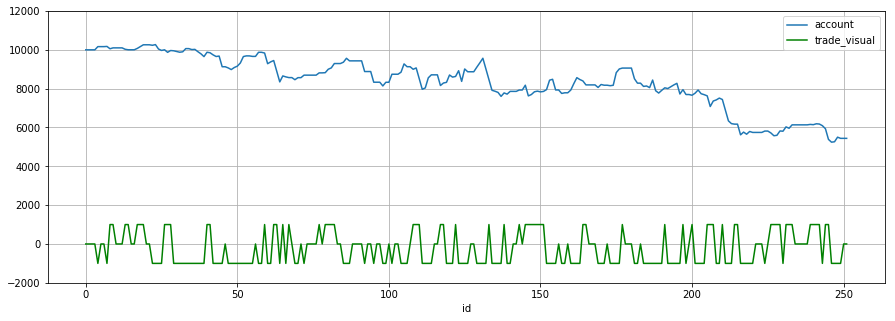

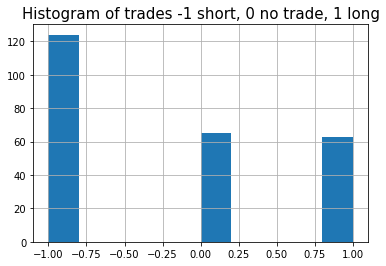

In [148]:
corn_account_nn = get_performance(corn_clf_nn, corn_pca, corn_gains.loc[corn_gains.index > validate_date], corn_validate, corn_label_validate, stop_loss_long=300, stop_loss_short=300)

In [125]:
X = pca_transform(coffee_train, coffee_pca)
y = coffee_label_train
# remove outliers
X, y = remove_outliers(X, y, out_coffee)

X_test = pca_transform(coffee_test, coffee_pca)
y_test = coffee_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_coffee)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

model = define_model(input_shape, num_classes)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.coffee.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

model.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

model.summary()
model.load_weights('saved_models/weights.coffee.hdf5')
coffee_clf_nn = model

Train on 1923 samples, validate on 481 samples
Epoch 1/200
1923/1923 [==============================] - 1s 748us/step - loss: 4466247052.9132 - acc: 0.3604 - val_loss: 4322272302.3035 - val_acc: 0.3264

Epoch 00001: val_loss improved from inf to 4322272302.30353, saving model to saved_models/weights.coffee.hdf5
Epoch 2/200
1923/1923 [==============================] - 0s 132us/step - loss: 4316234140.4639 - acc: 0.3833 - val_loss: 4170284175.9667 - val_acc: 0.3243

Epoch 00002: val_loss improved from 4322272302.30353 to 4170284175.96674, saving model to saved_models/weights.coffee.hdf5
Epoch 3/200
1923/1923 [==============================] - 0s 126us/step - loss: 4152915688.5034 - acc: 0.3469 - val_loss: 4022771169.3971 - val_acc: 0.3285

Epoch 00003: val_loss improved from 4170284175.96674 to 4022771169.39709, saving model to saved_models/weights.coffee.hdf5
Epoch 4/200
1923/1923 [==============================] - 0s 128us/step - loss: 4017383261.9449 - acc: 0.3495 - val_loss: 38794352

1923/1923 [==============================] - 0s 114us/step - loss: 1404027882.6334 - acc: 0.3385 - val_loss: 1336117352.3160 - val_acc: 0.3493

Epoch 00030: val_loss improved from 1404682904.61538 to 1336117352.31601, saving model to saved_models/weights.coffee.hdf5
Epoch 31/200
1923/1923 [==============================] - 0s 127us/step - loss: 1335780198.4899 - acc: 0.3484 - val_loss: 1270394326.7526 - val_acc: 0.3493

Epoch 00031: val_loss improved from 1336117352.31601 to 1270394326.75260, saving model to saved_models/weights.coffee.hdf5
Epoch 32/200
1923/1923 [==============================] - 0s 128us/step - loss: 1271544416.0062 - acc: 0.3302 - val_loss: 1206073749.9543 - val_acc: 0.3493

Epoch 00032: val_loss improved from 1270394326.75260 to 1206073749.95426, saving model to saved_models/weights.coffee.hdf5
Epoch 33/200
1923/1923 [==============================] - 0s 110us/step - loss: 1206646756.4748 - acc: 0.3349 - val_loss: 1142983780.1913 - val_acc: 0.3576

Epoch 00033: val

Epoch 60/200
1923/1923 [==============================] - 0s 123us/step - loss: 121011628.9423 - acc: 0.3495 - val_loss: 105325040.9647 - val_acc: 0.3534

Epoch 00060: val_loss improved from 123367214.01663 to 105325040.96466, saving model to saved_models/weights.coffee.hdf5
Epoch 61/200
1923/1923 [==============================] - 0s 120us/step - loss: 103455246.8632 - acc: 0.3562 - val_loss: 89173399.9335 - val_acc: 0.3493

Epoch 00061: val_loss improved from 105325040.96466 to 89173399.93347, saving model to saved_models/weights.coffee.hdf5
Epoch 62/200
1923/1923 [==============================] - 0s 115us/step - loss: 87410689.2228 - acc: 0.3391 - val_loss: 74329672.8316 - val_acc: 0.3472

Epoch 00062: val_loss improved from 89173399.93347 to 74329672.83160, saving model to saved_models/weights.coffee.hdf5
Epoch 63/200
1923/1923 [==============================] - 0s 111us/step - loss: 72704772.5130 - acc: 0.3370 - val_loss: 60990110.2204 - val_acc: 0.3493

Epoch 00063: val_loss imp

1923/1923 [==============================] - 0s 110us/step - loss: 51871.0784 - acc: 0.3188 - val_loss: 51976.7360 - val_acc: 0.3056

Epoch 00094: val_loss did not improve from 48173.02976
Epoch 95/200
1923/1923 [==============================] - 0s 107us/step - loss: 51606.8135 - acc: 0.3266 - val_loss: 54582.7932 - val_acc: 0.3326

Epoch 00095: val_loss did not improve from 48173.02976
Epoch 96/200
1923/1923 [==============================] - 0s 109us/step - loss: 51823.1241 - acc: 0.3307 - val_loss: 53473.3662 - val_acc: 0.3035

Epoch 00096: val_loss did not improve from 48173.02976
Epoch 97/200
1923/1923 [==============================] - 0s 108us/step - loss: 51714.8722 - acc: 0.3224 - val_loss: 50943.7367 - val_acc: 0.2952

Epoch 00097: val_loss did not improve from 48173.02976
Epoch 98/200
1923/1923 [==============================] - 0s 110us/step - loss: 50565.8726 - acc: 0.3229 - val_loss: 57663.2256 - val_acc: 0.2931

Epoch 00098: val_loss did not improve from 48173.02976
Epo

1923/1923 [==============================] - 0s 119us/step - loss: 48450.3911 - acc: 0.3146 - val_loss: 57117.9698 - val_acc: 0.2744

Epoch 00134: val_loss did not improve from 47561.36716
Epoch 135/200
1923/1923 [==============================] - 0s 115us/step - loss: 54264.7106 - acc: 0.3276 - val_loss: 52463.3133 - val_acc: 0.2848

Epoch 00135: val_loss did not improve from 47561.36716
Epoch 136/200
1923/1923 [==============================] - 0s 111us/step - loss: 52077.3535 - acc: 0.2860 - val_loss: 54975.8772 - val_acc: 0.2973

Epoch 00136: val_loss did not improve from 47561.36716
Epoch 137/200
1923/1923 [==============================] - 0s 110us/step - loss: 50538.9029 - acc: 0.3099 - val_loss: 55374.9994 - val_acc: 0.2952

Epoch 00137: val_loss did not improve from 47561.36716
Epoch 138/200
1923/1923 [==============================] - 0s 112us/step - loss: 53060.7960 - acc: 0.3255 - val_loss: 54415.3983 - val_acc: 0.2661

Epoch 00138: val_loss did not improve from 47561.36716

1923/1923 [==============================] - 0s 112us/step - loss: 50851.2223 - acc: 0.2907 - val_loss: 52809.5061 - val_acc: 0.2703

Epoch 00174: val_loss did not improve from 45965.65632
Epoch 175/200
1923/1923 [==============================] - 0s 107us/step - loss: 54350.5425 - acc: 0.3089 - val_loss: 50775.9981 - val_acc: 0.2474

Epoch 00175: val_loss did not improve from 45965.65632
Epoch 176/200
1923/1923 [==============================] - 0s 113us/step - loss: 51515.1591 - acc: 0.2980 - val_loss: 51937.1207 - val_acc: 0.2620

Epoch 00176: val_loss did not improve from 45965.65632
Epoch 177/200
1923/1923 [==============================] - 0s 206us/step - loss: 51432.4095 - acc: 0.3053 - val_loss: 50689.3991 - val_acc: 0.2620

Epoch 00177: val_loss did not improve from 45965.65632
Epoch 178/200
1923/1923 [==============================] - 0s 117us/step - loss: 50730.5190 - acc: 0.2954 - val_loss: 53489.3771 - val_acc: 0.2682

Epoch 00178: val_loss did not improve from 45965.65632

Returns  -30.73 %
Earnings per trade:  -219.50
Earnings per Shorts:  0.00
Earnings per Longs:  -219.50


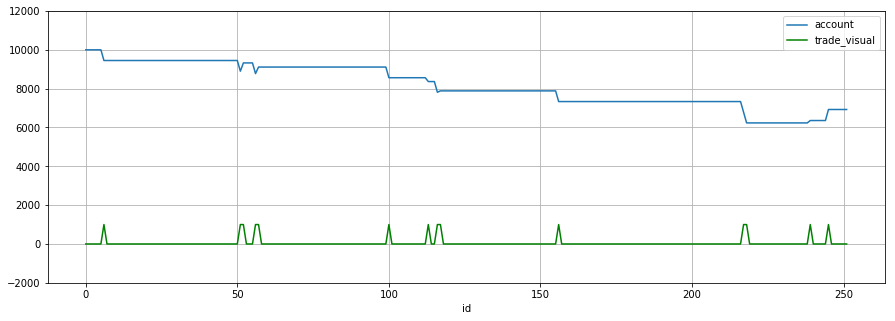

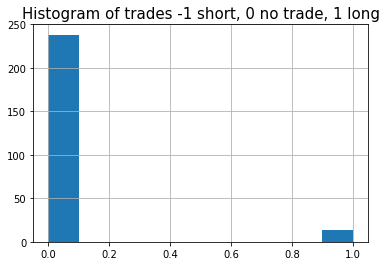

In [155]:
coffee_account_nn = get_performance(coffee_clf_nn, coffee_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_validate, coffee_label_validate, stop_loss_long=300, stop_loss_short=300)

In [202]:
import keras
import tensorflow as tf
# from sklearn.metrics import mean_squared_error
from tensorflow.losses import mean_squared_error
from keras.optimizers import Nadam


def huber_loss(y_true, y_pred):
    return tf.losses.huber_loss(y_true,y_pred)


def weighted_mean_squared_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, weights=0.75)


# loss = huber_loss
loss = weighted_mean_squared_error
# optimizer = 'Adam'
optimizer = Nadam(lr=0.0001)

def regressor_model():
    global input_shape
    global loss
    global optimizer
    # Define a model
    #     model = Sequential()  
    #     model.add(Dense(32, input_dim=input_shape, activity_regularizer=regularizers.l2(0.01)))
    #     model.add(BatchNormalization())
    #     model.add(LeakyReLU())
    #     model.add(Dropout(0.4))
    #     model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
    #     model.add(BatchNormalization())
    #     model.add(LeakyReLU())
    #     model.add(Dropout(0.3))
    #     model.add(Dense(8, activity_regularizer=regularizers.l2(0.01)))
    #     model.add(BatchNormalization())
    #     model.add(LeakyReLU())
    #     model.add(Dropout(0.2))
    #     # model.add(Dense(1))
    #     # model.add(Activation('tanh'))
    #     model.add(Dense(1, kernel_initializer='normal'))
    
    alpha=.0001
    model = Sequential()
    model.add(Dense(500, input_dim=input_shape, kernel_initializer='normal', activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dropout(0.4))
    model.add(Dense(128, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(64, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(32, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    return model

    # model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
    # model.compile(loss='l1', optimizer='sgd', metrics=['mse'])
    # return model

In [203]:
X = pca_transform(gold_reg_train, gold_reg_pca)
y = gold_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_gold)

X_test = pca_transform(gold_reg_test, gold_reg_pca)
y_test = gold_reg_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_gold)

epochs = 1000
batch_size = 50

checkpointer = ModelCheckpoint(filepath='saved_models/weights.gold_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=epochs, batch_size=batch_size)

In [204]:
estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

Train on 1926 samples, validate on 484 samples
Epoch 1/1000
1926/1926 [==============================] - 3s 2ms/step - loss: 1280248.0239 - val_loss: 1215206.1712

Epoch 00001: val_loss improved from inf to 1215206.17123, saving model to saved_models/weights.gold_reg.hdf5
Epoch 2/1000
1926/1926 [==============================] - 0s 180us/step - loss: 1280251.1416 - val_loss: 1215205.4543

Epoch 00002: val_loss improved from 1215206.17123 to 1215205.45429, saving model to saved_models/weights.gold_reg.hdf5
Epoch 3/1000
1926/1926 [==============================] - 0s 190us/step - loss: 1280230.9346 - val_loss: 1215205.7521

Epoch 00003: val_loss did not improve from 1215205.45429
Epoch 4/1000
1926/1926 [==============================] - 0s 178us/step - loss: 1280198.3490 - val_loss: 1215205.6470

Epoch 00004: val_loss did not improve from 1215205.45429
Epoch 5/1000
1926/1926 [==============================] - 0s 183us/step - loss: 1280217.3294 - val_loss: 1215204.9483

Epoch 00005: val_l

1926/1926 [==============================] - 0s 199us/step - loss: 1279594.9455 - val_loss: 1215197.1867

Epoch 00045: val_loss improved from 1215199.57774 to 1215197.18673, saving model to saved_models/weights.gold_reg.hdf5
Epoch 46/1000
1926/1926 [==============================] - 0s 189us/step - loss: 1279519.5509 - val_loss: 1215193.4835

Epoch 00046: val_loss improved from 1215197.18673 to 1215193.48347, saving model to saved_models/weights.gold_reg.hdf5
Epoch 47/1000
1926/1926 [==============================] - 0s 182us/step - loss: 1279625.0058 - val_loss: 1215190.7061

Epoch 00047: val_loss improved from 1215193.48347 to 1215190.70610, saving model to saved_models/weights.gold_reg.hdf5
Epoch 48/1000
1926/1926 [==============================] - 0s 177us/step - loss: 1279543.0958 - val_loss: 1215188.0364

Epoch 00048: val_loss improved from 1215190.70610 to 1215188.03642, saving model to saved_models/weights.gold_reg.hdf5
Epoch 49/1000
1926/1926 [==============================] -

Epoch 86/1000
1926/1926 [==============================] - 0s 204us/step - loss: 1273512.9265 - val_loss: 1215101.0300

Epoch 00086: val_loss did not improve from 1215092.57670
Epoch 87/1000
1926/1926 [==============================] - 0s 195us/step - loss: 1273148.4014 - val_loss: 1215108.7043

Epoch 00087: val_loss did not improve from 1215092.57670
Epoch 88/1000
1926/1926 [==============================] - 0s 181us/step - loss: 1273156.2568 - val_loss: 1215087.4654

Epoch 00088: val_loss improved from 1215092.57670 to 1215087.46539, saving model to saved_models/weights.gold_reg.hdf5
Epoch 89/1000
1926/1926 [==============================] - 0s 180us/step - loss: 1272727.7237 - val_loss: 1215058.2342

Epoch 00089: val_loss improved from 1215087.46539 to 1215058.23425, saving model to saved_models/weights.gold_reg.hdf5
Epoch 90/1000
1926/1926 [==============================] - 0s 188us/step - loss: 1272380.9060 - val_loss: 1215046.6371

Epoch 00090: val_loss improved from 1215058.2342

1926/1926 [==============================] - 0s 191us/step - loss: 1262279.3056 - val_loss: 1215043.4682

Epoch 00131: val_loss did not improve from 1215041.55217
Epoch 132/1000
1926/1926 [==============================] - 0s 180us/step - loss: 1261887.7517 - val_loss: 1214999.5416

Epoch 00132: val_loss improved from 1215041.55217 to 1214999.54158, saving model to saved_models/weights.gold_reg.hdf5
Epoch 133/1000
1926/1926 [==============================] - 0s 190us/step - loss: 1262076.2744 - val_loss: 1214992.9840

Epoch 00133: val_loss improved from 1214999.54158 to 1214992.98399, saving model to saved_models/weights.gold_reg.hdf5
Epoch 134/1000
1926/1926 [==============================] - 0s 190us/step - loss: 1261517.8915 - val_loss: 1214976.8290

Epoch 00134: val_loss improved from 1214992.98399 to 1214976.82903, saving model to saved_models/weights.gold_reg.hdf5
Epoch 135/1000
1926/1926 [==============================] - 0s 209us/step - loss: 1261652.6662 - val_loss: 1215007.08

Epoch 174/1000
1926/1926 [==============================] - 0s 198us/step - loss: 1247792.6529 - val_loss: 1214828.5958

Epoch 00174: val_loss improved from 1214841.57386 to 1214828.59582, saving model to saved_models/weights.gold_reg.hdf5
Epoch 175/1000
1926/1926 [==============================] - 0s 214us/step - loss: 1248586.8724 - val_loss: 1214875.0984

Epoch 00175: val_loss did not improve from 1214828.59582
Epoch 176/1000
1926/1926 [==============================] - 0s 197us/step - loss: 1247973.1355 - val_loss: 1214866.1196

Epoch 00176: val_loss did not improve from 1214828.59582
Epoch 177/1000
1926/1926 [==============================] - 0s 186us/step - loss: 1248238.7662 - val_loss: 1214823.8931

Epoch 00177: val_loss improved from 1214828.59582 to 1214823.89308, saving model to saved_models/weights.gold_reg.hdf5
Epoch 178/1000
1926/1926 [==============================] - 0s 199us/step - loss: 1247650.7258 - val_loss: 1214816.7009

Epoch 00178: val_loss improved from 1214823

1926/1926 [==============================] - 0s 175us/step - loss: 1233081.1800 - val_loss: 1214361.8946

Epoch 00215: val_loss did not improve from 1214274.86338
Epoch 216/1000
1926/1926 [==============================] - 0s 177us/step - loss: 1231776.1695 - val_loss: 1214292.0669

Epoch 00216: val_loss did not improve from 1214274.86338
Epoch 217/1000
1926/1926 [==============================] - 0s 152us/step - loss: 1233038.9530 - val_loss: 1214233.6043

Epoch 00217: val_loss improved from 1214274.86338 to 1214233.60434, saving model to saved_models/weights.gold_reg.hdf5
Epoch 218/1000
1926/1926 [==============================] - 0s 156us/step - loss: 1231658.9517 - val_loss: 1214116.6085

Epoch 00218: val_loss improved from 1214233.60434 to 1214116.60847, saving model to saved_models/weights.gold_reg.hdf5
Epoch 219/1000
1926/1926 [==============================] - 0s 167us/step - loss: 1232020.1097 - val_loss: 1214043.8665

Epoch 00219: val_loss improved from 1214116.60847 to 12140

1926/1926 [==============================] - 0s 165us/step - loss: 1214252.4381 - val_loss: 1213597.4876

Epoch 00257: val_loss improved from 1213619.70248 to 1213597.48760, saving model to saved_models/weights.gold_reg.hdf5
Epoch 258/1000
1926/1926 [==============================] - 0s 174us/step - loss: 1214989.5733 - val_loss: 1213501.4316

Epoch 00258: val_loss improved from 1213597.48760 to 1213501.43156, saving model to saved_models/weights.gold_reg.hdf5
Epoch 259/1000
1926/1926 [==============================] - 0s 159us/step - loss: 1212096.5200 - val_loss: 1213499.3660

Epoch 00259: val_loss improved from 1213501.43156 to 1213499.36596, saving model to saved_models/weights.gold_reg.hdf5
Epoch 260/1000
1926/1926 [==============================] - 0s 162us/step - loss: 1212347.3026 - val_loss: 1213436.9150

Epoch 00260: val_loss improved from 1213499.36596 to 1213436.91503, saving model to saved_models/weights.gold_reg.hdf5
Epoch 261/1000
1926/1926 [=============================


Epoch 00297: val_loss did not improve from 1212622.41142
Epoch 298/1000
1926/1926 [==============================] - 0s 162us/step - loss: 1196613.5207 - val_loss: 1212590.1389

Epoch 00298: val_loss improved from 1212622.41142 to 1212590.13895, saving model to saved_models/weights.gold_reg.hdf5
Epoch 299/1000
1926/1926 [==============================] - 0s 167us/step - loss: 1192073.0451 - val_loss: 1212629.9419

Epoch 00299: val_loss did not improve from 1212590.13895
Epoch 300/1000
1926/1926 [==============================] - 0s 165us/step - loss: 1192725.0539 - val_loss: 1212702.3905

Epoch 00300: val_loss did not improve from 1212590.13895
Epoch 301/1000
1926/1926 [==============================] - 0s 162us/step - loss: 1193428.6187 - val_loss: 1212585.1413

Epoch 00301: val_loss improved from 1212590.13895 to 1212585.14127, saving model to saved_models/weights.gold_reg.hdf5
Epoch 302/1000
1926/1926 [==============================] - 0s 170us/step - loss: 1190634.3056 - val_loss:

1926/1926 [==============================] - 0s 158us/step - loss: 1170962.5003 - val_loss: 1212124.5276

Epoch 00342: val_loss improved from 1212223.20455 to 1212124.52763, saving model to saved_models/weights.gold_reg.hdf5
Epoch 343/1000
1926/1926 [==============================] - 0s 163us/step - loss: 1168288.6458 - val_loss: 1211992.2144

Epoch 00343: val_loss improved from 1212124.52763 to 1211992.21436, saving model to saved_models/weights.gold_reg.hdf5
Epoch 344/1000
1926/1926 [==============================] - 0s 171us/step - loss: 1170018.9285 - val_loss: 1211993.4055

Epoch 00344: val_loss did not improve from 1211992.21436
Epoch 345/1000
1926/1926 [==============================] - 0s 165us/step - loss: 1167671.1709 - val_loss: 1211925.0436

Epoch 00345: val_loss improved from 1211992.21436 to 1211925.04365, saving model to saved_models/weights.gold_reg.hdf5
Epoch 346/1000
1926/1926 [==============================] - 0s 157us/step - loss: 1167696.9167 - val_loss: 1211906.38


Epoch 00383: val_loss did not improve from 1210757.70170
Epoch 384/1000
1926/1926 [==============================] - 0s 161us/step - loss: 1145889.7026 - val_loss: 1211102.5129

Epoch 00384: val_loss did not improve from 1210757.70170
Epoch 385/1000
1926/1926 [==============================] - 0s 156us/step - loss: 1141014.5835 - val_loss: 1211148.4212

Epoch 00385: val_loss did not improve from 1210757.70170
Epoch 386/1000
1926/1926 [==============================] - 0s 163us/step - loss: 1144220.5481 - val_loss: 1211256.5770

Epoch 00386: val_loss did not improve from 1210757.70170
Epoch 387/1000
1926/1926 [==============================] - 0s 169us/step - loss: 1143770.9802 - val_loss: 1211274.3995

Epoch 00387: val_loss did not improve from 1210757.70170
Epoch 388/1000
1926/1926 [==============================] - 0s 182us/step - loss: 1141557.4518 - val_loss: 1211437.3484

Epoch 00388: val_loss did not improve from 1210757.70170
Epoch 389/1000
1926/1926 [==========================

1926/1926 [==============================] - 0s 157us/step - loss: 1117326.7120 - val_loss: 1211306.4096

Epoch 00430: val_loss did not improve from 1210757.70170
Epoch 431/1000
1926/1926 [==============================] - 0s 160us/step - loss: 1117100.9151 - val_loss: 1211306.9321

Epoch 00431: val_loss did not improve from 1210757.70170
Epoch 432/1000
1926/1926 [==============================] - 0s 169us/step - loss: 1114277.9198 - val_loss: 1211204.3716

Epoch 00432: val_loss did not improve from 1210757.70170
Epoch 433/1000
1926/1926 [==============================] - 0s 159us/step - loss: 1116982.5504 - val_loss: 1211035.6792

Epoch 00433: val_loss did not improve from 1210757.70170
Epoch 434/1000
1926/1926 [==============================] - 0s 161us/step - loss: 1113180.4842 - val_loss: 1210940.0961

Epoch 00434: val_loss did not improve from 1210757.70170
Epoch 435/1000
1926/1926 [==============================] - 0s 155us/step - loss: 1115377.7244 - val_loss: 1210810.4220

Epoc

1926/1926 [==============================] - 0s 175us/step - loss: 1081705.3560 - val_loss: 1210776.9848

Epoch 00476: val_loss did not improve from 1210410.94783
Epoch 477/1000
1926/1926 [==============================] - 0s 176us/step - loss: 1088450.4202 - val_loss: 1210506.2169

Epoch 00477: val_loss did not improve from 1210410.94783
Epoch 478/1000
1926/1926 [==============================] - 0s 169us/step - loss: 1090796.5036 - val_loss: 1210419.5343

Epoch 00478: val_loss did not improve from 1210410.94783
Epoch 479/1000
1926/1926 [==============================] - 0s 160us/step - loss: 1083859.5269 - val_loss: 1210187.9928

Epoch 00479: val_loss improved from 1210410.94783 to 1210187.99277, saving model to saved_models/weights.gold_reg.hdf5
Epoch 480/1000
1926/1926 [==============================] - 0s 161us/step - loss: 1081787.9130 - val_loss: 1210186.6302

Epoch 00480: val_loss improved from 1210187.99277 to 1210186.63017, saving model to saved_models/weights.gold_reg.hdf5
E

1926/1926 [==============================] - 0s 156us/step - loss: 1055444.5586 - val_loss: 1210673.5183

Epoch 00520: val_loss did not improve from 1209796.31921
Epoch 521/1000
1926/1926 [==============================] - 0s 154us/step - loss: 1054176.5654 - val_loss: 1210828.8334

Epoch 00521: val_loss did not improve from 1209796.31921
Epoch 522/1000
1926/1926 [==============================] - 0s 148us/step - loss: 1049445.7082 - val_loss: 1210778.8218

Epoch 00522: val_loss did not improve from 1209796.31921
Epoch 523/1000
1926/1926 [==============================] - 0s 154us/step - loss: 1057336.5913 - val_loss: 1211007.6459

Epoch 00523: val_loss did not improve from 1209796.31921
Epoch 524/1000
1926/1926 [==============================] - 0s 153us/step - loss: 1053876.1067 - val_loss: 1211114.2231

Epoch 00524: val_loss did not improve from 1209796.31921
Epoch 525/1000
1926/1926 [==============================] - 0s 150us/step - loss: 1055384.6435 - val_loss: 1211273.3231

Epoc

1926/1926 [==============================] - 0s 159us/step - loss: 1018742.7527 - val_loss: 1212167.7541

Epoch 00566: val_loss did not improve from 1209796.31921
Epoch 567/1000
1926/1926 [==============================] - 0s 156us/step - loss: 1019708.0839 - val_loss: 1212228.2247

Epoch 00567: val_loss did not improve from 1209796.31921
Epoch 568/1000
1926/1926 [==============================] - 0s 155us/step - loss: 1023301.0522 - val_loss: 1212174.8636

Epoch 00568: val_loss did not improve from 1209796.31921
Epoch 569/1000
1926/1926 [==============================] - 0s 157us/step - loss: 1021791.6995 - val_loss: 1212446.4166

Epoch 00569: val_loss did not improve from 1209796.31921
Epoch 570/1000
1926/1926 [==============================] - 0s 156us/step - loss: 1012868.3461 - val_loss: 1212580.4672

Epoch 00570: val_loss did not improve from 1209796.31921
Epoch 571/1000
1926/1926 [==============================] - 0s 149us/step - loss: 1016704.3631 - val_loss: 1212678.1002

Epoc

1926/1926 [==============================] - 0s 172us/step - loss: 980319.8989 - val_loss: 1214922.3936

Epoch 00612: val_loss did not improve from 1209796.31921
Epoch 613/1000
1926/1926 [==============================] - 0s 154us/step - loss: 980557.7762 - val_loss: 1214448.3802

Epoch 00613: val_loss did not improve from 1209796.31921
Epoch 614/1000
1926/1926 [==============================] - 0s 156us/step - loss: 985488.3102 - val_loss: 1214437.0005

Epoch 00614: val_loss did not improve from 1209796.31921
Epoch 615/1000
1926/1926 [==============================] - 0s 151us/step - loss: 979067.5947 - val_loss: 1214355.6622

Epoch 00615: val_loss did not improve from 1209796.31921
Epoch 616/1000
1926/1926 [==============================] - 0s 152us/step - loss: 985092.1629 - val_loss: 1213930.8590

Epoch 00616: val_loss did not improve from 1209796.31921
Epoch 617/1000
1926/1926 [==============================] - 0s 159us/step - loss: 979148.8582 - val_loss: 1213853.4930

Epoch 0061

1926/1926 [==============================] - 0s 157us/step - loss: 944337.6942 - val_loss: 1215820.3918

Epoch 00658: val_loss did not improve from 1209796.31921
Epoch 659/1000
1926/1926 [==============================] - 0s 162us/step - loss: 946725.0045 - val_loss: 1215343.7087

Epoch 00659: val_loss did not improve from 1209796.31921
Epoch 660/1000
1926/1926 [==============================] - 0s 161us/step - loss: 941019.7895 - val_loss: 1215429.9966

Epoch 00660: val_loss did not improve from 1209796.31921
Epoch 661/1000
1926/1926 [==============================] - 0s 160us/step - loss: 947440.9364 - val_loss: 1215474.6878

Epoch 00661: val_loss did not improve from 1209796.31921
Epoch 662/1000
1926/1926 [==============================] - 0s 164us/step - loss: 946398.1091 - val_loss: 1215735.9985

Epoch 00662: val_loss did not improve from 1209796.31921
Epoch 663/1000
1926/1926 [==============================] - 0s 162us/step - loss: 938781.6633 - val_loss: 1216085.2350

Epoch 0066

1926/1926 [==============================] - 0s 157us/step - loss: 910821.3926 - val_loss: 1222522.5346

Epoch 00704: val_loss did not improve from 1209796.31921
Epoch 705/1000
1926/1926 [==============================] - 0s 162us/step - loss: 907551.0018 - val_loss: 1222618.8115

Epoch 00705: val_loss did not improve from 1209796.31921
Epoch 706/1000
1926/1926 [==============================] - 0s 159us/step - loss: 908335.3284 - val_loss: 1223180.5708

Epoch 00706: val_loss did not improve from 1209796.31921
Epoch 707/1000
1926/1926 [==============================] - 0s 155us/step - loss: 910930.5192 - val_loss: 1223299.8649

Epoch 00707: val_loss did not improve from 1209796.31921
Epoch 708/1000
1926/1926 [==============================] - 0s 156us/step - loss: 910692.8108 - val_loss: 1222545.9256

Epoch 00708: val_loss did not improve from 1209796.31921
Epoch 709/1000
1926/1926 [==============================] - 0s 157us/step - loss: 906905.1569 - val_loss: 1221483.4907

Epoch 0070

1926/1926 [==============================] - 0s 158us/step - loss: 876728.9473 - val_loss: 1225460.1157

Epoch 00750: val_loss did not improve from 1209796.31921
Epoch 751/1000
1926/1926 [==============================] - 0s 155us/step - loss: 867178.9889 - val_loss: 1224977.4943

Epoch 00751: val_loss did not improve from 1209796.31921
Epoch 752/1000
1926/1926 [==============================] - 0s 157us/step - loss: 873083.4436 - val_loss: 1224748.2089

Epoch 00752: val_loss did not improve from 1209796.31921
Epoch 753/1000
1926/1926 [==============================] - 0s 160us/step - loss: 868819.4828 - val_loss: 1225251.9445

Epoch 00753: val_loss did not improve from 1209796.31921
Epoch 754/1000
1926/1926 [==============================] - 0s 158us/step - loss: 874826.6538 - val_loss: 1225455.4832

Epoch 00754: val_loss did not improve from 1209796.31921
Epoch 755/1000
1926/1926 [==============================] - 0s 158us/step - loss: 859022.9159 - val_loss: 1225645.7469

Epoch 0075

1926/1926 [==============================] - 0s 158us/step - loss: 827729.1708 - val_loss: 1232659.5519

Epoch 00796: val_loss did not improve from 1209796.31921
Epoch 797/1000
1926/1926 [==============================] - 0s 157us/step - loss: 827471.8575 - val_loss: 1232996.0586

Epoch 00797: val_loss did not improve from 1209796.31921
Epoch 798/1000
1926/1926 [==============================] - 0s 156us/step - loss: 833196.8789 - val_loss: 1232390.4814

Epoch 00798: val_loss did not improve from 1209796.31921
Epoch 799/1000
1926/1926 [==============================] - 0s 158us/step - loss: 835458.9522 - val_loss: 1232790.2394

Epoch 00799: val_loss did not improve from 1209796.31921
Epoch 800/1000
1926/1926 [==============================] - 0s 157us/step - loss: 832846.0400 - val_loss: 1232038.6601

Epoch 00800: val_loss did not improve from 1209796.31921
Epoch 801/1000
1926/1926 [==============================] - 0s 164us/step - loss: 838114.8126 - val_loss: 1231753.5904

Epoch 0080

1926/1926 [==============================] - 0s 176us/step - loss: 783194.1744 - val_loss: 1240665.7177

Epoch 00842: val_loss did not improve from 1209796.31921
Epoch 843/1000
1926/1926 [==============================] - 0s 167us/step - loss: 798654.5436 - val_loss: 1242029.6650

Epoch 00843: val_loss did not improve from 1209796.31921
Epoch 844/1000
1926/1926 [==============================] - 0s 179us/step - loss: 798018.5358 - val_loss: 1242589.9620

Epoch 00844: val_loss did not improve from 1209796.31921
Epoch 845/1000
1926/1926 [==============================] - 0s 202us/step - loss: 792683.5588 - val_loss: 1243164.3174

Epoch 00845: val_loss did not improve from 1209796.31921
Epoch 846/1000
1926/1926 [==============================] - 0s 175us/step - loss: 790785.1295 - val_loss: 1242523.9948

Epoch 00846: val_loss did not improve from 1209796.31921
Epoch 847/1000
1926/1926 [==============================] - 0s 168us/step - loss: 796163.8469 - val_loss: 1242014.7448

Epoch 0084

1926/1926 [==============================] - 0s 225us/step - loss: 745978.5596 - val_loss: 1253004.9370

Epoch 00888: val_loss did not improve from 1209796.31921
Epoch 889/1000
1926/1926 [==============================] - 0s 209us/step - loss: 759638.1086 - val_loss: 1252531.5393

Epoch 00889: val_loss did not improve from 1209796.31921
Epoch 890/1000
1926/1926 [==============================] - 0s 194us/step - loss: 769605.5344 - val_loss: 1253297.4613

Epoch 00890: val_loss did not improve from 1209796.31921
Epoch 891/1000
1926/1926 [==============================] - 0s 177us/step - loss: 760538.7683 - val_loss: 1252257.2970

Epoch 00891: val_loss did not improve from 1209796.31921
Epoch 892/1000
1926/1926 [==============================] - 0s 171us/step - loss: 758497.0601 - val_loss: 1252024.9868

Epoch 00892: val_loss did not improve from 1209796.31921
Epoch 893/1000
1926/1926 [==============================] - 0s 175us/step - loss: 737798.0202 - val_loss: 1251566.6105

Epoch 0089

1926/1926 [==============================] - 0s 185us/step - loss: 719144.7496 - val_loss: 1259981.3456

Epoch 00934: val_loss did not improve from 1209796.31921
Epoch 935/1000
1926/1926 [==============================] - 0s 178us/step - loss: 720062.3624 - val_loss: 1260714.0529

Epoch 00935: val_loss did not improve from 1209796.31921
Epoch 936/1000
1926/1926 [==============================] - 0s 185us/step - loss: 721557.8275 - val_loss: 1263242.5341

Epoch 00936: val_loss did not improve from 1209796.31921
Epoch 937/1000
1926/1926 [==============================] - 0s 176us/step - loss: 710561.5923 - val_loss: 1263379.4848

Epoch 00937: val_loss did not improve from 1209796.31921
Epoch 938/1000
1926/1926 [==============================] - 0s 178us/step - loss: 720649.2050 - val_loss: 1262034.4734

Epoch 00938: val_loss did not improve from 1209796.31921
Epoch 939/1000
1926/1926 [==============================] - 0s 190us/step - loss: 717647.4600 - val_loss: 1261866.6185

Epoch 0093

1926/1926 [==============================] - 0s 237us/step - loss: 689878.4680 - val_loss: 1275816.4533

Epoch 00980: val_loss did not improve from 1209796.31921
Epoch 981/1000
1926/1926 [==============================] - 0s 186us/step - loss: 674750.8956 - val_loss: 1275554.4876

Epoch 00981: val_loss did not improve from 1209796.31921
Epoch 982/1000
1926/1926 [==============================] - 0s 195us/step - loss: 682758.6072 - val_loss: 1273854.4925

Epoch 00982: val_loss did not improve from 1209796.31921
Epoch 983/1000
1926/1926 [==============================] - 0s 199us/step - loss: 672291.4505 - val_loss: 1274135.8582

Epoch 00983: val_loss did not improve from 1209796.31921
Epoch 984/1000
1926/1926 [==============================] - 0s 193us/step - loss: 666190.9086 - val_loss: 1273912.3680

Epoch 00984: val_loss did not improve from 1209796.31921
Epoch 985/1000
1926/1926 [==============================] - 0s 198us/step - loss: 670168.5996 - val_loss: 1274587.6648

Epoch 0098

In [205]:
model = regressor_model()
model.load_weights('saved_models/weights.gold_reg.hdf5')
gold_clf_reg_nn = model

Predictions/Actual volatility correlation:  0.16411488663869755
Returns  119.55 %
Number of trades:  139
Number of short trades:  23
Number of long trades:  116
Earnings per trade:  86.01
Earnings per short trade:  20.96
Earnings per long trade:  98.91


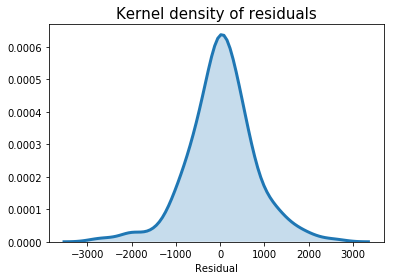

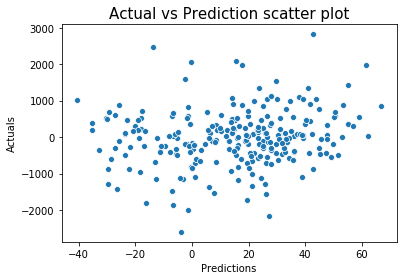

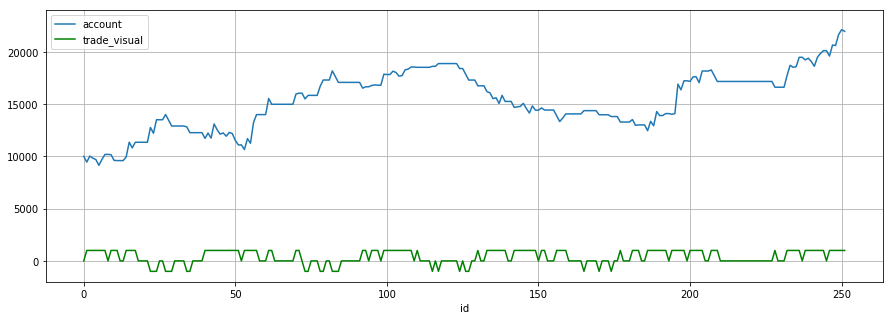

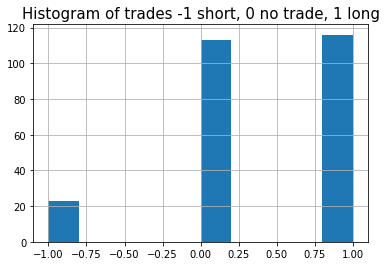

In [206]:
gold_account_nn = get_performance(gold_clf_reg_nn, gold_reg_pca, gold_gains.loc[gold_gains.index > validate_date], gold_reg_validate, gold_reg_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True, target=20)

In [207]:
X = pca_transform(corn_reg_train, corn_reg_pca)
y = corn_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(corn_reg_test, corn_reg_pca)
y_test = corn_reg_label_test
# remove outliers
X_test, y_test = remove_outliers(X_test, y_test, out_corn)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.corn_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=50, batch_size=50)
estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

Train on 1930 samples, validate on 483 samples
Epoch 1/1000
1930/1930 [==============================] - 4s 2ms/step - loss: 132259.1830 - val_loss: 131889.7950

Epoch 00001: val_loss improved from inf to 131889.79505, saving model to saved_models/weights.corn_reg.hdf5
Epoch 2/1000
1930/1930 [==============================] - 0s 196us/step - loss: 132250.5777 - val_loss: 131889.7763

Epoch 00002: val_loss improved from 131889.79505 to 131889.77635, saving model to saved_models/weights.corn_reg.hdf5
Epoch 3/1000
1930/1930 [==============================] - 0s 194us/step - loss: 132246.1645 - val_loss: 131889.4102

Epoch 00003: val_loss improved from 131889.77635 to 131889.41018, saving model to saved_models/weights.corn_reg.hdf5
Epoch 4/1000
1930/1930 [==============================] - 0s 187us/step - loss: 132236.7390 - val_loss: 131889.4358

Epoch 00004: val_loss did not improve from 131889.41018
Epoch 5/1000
1930/1930 [==============================] - 0s 192us/step - loss: 132238.17

1930/1930 [==============================] - 0s 211us/step - loss: 131117.0206 - val_loss: 131909.0603

Epoch 00044: val_loss did not improve from 131885.53335
Epoch 45/1000
1930/1930 [==============================] - 0s 197us/step - loss: 131042.7320 - val_loss: 131915.1718

Epoch 00045: val_loss did not improve from 131885.53335
Epoch 46/1000
1930/1930 [==============================] - 0s 255us/step - loss: 131009.5232 - val_loss: 131928.8720

Epoch 00046: val_loss did not improve from 131885.53335
Epoch 47/1000
1930/1930 [==============================] - 0s 226us/step - loss: 130909.3664 - val_loss: 131928.2700

Epoch 00047: val_loss did not improve from 131885.53335
Epoch 48/1000
1930/1930 [==============================] - 0s 234us/step - loss: 130829.7157 - val_loss: 131926.2669

Epoch 00048: val_loss did not improve from 131885.53335
Epoch 49/1000
1930/1930 [==============================] - 0s 179us/step - loss: 130753.1989 - val_loss: 131926.6324

Epoch 00049: val_loss did 

1930/1930 [==============================] - 0s 211us/step - loss: 127363.3658 - val_loss: 132099.8062

Epoch 00091: val_loss did not improve from 131885.53335
Epoch 92/1000
1930/1930 [==============================] - 0s 183us/step - loss: 127109.4092 - val_loss: 132135.5482

Epoch 00092: val_loss did not improve from 131885.53335
Epoch 93/1000
1930/1930 [==============================] - 0s 192us/step - loss: 127218.1288 - val_loss: 132147.4739

Epoch 00093: val_loss did not improve from 131885.53335
Epoch 94/1000
1930/1930 [==============================] - 0s 193us/step - loss: 127219.5343 - val_loss: 132139.6593

Epoch 00094: val_loss did not improve from 131885.53335
Epoch 95/1000
1930/1930 [==============================] - 0s 180us/step - loss: 127117.9473 - val_loss: 132140.1123

Epoch 00095: val_loss did not improve from 131885.53335
Epoch 96/1000
1930/1930 [==============================] - 0s 181us/step - loss: 127106.0482 - val_loss: 132159.0157

Epoch 00096: val_loss did 

1930/1930 [==============================] - 0s 202us/step - loss: 122753.8918 - val_loss: 132478.2156

Epoch 00138: val_loss did not improve from 131885.53335
Epoch 139/1000
1930/1930 [==============================] - 0s 187us/step - loss: 122873.1700 - val_loss: 132490.6582

Epoch 00139: val_loss did not improve from 131885.53335
Epoch 140/1000
1930/1930 [==============================] - 0s 187us/step - loss: 122062.3442 - val_loss: 132532.5527

Epoch 00140: val_loss did not improve from 131885.53335
Epoch 141/1000
1930/1930 [==============================] - 0s 202us/step - loss: 122305.9580 - val_loss: 132548.9478

Epoch 00141: val_loss did not improve from 131885.53335
Epoch 142/1000
1930/1930 [==============================] - 0s 182us/step - loss: 122544.7556 - val_loss: 132548.0201

Epoch 00142: val_loss did not improve from 131885.53335
Epoch 143/1000
1930/1930 [==============================] - 0s 197us/step - loss: 122192.6576 - val_loss: 132576.3312

Epoch 00143: val_loss

1930/1930 [==============================] - 0s 214us/step - loss: 117151.7437 - val_loss: 133198.7252

Epoch 00185: val_loss did not improve from 131885.53335
Epoch 186/1000
1930/1930 [==============================] - 0s 204us/step - loss: 116825.7870 - val_loss: 133174.4658

Epoch 00186: val_loss did not improve from 131885.53335
Epoch 187/1000
1930/1930 [==============================] - 0s 204us/step - loss: 117139.1371 - val_loss: 133205.2427

Epoch 00187: val_loss did not improve from 131885.53335
Epoch 188/1000
1930/1930 [==============================] - 0s 192us/step - loss: 117020.6709 - val_loss: 133261.6296

Epoch 00188: val_loss did not improve from 131885.53335
Epoch 189/1000
1930/1930 [==============================] - 0s 202us/step - loss: 116224.2388 - val_loss: 133317.9265

Epoch 00189: val_loss did not improve from 131885.53335
Epoch 190/1000
1930/1930 [==============================] - 0s 188us/step - loss: 116447.3809 - val_loss: 133378.6746

Epoch 00190: val_loss

1930/1930 [==============================] - 0s 180us/step - loss: 110724.0248 - val_loss: 134233.0798

Epoch 00232: val_loss did not improve from 131885.53335
Epoch 233/1000
1930/1930 [==============================] - 0s 180us/step - loss: 110720.7474 - val_loss: 134228.3419

Epoch 00233: val_loss did not improve from 131885.53335
Epoch 234/1000
1930/1930 [==============================] - 0s 182us/step - loss: 110313.6832 - val_loss: 134293.9612

Epoch 00234: val_loss did not improve from 131885.53335
Epoch 235/1000
1930/1930 [==============================] - 0s 174us/step - loss: 110084.6725 - val_loss: 134301.6046

Epoch 00235: val_loss did not improve from 131885.53335
Epoch 236/1000
1930/1930 [==============================] - 0s 174us/step - loss: 110376.9705 - val_loss: 134351.4150

Epoch 00236: val_loss did not improve from 131885.53335
Epoch 237/1000
1930/1930 [==============================] - 0s 184us/step - loss: 109952.0229 - val_loss: 134342.5861

Epoch 00237: val_loss

1930/1930 [==============================] - 0s 240us/step - loss: 103210.4785 - val_loss: 135426.7923

Epoch 00279: val_loss did not improve from 131885.53335
Epoch 280/1000
1930/1930 [==============================] - 0s 212us/step - loss: 104184.1909 - val_loss: 135469.3298

Epoch 00280: val_loss did not improve from 131885.53335
Epoch 281/1000
1930/1930 [==============================] - 1s 307us/step - loss: 103586.6176 - val_loss: 135575.5743

Epoch 00281: val_loss did not improve from 131885.53335
Epoch 282/1000
1930/1930 [==============================] - 0s 241us/step - loss: 103895.9183 - val_loss: 135659.0993

Epoch 00282: val_loss did not improve from 131885.53335
Epoch 283/1000
1930/1930 [==============================] - 0s 243us/step - loss: 103405.8808 - val_loss: 135652.0590

Epoch 00283: val_loss did not improve from 131885.53335
Epoch 284/1000
1930/1930 [==============================] - 0s 206us/step - loss: 103027.4313 - val_loss: 135678.0754

Epoch 00284: val_loss

1930/1930 [==============================] - 0s 200us/step - loss: 96854.3099 - val_loss: 137376.6544

Epoch 00326: val_loss did not improve from 131885.53335
Epoch 327/1000
1930/1930 [==============================] - 0s 196us/step - loss: 95983.2939 - val_loss: 137308.2678

Epoch 00327: val_loss did not improve from 131885.53335
Epoch 328/1000
1930/1930 [==============================] - 0s 190us/step - loss: 96108.9125 - val_loss: 137427.0156

Epoch 00328: val_loss did not improve from 131885.53335
Epoch 329/1000
1930/1930 [==============================] - 0s 203us/step - loss: 96212.0397 - val_loss: 137612.9762

Epoch 00329: val_loss did not improve from 131885.53335
Epoch 330/1000
1930/1930 [==============================] - 0s 187us/step - loss: 95980.3759 - val_loss: 137396.4903

Epoch 00330: val_loss did not improve from 131885.53335
Epoch 331/1000
1930/1930 [==============================] - 0s 183us/step - loss: 95061.0516 - val_loss: 137232.1375

Epoch 00331: val_loss did n

1930/1930 [==============================] - 0s 195us/step - loss: 88407.6081 - val_loss: 139383.3211

Epoch 00373: val_loss did not improve from 131885.53335
Epoch 374/1000
1930/1930 [==============================] - 0s 239us/step - loss: 88690.9282 - val_loss: 139460.9876

Epoch 00374: val_loss did not improve from 131885.53335
Epoch 375/1000
1930/1930 [==============================] - 0s 203us/step - loss: 88460.6969 - val_loss: 139564.8947

Epoch 00375: val_loss did not improve from 131885.53335
Epoch 376/1000
1930/1930 [==============================] - 0s 210us/step - loss: 87329.7330 - val_loss: 139697.9456

Epoch 00376: val_loss did not improve from 131885.53335
Epoch 377/1000
1930/1930 [==============================] - 0s 216us/step - loss: 87768.5006 - val_loss: 139698.1117

Epoch 00377: val_loss did not improve from 131885.53335
Epoch 378/1000
1930/1930 [==============================] - 0s 209us/step - loss: 87800.8530 - val_loss: 139613.0414

Epoch 00378: val_loss did n

1930/1930 [==============================] - 0s 189us/step - loss: 81720.1657 - val_loss: 141897.0355

Epoch 00420: val_loss did not improve from 131885.53335
Epoch 421/1000
1930/1930 [==============================] - 0s 174us/step - loss: 80745.2741 - val_loss: 141857.5339

Epoch 00421: val_loss did not improve from 131885.53335
Epoch 422/1000
1930/1930 [==============================] - 0s 192us/step - loss: 81016.4334 - val_loss: 142072.3522

Epoch 00422: val_loss did not improve from 131885.53335
Epoch 423/1000
1930/1930 [==============================] - 0s 173us/step - loss: 80640.4600 - val_loss: 142209.4940

Epoch 00423: val_loss did not improve from 131885.53335
Epoch 424/1000
1930/1930 [==============================] - 0s 171us/step - loss: 80482.3833 - val_loss: 142431.1145

Epoch 00424: val_loss did not improve from 131885.53335
Epoch 425/1000
1930/1930 [==============================] - 0s 177us/step - loss: 79819.1027 - val_loss: 142499.9064

Epoch 00425: val_loss did n

1930/1930 [==============================] - 0s 221us/step - loss: 73203.8897 - val_loss: 145599.6035

Epoch 00467: val_loss did not improve from 131885.53335
Epoch 468/1000
1930/1930 [==============================] - 0s 187us/step - loss: 73182.6410 - val_loss: 145948.5726

Epoch 00468: val_loss did not improve from 131885.53335
Epoch 469/1000
1930/1930 [==============================] - 0s 193us/step - loss: 71881.9395 - val_loss: 145926.3758

Epoch 00469: val_loss did not improve from 131885.53335
Epoch 470/1000
1930/1930 [==============================] - 0s 217us/step - loss: 71597.8506 - val_loss: 145861.9660

Epoch 00470: val_loss did not improve from 131885.53335
Epoch 471/1000
1930/1930 [==============================] - 0s 198us/step - loss: 72495.2375 - val_loss: 146012.3039

Epoch 00471: val_loss did not improve from 131885.53335
Epoch 472/1000
1930/1930 [==============================] - 0s 191us/step - loss: 72083.3590 - val_loss: 145824.4409

Epoch 00472: val_loss did n

1930/1930 [==============================] - 0s 196us/step - loss: 66415.8029 - val_loss: 149448.0671

Epoch 00514: val_loss did not improve from 131885.53335
Epoch 515/1000
1930/1930 [==============================] - 0s 181us/step - loss: 64799.4825 - val_loss: 149482.4440

Epoch 00515: val_loss did not improve from 131885.53335
Epoch 516/1000
1930/1930 [==============================] - 0s 182us/step - loss: 64241.1935 - val_loss: 149902.3246

Epoch 00516: val_loss did not improve from 131885.53335
Epoch 517/1000
1930/1930 [==============================] - 0s 180us/step - loss: 63962.4250 - val_loss: 149865.3930

Epoch 00517: val_loss did not improve from 131885.53335
Epoch 518/1000
1930/1930 [==============================] - 0s 177us/step - loss: 65909.8093 - val_loss: 149700.3558

Epoch 00518: val_loss did not improve from 131885.53335
Epoch 519/1000
1930/1930 [==============================] - 0s 181us/step - loss: 63960.9337 - val_loss: 149821.1138

Epoch 00519: val_loss did n

1930/1930 [==============================] - 0s 231us/step - loss: 58207.1638 - val_loss: 154026.5896

Epoch 00561: val_loss did not improve from 131885.53335
Epoch 562/1000
1930/1930 [==============================] - 0s 207us/step - loss: 58939.4044 - val_loss: 154439.8618

Epoch 00562: val_loss did not improve from 131885.53335
Epoch 563/1000
1930/1930 [==============================] - 0s 207us/step - loss: 57251.2444 - val_loss: 154407.9420

Epoch 00563: val_loss did not improve from 131885.53335
Epoch 564/1000
1930/1930 [==============================] - 0s 192us/step - loss: 57006.7915 - val_loss: 154930.1173

Epoch 00564: val_loss did not improve from 131885.53335
Epoch 565/1000
1930/1930 [==============================] - 0s 195us/step - loss: 56662.2639 - val_loss: 154777.2410

Epoch 00565: val_loss did not improve from 131885.53335
Epoch 566/1000
1930/1930 [==============================] - 0s 194us/step - loss: 57921.7105 - val_loss: 154799.9319

Epoch 00566: val_loss did n

1930/1930 [==============================] - 0s 213us/step - loss: 50366.4836 - val_loss: 160620.8133

Epoch 00608: val_loss did not improve from 131885.53335
Epoch 609/1000
1930/1930 [==============================] - 0s 191us/step - loss: 50564.0548 - val_loss: 160892.4943

Epoch 00609: val_loss did not improve from 131885.53335
Epoch 610/1000
1930/1930 [==============================] - 0s 190us/step - loss: 51623.2082 - val_loss: 161642.5182

Epoch 00610: val_loss did not improve from 131885.53335
Epoch 611/1000
1930/1930 [==============================] - 0s 194us/step - loss: 50133.5402 - val_loss: 161702.6998

Epoch 00611: val_loss did not improve from 131885.53335
Epoch 612/1000
1930/1930 [==============================] - 0s 197us/step - loss: 49829.7106 - val_loss: 161616.5502

Epoch 00612: val_loss did not improve from 131885.53335
Epoch 613/1000
1930/1930 [==============================] - 0s 200us/step - loss: 50181.4264 - val_loss: 161577.2274

Epoch 00613: val_loss did n

1930/1930 [==============================] - 0s 206us/step - loss: 43413.3880 - val_loss: 166732.8693

Epoch 00655: val_loss did not improve from 131885.53335
Epoch 656/1000
1930/1930 [==============================] - 0s 188us/step - loss: 42993.9184 - val_loss: 166895.7884

Epoch 00656: val_loss did not improve from 131885.53335
Epoch 657/1000
1930/1930 [==============================] - 0s 196us/step - loss: 43897.6399 - val_loss: 167329.4858

Epoch 00657: val_loss did not improve from 131885.53335
Epoch 658/1000
1930/1930 [==============================] - 0s 189us/step - loss: 45540.3118 - val_loss: 167970.3449

Epoch 00658: val_loss did not improve from 131885.53335
Epoch 659/1000
1930/1930 [==============================] - 0s 182us/step - loss: 45712.3036 - val_loss: 168014.0924

Epoch 00659: val_loss did not improve from 131885.53335
Epoch 660/1000
1930/1930 [==============================] - 0s 190us/step - loss: 43106.0047 - val_loss: 167994.9125

Epoch 00660: val_loss did n

1930/1930 [==============================] - 0s 201us/step - loss: 37733.9457 - val_loss: 174087.4375

Epoch 00702: val_loss did not improve from 131885.53335
Epoch 703/1000
1930/1930 [==============================] - 0s 207us/step - loss: 38443.0398 - val_loss: 173812.9622

Epoch 00703: val_loss did not improve from 131885.53335
Epoch 704/1000
1930/1930 [==============================] - 0s 202us/step - loss: 37677.0651 - val_loss: 174280.7600

Epoch 00704: val_loss did not improve from 131885.53335
Epoch 705/1000
1930/1930 [==============================] - 0s 222us/step - loss: 39060.3165 - val_loss: 174823.3838

Epoch 00705: val_loss did not improve from 131885.53335
Epoch 706/1000
1930/1930 [==============================] - 0s 187us/step - loss: 38526.7454 - val_loss: 175101.4649

Epoch 00706: val_loss did not improve from 131885.53335
Epoch 707/1000
1930/1930 [==============================] - 0s 189us/step - loss: 39292.7736 - val_loss: 174612.3571

Epoch 00707: val_loss did n

1930/1930 [==============================] - 0s 191us/step - loss: 36431.9748 - val_loss: 181799.6212

Epoch 00749: val_loss did not improve from 131885.53335
Epoch 750/1000
1930/1930 [==============================] - 0s 181us/step - loss: 36344.4417 - val_loss: 181035.6883

Epoch 00750: val_loss did not improve from 131885.53335
Epoch 751/1000
1930/1930 [==============================] - 0s 190us/step - loss: 35630.3377 - val_loss: 181462.8894

Epoch 00751: val_loss did not improve from 131885.53335
Epoch 752/1000
1930/1930 [==============================] - 0s 179us/step - loss: 33019.8432 - val_loss: 181650.7491

Epoch 00752: val_loss did not improve from 131885.53335
Epoch 753/1000
1930/1930 [==============================] - 0s 187us/step - loss: 34452.9264 - val_loss: 181002.5362

Epoch 00753: val_loss did not improve from 131885.53335
Epoch 754/1000
1930/1930 [==============================] - 0s 187us/step - loss: 34516.8762 - val_loss: 181800.0959

Epoch 00754: val_loss did n

1930/1930 [==============================] - 0s 195us/step - loss: 30532.9871 - val_loss: 191474.8542

Epoch 00796: val_loss did not improve from 131885.53335
Epoch 797/1000
1930/1930 [==============================] - 0s 180us/step - loss: 30637.3641 - val_loss: 190144.9452

Epoch 00797: val_loss did not improve from 131885.53335
Epoch 798/1000
1930/1930 [==============================] - 0s 182us/step - loss: 30498.0561 - val_loss: 191084.1878

Epoch 00798: val_loss did not improve from 131885.53335
Epoch 799/1000
1930/1930 [==============================] - 0s 183us/step - loss: 30215.4682 - val_loss: 192359.1842

Epoch 00799: val_loss did not improve from 131885.53335
Epoch 800/1000
1930/1930 [==============================] - 0s 179us/step - loss: 32376.9063 - val_loss: 192662.5682

Epoch 00800: val_loss did not improve from 131885.53335
Epoch 801/1000
1930/1930 [==============================] - 0s 173us/step - loss: 30488.1557 - val_loss: 192661.1503

Epoch 00801: val_loss did n

1930/1930 [==============================] - 0s 211us/step - loss: 29128.1961 - val_loss: 198848.7043

Epoch 00843: val_loss did not improve from 131885.53335
Epoch 844/1000
1930/1930 [==============================] - 0s 184us/step - loss: 26543.4422 - val_loss: 198577.2138

Epoch 00844: val_loss did not improve from 131885.53335
Epoch 845/1000
1930/1930 [==============================] - 0s 188us/step - loss: 28663.0759 - val_loss: 198740.7482

Epoch 00845: val_loss did not improve from 131885.53335
Epoch 846/1000
1930/1930 [==============================] - 0s 183us/step - loss: 27037.1258 - val_loss: 198447.9500

Epoch 00846: val_loss did not improve from 131885.53335
Epoch 847/1000
1930/1930 [==============================] - 0s 196us/step - loss: 27400.4308 - val_loss: 199099.1611

Epoch 00847: val_loss did not improve from 131885.53335
Epoch 848/1000
1930/1930 [==============================] - 0s 199us/step - loss: 27738.4821 - val_loss: 198290.9611

Epoch 00848: val_loss did n

1930/1930 [==============================] - 0s 214us/step - loss: 26273.0560 - val_loss: 204789.3395

Epoch 00890: val_loss did not improve from 131885.53335
Epoch 891/1000
1930/1930 [==============================] - 0s 176us/step - loss: 27133.3447 - val_loss: 205567.1718

Epoch 00891: val_loss did not improve from 131885.53335
Epoch 892/1000
1930/1930 [==============================] - 0s 205us/step - loss: 25397.7331 - val_loss: 203990.5180

Epoch 00892: val_loss did not improve from 131885.53335
Epoch 893/1000
1930/1930 [==============================] - 0s 181us/step - loss: 23446.1723 - val_loss: 203716.3352

Epoch 00893: val_loss did not improve from 131885.53335
Epoch 894/1000
1930/1930 [==============================] - 0s 180us/step - loss: 26362.8455 - val_loss: 204822.7071

Epoch 00894: val_loss did not improve from 131885.53335
Epoch 895/1000
1930/1930 [==============================] - 0s 202us/step - loss: 24515.9175 - val_loss: 205039.6401

Epoch 00895: val_loss did n

1930/1930 [==============================] - 0s 200us/step - loss: 23676.8479 - val_loss: 211859.7331

Epoch 00937: val_loss did not improve from 131885.53335
Epoch 938/1000
1930/1930 [==============================] - 0s 187us/step - loss: 23732.8310 - val_loss: 211764.9582

Epoch 00938: val_loss did not improve from 131885.53335
Epoch 939/1000
1930/1930 [==============================] - 0s 179us/step - loss: 22380.5203 - val_loss: 211421.4984

Epoch 00939: val_loss did not improve from 131885.53335
Epoch 940/1000
1930/1930 [==============================] - 0s 175us/step - loss: 25118.7981 - val_loss: 211710.3717

Epoch 00940: val_loss did not improve from 131885.53335
Epoch 941/1000
1930/1930 [==============================] - 0s 201us/step - loss: 24406.5815 - val_loss: 210695.8564

Epoch 00941: val_loss did not improve from 131885.53335
Epoch 942/1000
1930/1930 [==============================] - 0s 185us/step - loss: 25669.6700 - val_loss: 211289.9334

Epoch 00942: val_loss did n

1930/1930 [==============================] - 0s 205us/step - loss: 21169.5770 - val_loss: 217237.8604

Epoch 00984: val_loss did not improve from 131885.53335
Epoch 985/1000
1930/1930 [==============================] - 0s 200us/step - loss: 23677.6216 - val_loss: 215407.6721

Epoch 00985: val_loss did not improve from 131885.53335
Epoch 986/1000
1930/1930 [==============================] - 0s 195us/step - loss: 24031.4918 - val_loss: 215918.9260

Epoch 00986: val_loss did not improve from 131885.53335
Epoch 987/1000
1930/1930 [==============================] - 0s 201us/step - loss: 22358.0316 - val_loss: 215742.8863

Epoch 00987: val_loss did not improve from 131885.53335
Epoch 988/1000
1930/1930 [==============================] - 0s 209us/step - loss: 24675.6946 - val_loss: 215954.2759

Epoch 00988: val_loss did not improve from 131885.53335
Epoch 989/1000
1930/1930 [==============================] - 0s 194us/step - loss: 23001.6829 - val_loss: 218339.2408

Epoch 00989: val_loss did n

In [208]:
model = regressor_model()
model.load_weights('saved_models/weights.corn_reg.hdf5')
corn_clf_reg_nn = model

Predictions/Actual volatility correlation:  -0.06002869070861335
Returns  -26.77 %
Number of trades:  58
Number of short trades:  16
Number of long trades:  42
Earnings per trade:  -46.16
Earnings per short trade:  -46.31
Earnings per long trade:  -46.10


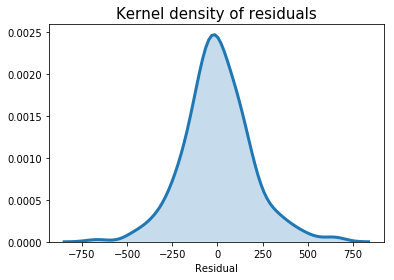

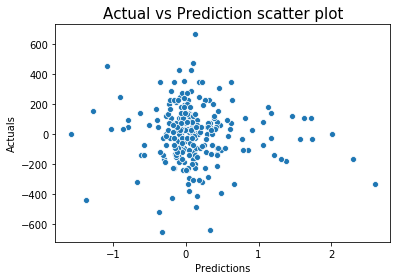

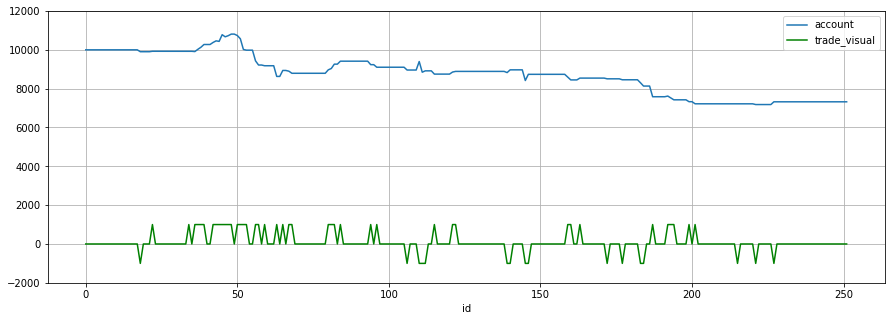

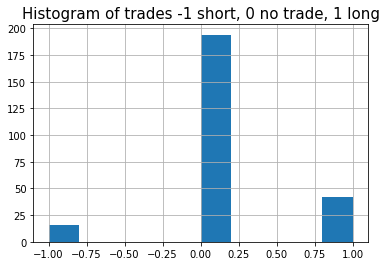

In [213]:
corn_account_nn = get_performance(corn_clf_reg_nn, corn_reg_pca, corn_gains.loc[corn_gains.index > validate_date], corn_reg_validate, corn_reg_label_validate, stop_loss_long=300, stop_loss_short=300, regression=True, target=0.4)

In [210]:
X = pca_transform(coffee_reg_train, coffee_reg_pca)
y = coffee_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(coffee_reg_test, coffee_reg_pca)
y_test = coffee_reg_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_corn)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.coffee_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=epochs, batch_size=batch_size)
estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

Train on 1922 samples, validate on 481 samples
Epoch 1/1000
1922/1922 [==============================] - 5s 3ms/step - loss: 133701.3460 - val_loss: 121253.4489

Epoch 00001: val_loss improved from inf to 121253.44891, saving model to saved_models/weights.coffee_reg.hdf5
Epoch 2/1000
1922/1922 [==============================] - 0s 200us/step - loss: 133691.2212 - val_loss: 121254.2493

Epoch 00002: val_loss did not improve from 121253.44891
Epoch 3/1000
1922/1922 [==============================] - 0s 217us/step - loss: 133700.1214 - val_loss: 121255.3854

Epoch 00003: val_loss did not improve from 121253.44891
Epoch 4/1000
1922/1922 [==============================] - 0s 188us/step - loss: 133693.3199 - val_loss: 121255.7772

Epoch 00004: val_loss did not improve from 121253.44891
Epoch 5/1000
1922/1922 [==============================] - 0s 210us/step - loss: 133694.5663 - val_loss: 121256.0951

Epoch 00005: val_loss did not improve from 121253.44891
Epoch 6/1000
1922/1922 [============


Epoch 00047: val_loss did not improve from 121253.44891
Epoch 48/1000
1922/1922 [==============================] - 0s 203us/step - loss: 133030.7647 - val_loss: 121420.9127

Epoch 00048: val_loss did not improve from 121253.44891
Epoch 49/1000
1922/1922 [==============================] - 0s 197us/step - loss: 133046.6233 - val_loss: 121431.1320

Epoch 00049: val_loss did not improve from 121253.44891
Epoch 50/1000
1922/1922 [==============================] - 0s 247us/step - loss: 132973.9653 - val_loss: 121438.1243

Epoch 00050: val_loss did not improve from 121253.44891
Epoch 51/1000
1922/1922 [==============================] - 0s 259us/step - loss: 132910.4718 - val_loss: 121448.0725

Epoch 00051: val_loss did not improve from 121253.44891
Epoch 52/1000
1922/1922 [==============================] - 0s 220us/step - loss: 132919.6521 - val_loss: 121461.2013

Epoch 00052: val_loss did not improve from 121253.44891
Epoch 53/1000
1922/1922 [==============================] - 0s 210us/step 

1922/1922 [==============================] - 0s 250us/step - loss: 131161.9037 - val_loss: 121650.6113

Epoch 00095: val_loss did not improve from 121253.44891
Epoch 96/1000
1922/1922 [==============================] - 0s 260us/step - loss: 131080.8940 - val_loss: 121659.5436

Epoch 00096: val_loss did not improve from 121253.44891
Epoch 97/1000
1922/1922 [==============================] - 0s 255us/step - loss: 130849.3977 - val_loss: 121661.0632

Epoch 00097: val_loss did not improve from 121253.44891
Epoch 98/1000
1922/1922 [==============================] - 0s 247us/step - loss: 130827.2276 - val_loss: 121657.6606

Epoch 00098: val_loss did not improve from 121253.44891
Epoch 99/1000
1922/1922 [==============================] - 0s 247us/step - loss: 130787.7849 - val_loss: 121668.8494

Epoch 00099: val_loss did not improve from 121253.44891
Epoch 100/1000
1922/1922 [==============================] - 0s 243us/step - loss: 130756.7166 - val_loss: 121670.0364

Epoch 00100: val_loss did

1922/1922 [==============================] - 0s 208us/step - loss: 127567.2945 - val_loss: 121996.8031

Epoch 00142: val_loss did not improve from 121253.44891
Epoch 143/1000
1922/1922 [==============================] - 0s 190us/step - loss: 127276.3349 - val_loss: 122022.6040

Epoch 00143: val_loss did not improve from 121253.44891
Epoch 144/1000
1922/1922 [==============================] - 0s 196us/step - loss: 127077.6191 - val_loss: 122004.7763

Epoch 00144: val_loss did not improve from 121253.44891
Epoch 145/1000
1922/1922 [==============================] - 0s 189us/step - loss: 127435.4762 - val_loss: 122002.2590

Epoch 00145: val_loss did not improve from 121253.44891
Epoch 146/1000
1922/1922 [==============================] - 0s 191us/step - loss: 127218.0039 - val_loss: 121971.8420

Epoch 00146: val_loss did not improve from 121253.44891
Epoch 147/1000
1922/1922 [==============================] - 0s 192us/step - loss: 127237.1848 - val_loss: 121973.3077

Epoch 00147: val_loss

1922/1922 [==============================] - 0s 200us/step - loss: 123144.9126 - val_loss: 122321.0468

Epoch 00189: val_loss did not improve from 121253.44891
Epoch 190/1000
1922/1922 [==============================] - 0s 176us/step - loss: 122719.9336 - val_loss: 122377.8668

Epoch 00190: val_loss did not improve from 121253.44891
Epoch 191/1000
1922/1922 [==============================] - 0s 182us/step - loss: 122591.1647 - val_loss: 122382.0172

Epoch 00191: val_loss did not improve from 121253.44891
Epoch 192/1000
1922/1922 [==============================] - 0s 184us/step - loss: 122307.9762 - val_loss: 122341.5572

Epoch 00192: val_loss did not improve from 121253.44891
Epoch 193/1000
1922/1922 [==============================] - 0s 237us/step - loss: 122291.5254 - val_loss: 122350.6211

Epoch 00193: val_loss did not improve from 121253.44891
Epoch 194/1000
1922/1922 [==============================] - 0s 185us/step - loss: 122361.2954 - val_loss: 122337.3452

Epoch 00194: val_loss

1922/1922 [==============================] - 0s 181us/step - loss: 117463.0105 - val_loss: 122741.8361

Epoch 00236: val_loss did not improve from 121253.44891
Epoch 237/1000
1922/1922 [==============================] - 0s 191us/step - loss: 117256.5752 - val_loss: 122793.7087

Epoch 00237: val_loss did not improve from 121253.44891
Epoch 238/1000
1922/1922 [==============================] - 0s 193us/step - loss: 116541.9265 - val_loss: 122862.3762

Epoch 00238: val_loss did not improve from 121253.44891
Epoch 239/1000
1922/1922 [==============================] - 0s 184us/step - loss: 117019.5640 - val_loss: 122885.3427

Epoch 00239: val_loss did not improve from 121253.44891
Epoch 240/1000
1922/1922 [==============================] - 0s 183us/step - loss: 117223.1990 - val_loss: 122899.4503

Epoch 00240: val_loss did not improve from 121253.44891
Epoch 241/1000
1922/1922 [==============================] - 0s 181us/step - loss: 116083.2462 - val_loss: 122874.6810

Epoch 00241: val_loss

1922/1922 [==============================] - 0s 194us/step - loss: 110992.2866 - val_loss: 123646.4407

Epoch 00283: val_loss did not improve from 121253.44891
Epoch 284/1000
1922/1922 [==============================] - 0s 182us/step - loss: 110478.8962 - val_loss: 123628.5529

Epoch 00284: val_loss did not improve from 121253.44891
Epoch 285/1000
1922/1922 [==============================] - 0s 184us/step - loss: 110707.4001 - val_loss: 123711.1607

Epoch 00285: val_loss did not improve from 121253.44891
Epoch 286/1000
1922/1922 [==============================] - 0s 205us/step - loss: 110307.1596 - val_loss: 123765.8335

Epoch 00286: val_loss did not improve from 121253.44891
Epoch 287/1000
1922/1922 [==============================] - 0s 205us/step - loss: 110177.2662 - val_loss: 123762.2285

Epoch 00287: val_loss did not improve from 121253.44891
Epoch 288/1000
1922/1922 [==============================] - 0s 199us/step - loss: 110560.0908 - val_loss: 123815.0285

Epoch 00288: val_loss

1922/1922 [==============================] - 0s 184us/step - loss: 104558.5341 - val_loss: 124881.6877

Epoch 00330: val_loss did not improve from 121253.44891
Epoch 331/1000
1922/1922 [==============================] - 0s 182us/step - loss: 104393.1945 - val_loss: 124956.6113

Epoch 00331: val_loss did not improve from 121253.44891
Epoch 332/1000
1922/1922 [==============================] - 0s 182us/step - loss: 103862.0031 - val_loss: 125029.3388

Epoch 00332: val_loss did not improve from 121253.44891
Epoch 333/1000
1922/1922 [==============================] - 0s 190us/step - loss: 103590.0744 - val_loss: 124934.8687

Epoch 00333: val_loss did not improve from 121253.44891
Epoch 334/1000
1922/1922 [==============================] - 0s 204us/step - loss: 102940.7246 - val_loss: 124955.6835

Epoch 00334: val_loss did not improve from 121253.44891
Epoch 335/1000
1922/1922 [==============================] - 0s 201us/step - loss: 103955.3660 - val_loss: 124978.3593

Epoch 00335: val_loss

1922/1922 [==============================] - 0s 208us/step - loss: 97502.5921 - val_loss: 126118.0092

Epoch 00377: val_loss did not improve from 121253.44891
Epoch 378/1000
1922/1922 [==============================] - 0s 206us/step - loss: 97853.4802 - val_loss: 126151.4591

Epoch 00378: val_loss did not improve from 121253.44891
Epoch 379/1000
1922/1922 [==============================] - 0s 207us/step - loss: 95819.6219 - val_loss: 126247.9099

Epoch 00379: val_loss did not improve from 121253.44891
Epoch 380/1000
1922/1922 [==============================] - 0s 199us/step - loss: 96714.8395 - val_loss: 126257.3106

Epoch 00380: val_loss did not improve from 121253.44891
Epoch 381/1000
1922/1922 [==============================] - 0s 198us/step - loss: 95928.9095 - val_loss: 126264.1857

Epoch 00381: val_loss did not improve from 121253.44891
Epoch 382/1000
1922/1922 [==============================] - 0s 204us/step - loss: 96282.7550 - val_loss: 126342.1710

Epoch 00382: val_loss did n

1922/1922 [==============================] - 0s 183us/step - loss: 89681.7336 - val_loss: 127735.8718

Epoch 00424: val_loss did not improve from 121253.44891
Epoch 425/1000
1922/1922 [==============================] - 0s 177us/step - loss: 90150.1510 - val_loss: 128050.3118

Epoch 00425: val_loss did not improve from 121253.44891
Epoch 426/1000
1922/1922 [==============================] - 0s 184us/step - loss: 89921.2103 - val_loss: 128026.9674

Epoch 00426: val_loss did not improve from 121253.44891
Epoch 427/1000
1922/1922 [==============================] - 0s 180us/step - loss: 90670.2145 - val_loss: 128329.8365

Epoch 00427: val_loss did not improve from 121253.44891
Epoch 428/1000
1922/1922 [==============================] - 0s 181us/step - loss: 88774.7953 - val_loss: 128172.4284

Epoch 00428: val_loss did not improve from 121253.44891
Epoch 429/1000
1922/1922 [==============================] - 0s 178us/step - loss: 89109.9291 - val_loss: 128096.0916

Epoch 00429: val_loss did n

1922/1922 [==============================] - 0s 179us/step - loss: 83378.9769 - val_loss: 130313.1455

Epoch 00471: val_loss did not improve from 121253.44891
Epoch 472/1000
1922/1922 [==============================] - 0s 186us/step - loss: 81398.6958 - val_loss: 130577.5918

Epoch 00472: val_loss did not improve from 121253.44891
Epoch 473/1000
1922/1922 [==============================] - 0s 182us/step - loss: 81821.7413 - val_loss: 130974.5393

Epoch 00473: val_loss did not improve from 121253.44891
Epoch 474/1000
1922/1922 [==============================] - 0s 182us/step - loss: 82864.1290 - val_loss: 130959.7862

Epoch 00474: val_loss did not improve from 121253.44891
Epoch 475/1000
1922/1922 [==============================] - 0s 189us/step - loss: 82067.6306 - val_loss: 130741.0810

Epoch 00475: val_loss did not improve from 121253.44891
Epoch 476/1000
1922/1922 [==============================] - 0s 192us/step - loss: 80829.2808 - val_loss: 131159.5016

Epoch 00476: val_loss did n

1922/1922 [==============================] - 0s 191us/step - loss: 76326.1947 - val_loss: 133001.2692

Epoch 00518: val_loss did not improve from 121253.44891
Epoch 519/1000
1922/1922 [==============================] - 0s 184us/step - loss: 75420.5809 - val_loss: 133087.6205

Epoch 00519: val_loss did not improve from 121253.44891
Epoch 520/1000
1922/1922 [==============================] - 0s 181us/step - loss: 74413.1978 - val_loss: 132838.7673

Epoch 00520: val_loss did not improve from 121253.44891
Epoch 521/1000
1922/1922 [==============================] - 0s 186us/step - loss: 74182.1082 - val_loss: 133041.7057

Epoch 00521: val_loss did not improve from 121253.44891
Epoch 522/1000
1922/1922 [==============================] - 0s 185us/step - loss: 74440.7047 - val_loss: 133350.9171

Epoch 00522: val_loss did not improve from 121253.44891
Epoch 523/1000
1922/1922 [==============================] - 0s 182us/step - loss: 72250.5133 - val_loss: 133877.4030

Epoch 00523: val_loss did n

1922/1922 [==============================] - 0s 186us/step - loss: 68961.2530 - val_loss: 135594.7098

Epoch 00565: val_loss did not improve from 121253.44891
Epoch 566/1000
1922/1922 [==============================] - 0s 183us/step - loss: 67612.1710 - val_loss: 135288.7754

Epoch 00566: val_loss did not improve from 121253.44891
Epoch 567/1000
1922/1922 [==============================] - 0s 183us/step - loss: 70213.1430 - val_loss: 136123.7692

Epoch 00567: val_loss did not improve from 121253.44891
Epoch 568/1000
1922/1922 [==============================] - 0s 189us/step - loss: 67657.3523 - val_loss: 135958.9849

Epoch 00568: val_loss did not improve from 121253.44891
Epoch 569/1000
1922/1922 [==============================] - 0s 180us/step - loss: 66292.8170 - val_loss: 135935.6343

Epoch 00569: val_loss did not improve from 121253.44891
Epoch 570/1000
1922/1922 [==============================] - 0s 190us/step - loss: 65749.2954 - val_loss: 135977.6550

Epoch 00570: val_loss did n

1922/1922 [==============================] - 0s 190us/step - loss: 61535.7559 - val_loss: 139753.2962

Epoch 00612: val_loss did not improve from 121253.44891
Epoch 613/1000
1922/1922 [==============================] - 0s 179us/step - loss: 61855.9562 - val_loss: 139954.6023

Epoch 00613: val_loss did not improve from 121253.44891
Epoch 614/1000
1922/1922 [==============================] - 0s 188us/step - loss: 60469.9325 - val_loss: 140237.4848

Epoch 00614: val_loss did not improve from 121253.44891
Epoch 615/1000
1922/1922 [==============================] - 0s 192us/step - loss: 59949.9599 - val_loss: 140191.7027

Epoch 00615: val_loss did not improve from 121253.44891
Epoch 616/1000
1922/1922 [==============================] - 0s 175us/step - loss: 60604.0386 - val_loss: 140875.4227

Epoch 00616: val_loss did not improve from 121253.44891
Epoch 617/1000
1922/1922 [==============================] - 0s 178us/step - loss: 61756.7915 - val_loss: 140361.8691

Epoch 00617: val_loss did n

1922/1922 [==============================] - 0s 191us/step - loss: 54579.7943 - val_loss: 142694.6943

Epoch 00659: val_loss did not improve from 121253.44891
Epoch 660/1000
1922/1922 [==============================] - 0s 193us/step - loss: 54518.0527 - val_loss: 143963.2124

Epoch 00660: val_loss did not improve from 121253.44891
Epoch 661/1000
1922/1922 [==============================] - 0s 204us/step - loss: 53314.8089 - val_loss: 144017.8527

Epoch 00661: val_loss did not improve from 121253.44891
Epoch 662/1000
1922/1922 [==============================] - 0s 213us/step - loss: 54690.6199 - val_loss: 143587.4044

Epoch 00662: val_loss did not improve from 121253.44891
Epoch 663/1000
1922/1922 [==============================] - 0s 209us/step - loss: 53251.6981 - val_loss: 143386.7777

Epoch 00663: val_loss did not improve from 121253.44891
Epoch 664/1000
1922/1922 [==============================] - 0s 219us/step - loss: 55273.1520 - val_loss: 143940.3941

Epoch 00664: val_loss did n

1922/1922 [==============================] - 0s 186us/step - loss: 49369.2840 - val_loss: 149925.2532

Epoch 00706: val_loss did not improve from 121253.44891
Epoch 707/1000
1922/1922 [==============================] - 0s 189us/step - loss: 47980.8023 - val_loss: 149163.9892

Epoch 00707: val_loss did not improve from 121253.44891
Epoch 708/1000
1922/1922 [==============================] - 0s 183us/step - loss: 49638.1841 - val_loss: 149280.7697

Epoch 00708: val_loss did not improve from 121253.44891
Epoch 709/1000
1922/1922 [==============================] - 0s 198us/step - loss: 49932.7824 - val_loss: 149880.5741

Epoch 00709: val_loss did not improve from 121253.44891
Epoch 710/1000
1922/1922 [==============================] - 0s 197us/step - loss: 49026.4530 - val_loss: 150363.5596

Epoch 00710: val_loss did not improve from 121253.44891
Epoch 711/1000
1922/1922 [==============================] - 0s 192us/step - loss: 49692.3299 - val_loss: 150271.0887

Epoch 00711: val_loss did n

1922/1922 [==============================] - 0s 191us/step - loss: 42951.2276 - val_loss: 154232.1586

Epoch 00753: val_loss did not improve from 121253.44891
Epoch 754/1000
1922/1922 [==============================] - 0s 181us/step - loss: 43577.3646 - val_loss: 155395.8940

Epoch 00754: val_loss did not improve from 121253.44891
Epoch 755/1000
1922/1922 [==============================] - 0s 194us/step - loss: 41389.3757 - val_loss: 155133.7033

Epoch 00755: val_loss did not improve from 121253.44891
Epoch 756/1000
1922/1922 [==============================] - 0s 188us/step - loss: 42807.7749 - val_loss: 155560.2764

Epoch 00756: val_loss did not improve from 121253.44891
Epoch 757/1000
1922/1922 [==============================] - 0s 186us/step - loss: 42897.1609 - val_loss: 154830.6706

Epoch 00757: val_loss did not improve from 121253.44891
Epoch 758/1000
1922/1922 [==============================] - 0s 187us/step - loss: 41232.9166 - val_loss: 155421.8456

Epoch 00758: val_loss did n

1922/1922 [==============================] - 0s 197us/step - loss: 41105.4298 - val_loss: 157975.8721

Epoch 00800: val_loss did not improve from 121253.44891
Epoch 801/1000
1922/1922 [==============================] - 0s 200us/step - loss: 39553.1653 - val_loss: 158897.3527

Epoch 00801: val_loss did not improve from 121253.44891
Epoch 802/1000
1922/1922 [==============================] - 0s 198us/step - loss: 39842.2021 - val_loss: 159533.3235

Epoch 00802: val_loss did not improve from 121253.44891
Epoch 803/1000
1922/1922 [==============================] - 0s 190us/step - loss: 39141.7476 - val_loss: 159214.3408

Epoch 00803: val_loss did not improve from 121253.44891
Epoch 804/1000
1922/1922 [==============================] - 0s 184us/step - loss: 38612.1277 - val_loss: 159910.0307

Epoch 00804: val_loss did not improve from 121253.44891
Epoch 805/1000
1922/1922 [==============================] - 0s 186us/step - loss: 38879.5314 - val_loss: 159795.0131

Epoch 00805: val_loss did n

1922/1922 [==============================] - 0s 193us/step - loss: 36077.6734 - val_loss: 166126.7488

Epoch 00847: val_loss did not improve from 121253.44891
Epoch 848/1000
1922/1922 [==============================] - 0s 199us/step - loss: 37044.9876 - val_loss: 165615.8070

Epoch 00848: val_loss did not improve from 121253.44891
Epoch 849/1000
1922/1922 [==============================] - 0s 191us/step - loss: 37765.7351 - val_loss: 165193.0882

Epoch 00849: val_loss did not improve from 121253.44891
Epoch 850/1000
1922/1922 [==============================] - 0s 201us/step - loss: 38298.9278 - val_loss: 165530.4011

Epoch 00850: val_loss did not improve from 121253.44891
Epoch 851/1000
1922/1922 [==============================] - 0s 192us/step - loss: 36102.4572 - val_loss: 165494.7368

Epoch 00851: val_loss did not improve from 121253.44891
Epoch 852/1000
1922/1922 [==============================] - 0s 177us/step - loss: 36091.9846 - val_loss: 164504.5502

Epoch 00852: val_loss did n

1922/1922 [==============================] - 0s 192us/step - loss: 35179.7205 - val_loss: 171194.9376

Epoch 00894: val_loss did not improve from 121253.44891
Epoch 895/1000
1922/1922 [==============================] - 0s 191us/step - loss: 33771.8411 - val_loss: 170872.0878

Epoch 00895: val_loss did not improve from 121253.44891
Epoch 896/1000
1922/1922 [==============================] - 0s 188us/step - loss: 35123.2832 - val_loss: 170851.6421

Epoch 00896: val_loss did not improve from 121253.44891
Epoch 897/1000
1922/1922 [==============================] - 0s 180us/step - loss: 35308.0798 - val_loss: 172409.6071

Epoch 00897: val_loss did not improve from 121253.44891
Epoch 898/1000
1922/1922 [==============================] - 0s 181us/step - loss: 36471.9827 - val_loss: 173325.9366

Epoch 00898: val_loss did not improve from 121253.44891
Epoch 899/1000
1922/1922 [==============================] - 0s 198us/step - loss: 32334.2256 - val_loss: 173076.8124

Epoch 00899: val_loss did n

1922/1922 [==============================] - 0s 186us/step - loss: 32385.2077 - val_loss: 176956.0772

Epoch 00941: val_loss did not improve from 121253.44891
Epoch 942/1000
1922/1922 [==============================] - 0s 193us/step - loss: 30600.5798 - val_loss: 177420.6961

Epoch 00942: val_loss did not improve from 121253.44891
Epoch 943/1000
1922/1922 [==============================] - 0s 185us/step - loss: 31509.9832 - val_loss: 177579.0781

Epoch 00943: val_loss did not improve from 121253.44891
Epoch 944/1000
1922/1922 [==============================] - 0s 195us/step - loss: 31289.2699 - val_loss: 176797.3697

Epoch 00944: val_loss did not improve from 121253.44891
Epoch 945/1000
1922/1922 [==============================] - 0s 184us/step - loss: 30903.8533 - val_loss: 176332.6224

Epoch 00945: val_loss did not improve from 121253.44891
Epoch 946/1000
1922/1922 [==============================] - 0s 180us/step - loss: 30811.6092 - val_loss: 175494.0703

Epoch 00946: val_loss did n

1922/1922 [==============================] - 0s 201us/step - loss: 30867.5981 - val_loss: 180606.2024

Epoch 00988: val_loss did not improve from 121253.44891
Epoch 989/1000
1922/1922 [==============================] - 0s 217us/step - loss: 29363.4028 - val_loss: 179802.3209

Epoch 00989: val_loss did not improve from 121253.44891
Epoch 990/1000
1922/1922 [==============================] - 0s 200us/step - loss: 29698.2743 - val_loss: 179387.7628

Epoch 00990: val_loss did not improve from 121253.44891
Epoch 991/1000
1922/1922 [==============================] - 0s 197us/step - loss: 32066.3867 - val_loss: 180082.1648

Epoch 00991: val_loss did not improve from 121253.44891
Epoch 992/1000
1922/1922 [==============================] - 0s 189us/step - loss: 30874.1040 - val_loss: 180100.2058

Epoch 00992: val_loss did not improve from 121253.44891
Epoch 993/1000
1922/1922 [==============================] - 0s 200us/step - loss: 29464.1843 - val_loss: 180294.0489

Epoch 00993: val_loss did n

In [211]:
model = regressor_model()
model.load_weights('saved_models/weights.coffee_reg.hdf5')
coffee_clf_reg_nn = model

Predictions/Actual volatility correlation:  -0.03583001182883609
Returns  0.00 %
Number of trades:  0
Number of short trades:  0
Number of long trades:  0
Earnings per trade:  0.00
Earnings per short trade:  0.00
Earnings per long trade:  0.00


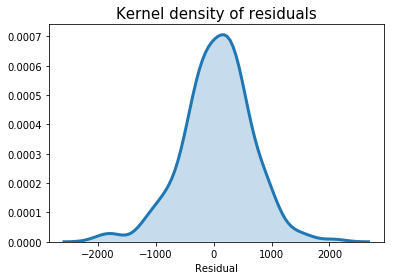

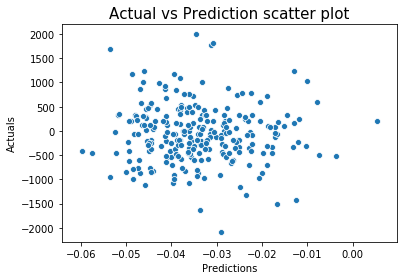

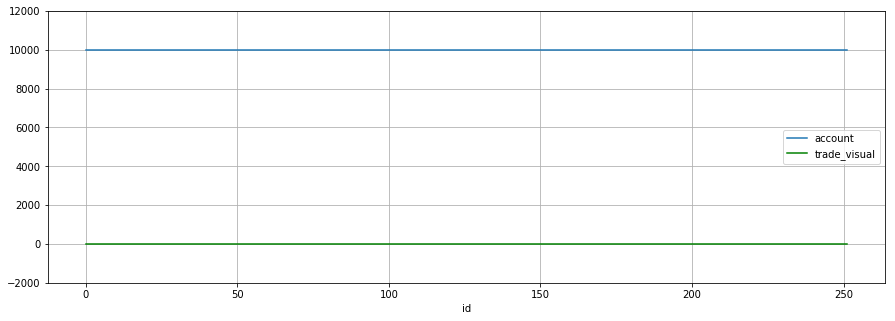

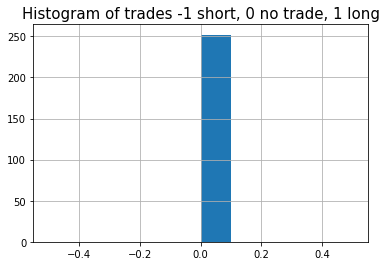

In [212]:
coffee_account_nn = get_performance(coffee_clf_reg_nn, coffee_reg_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_reg_validate, coffee_reg_label_validate, stop_loss_long=1000, stop_loss_short=1000, regression=True, target=0.1)

# Conclusions
Only Gold regressor has data that returns positive results. Correlation between actual gold price and predictions is more than 0.16

Corn and Coffee has rather random correlation with actual performance (also training is not going well).
Last weights update for keras neural network regressor (1000 epochs):

| Gold | Corn | Coffee |
|------|------|--------|
| 512  |   32 | 1      |

I am surprised that I cannot achieve better results with corn. Since corn retained most information by pca transformation. I expected to have best training results with corn.

# H2O automl experiment

In [214]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/h2o/backend/connection.py:317: UserWarning: Proxy is defined in the environment: HTTP_PROXY. This may interfere with your H2O Connection.
  "This may interfere with your H2O Connection." % name)
/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/h2o/backend/connection.py:317: UserWarning: Proxy is defined in the environment: http_proxy. This may interfere with your H2O Connection.
  "This may interfere with your H2O Connection." % name)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.1" 2018-10-16; OpenJDK Runtime Environment (build 11.0.1+13-Ubuntu-3ubuntu3.18.10.1); OpenJDK 64-Bit Server VM (build 11.0.1+13-Ubuntu-3ubuntu3.18.10.1, mixed mode, sharing)
  Starting server from /home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpvxwkbliw
  JVM stdout: /tmp/tmpvxwkbliw/h2o_martin_started_from_python.out
  JVM stderr: /tmp/tmpvxwkbliw/h2o_martin_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Bratislava
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.2
H2O cluster version age:,18 days
H2O cluster name:,H2O_from_python_martin_vfywy5
H2O cluster total nodes:,1
H2O cluster free memory:,2.389 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


### Classification
Based on the H2O documentation only 2 categories are supported for automl. This model was generated for long trades.

In [215]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_long_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_long_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_long_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
validation[y] = validation[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
-331248,-27640.9,567537,65888,59525.3,252952,55627.9,-128754,107664,-216797,-88334.8,-158876,-132532,109755,-46152.6,-48243.4,102096,-26623.6,30557,96471.9,128856,-45498.6,7400.27,-52095.7,-102416,11413.4,193359,43174.8,2397.14,102818,51492,86161.9,36587.2,-431.163,-59398.9,-16408.3,-31970.8,7392.44,-41167.5,-38087.9,-79022.2,39880,74855.5,59099.8,-57810.6,4571.96,6865.5,69375.7,-24542.1,-2964.83,38010.9,50722.6,-49494,84525.8,-50325.3,1617.01,9757.53,40051,13361,28889.2,64254.2,-927.344,-13659.5,-973.585,57239.3,-14635.2,51039.1,-37447.1,71646.4,12300.9,7308.94,2995.98,66098,-25603.1,118375,-14342.2,23159.5,-106860,-30568.6,66324.5,-28319.3,-19414.8,74039.7,20878.1,-57363.5,-37656.5,15939.3,19836.3,52715.5,35991,40769.2,-14441.3,69806.5,36537.7,-44491.1,-57462,39878.1,25845.4,-8552.88,-6417.83,5903.48,-26696.2,6223.8,25249.4,16073.9,-3946.47,14822.4,-45238.9,-22718.6,-5387.21,63061.7,-21204.8,46718.1,-10246.8,-17679.4,82309.2,10278.2,33819.8,14791.7,-10318.9,38208.1,36031.4,-22415.4,-22948.7,9237.39,-46271.5,-16025.7,-32045.3,11528.7,-14694,-52873.6,65658.5,78371.1,-3786.76,15688.5,-13926,-47534.8,39424.6,-27202.7,-29934.4,-18343.1,20998.2,9208.38,-16001.3,43712.7,-4050.55,-25511,16382.3,-60760.7,3977.03,-19944.2,64013.7,-39727.3,-37917,-13036.8,52607.2,48494.9,38249.9,-88103.1,-40157.5,-36073.4,9875.56,42455.1,42717.8,-17228.2,-902.95,-28762.9,-41110.7,18957.3,-28820.2,15033.3,-17562.3,-8803.51,23882.9,37622.3,-16041.9,26617.1,15831.3,-1452.96,-24442.8,-13424.9,-17986.4,-54551.6,100337,-12982.5,-20857.6,-49309.7,-29425.2,9438.39,-31290.8,20001,74281.2,38789.7,34382.4,-2799.05,-39896.4,32486.2,74129.7,-38974.9,33943.5
-325632,-21861.3,570463,61896.1,12385.8,263138,67919.9,-122209,98093.1,-221691,-106287,-152934,-113510,123914,-42969.4,-38251.7,83308.7,-40120.2,40592,115483,118716,-59971.5,15404.1,-53785.8,-114764,16018.2,177401,-17123,17396.5,124792,34830.4,80182.2,61158.6,-37570.1,-29884.3,-1243.13,-41191.5,25931.6,198.042,-70567.6,2435.07,24739,104129,15369.9,-67739.2,-63275.3,41865.1,42055.7,458.742,-15286.7,3486.52,45515.7,-82916.5,55935.8,-75649.4,-26103.3,2369.58,42338.8,8161.88,64239.1,56469.8,14761.5,-45009.8,17551.6,24207.2,21459,97579.9,16854,104355,-10585.3,-15991.3,-10664.7,79435.3,1332.76,94045.8,-13272.3,40374.8,-26720.8,-46435.1,69752,-29560.7,-20420.7,15062.6,-49836.2,-69314.5,-75523.9,30552.3,30807.6,78707.6,20325.7,73373.8,-9184.14,23539.3,49531.5,-8248.75,-20231,7103.48,21536.8,-42549,12079.5,-10135.3,-38184.1,21524,40226.9,13054.8,38784.9,-46167.2,-17813.3,-19602,-25986.1,7817.18,-32128.9,-23314.1,-50007.2,-49561.8,26797.7,24791.3,78396.3,19204.7,21994.7,-62312.4,-39373.4,38829.6,10357.8,-792.608,163.776,17432.4,-69134,-45877.9,-39993.2,-11836,24834.9,29452.1,55929.8,39657.4,43875.6,31612.3,76769.7,14581.8,15596.5,36543.6,-14573.6,-387.628,23286.4,-29384.7,-7514.05,-19781.8,20652.3,2781.08,-13415.9,23300.7,46168.7,-48293.3,37659.9,68456.3,35566.7,-16892.2,-7713.68,7171.18,-13490.9,21885.4,29476.2,-18953.5,-19306.2,52039.9,-14114.8,-110200,-44815.4,-31763.5,15814.1,-13441.6,23622.1,30740.1,5327.42,45627.3,16424.6,34625.1,-8653.75,-18554,63492.4,28164.3,5081.91,1326.42,-41837,-30386,3184.34,-34923.6,-38657.6,-41088.3,-20688.8,-18062.2,5762.19,-46274.8,-456.058,-35580.8,-13500,-2665.41,15078.1,-39647.8,4789.56
-322972,-16385.8,56900


AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GLM_grid_1_AutoML_20190206_105910_model_1,0.479587,0.607513,0.49148,0.456493,0.208386
XRT_1_AutoML_20190206_105910,0.477046,0.69162,0.5,0.476521,0.227073
StackedEnsemble_BestOfFamily_AutoML_20190206_105910,0.476126,0.60746,0.5,0.456459,0.208355
StackedEnsemble_AllModels_AutoML_20190206_105910,0.476126,0.60746,0.5,0.456459,0.208355
DRF_1_AutoML_20190206_105910,0.472127,0.650638,0.494616,0.474203,0.224868


glm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f019f2de208>]],
      dtype=object)

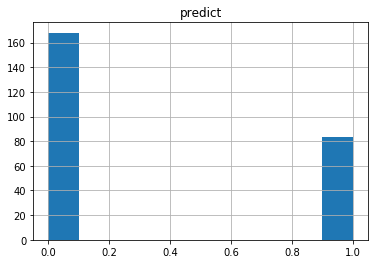

In [216]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

Returns  64.20 %
Number of trades:  83
Number of short trades:  0
Number of long trades:  83
Earnings per trade:  77.36
Earnings per short trade:  0.00
Earnings per long trade:  77.36


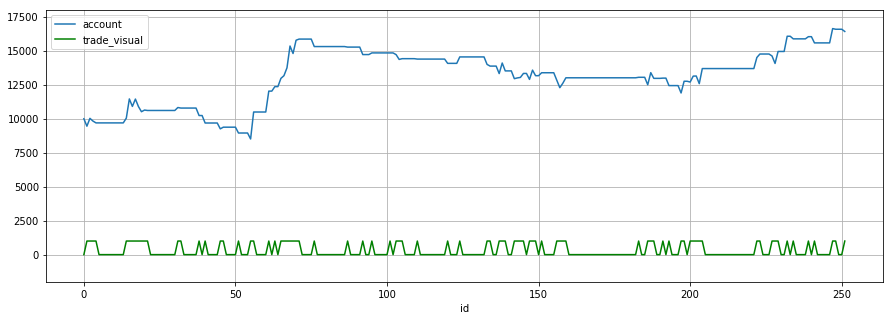

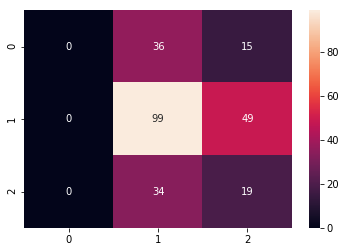

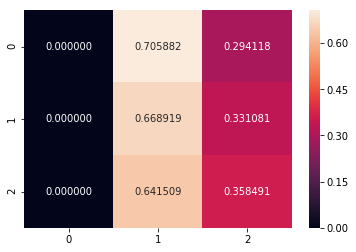

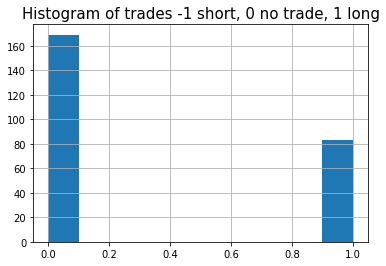

In [245]:
gold_account = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800)

### H2O automl gold regressor

In [258]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_reg_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_reg_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_reg_test.csv", header=1)

# Identify predictors and response
print(train.head())
x = train.columns
y = "label"
x.remove(y)

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=40, max_runtime_secs=600, seed=1234, stopping_metric='deviance')
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
-331248,-27640.9,567537,65888,59525.3,252952,55627.9,-128754,107664,-216797,-88334.8,-158876,-132532,109755,-46152.6,-48243.4,102096,-26623.6,30557,96471.9,128856,-45498.6,7400.27,-52095.7,-102416,11413.4,193359,43174.8,2397.14,102818,51492,86161.9,36587.2,-431.163,-59398.9,-16408.3,-31970.8,7392.44,-41167.5,-38087.9,-79022.2,39880,74855.5,59099.8,-57810.6,4571.96,6865.5,69375.7,-24542.1,-2964.83,38010.9,50722.6,-49494,84525.8,-50325.3,1617.01,9757.53,40051,13361,28889.2,64254.2,-927.344,-13659.5,-973.585,57239.3,-14635.2,51039.1,-37447.1,71646.4,12300.9,7308.94,2995.98,66098,-25603.1,118375,-14342.2,23159.5,-106860,-30568.6,66324.5,-28319.3,-19414.8,74039.7,20878.1,-57363.5,-37656.5,15939.3,19836.3,52715.5,35991,40769.2,-14441.3,69806.5,36537.7,-44491.1,-57462,39878.1,25845.4,-8552.88,-6417.83,5903.48,-26696.2,6223.8,25249.4,16073.9,-3946.47,14822.4,-45238.9,-22718.6,-5387.21,63061.7,-21204.8,46718.1,-10246.8,-17679.4,82309.2,10278.2,33819.8,14791.7,-10318.9,38208.1,36031.4,-22415.4,-22948.7,9237.39,-46271.5,-16025.7,-32045.3,11528.7,-14694,-52873.6,65658.5,78371.1,-3786.76,15688.5,-13926,-47534.8,39424.6,-27202.7,-29934.4,-18343.1,20998.2,9208.38,-16001.3,43712.7,-4050.55,-25511,16382.3,-60760.7,3977.03,-19944.2,64013.7,-39727.3,-37917,-13036.8,52607.2,48494.9,38249.9,-88103.1,-40157.5,-36073.4,9875.56,42455.1,42717.8,-17228.2,-902.95,-28762.9,-41110.7,18957.3,-28820.2,15033.3,-17562.3,-8803.51,23882.9,37622.3,-16041.9,26617.1,15831.3,-1452.96,-24442.8,-13424.9,-17986.4,-54551.6,100337,-12982.5,-20857.6,-49309.7,-29425.2,9438.39,-31290.8,20001,74281.2,38789.7,34382.4,-2799.05,-39896.4,32486.2,74129.7,-38974.9,33943.5
-325632,-21861.3,570463,61896.1,12385.8,263138,67919.9,-122209,98093.1,-221691,-106287,-152934,-113510,123914,-42969.4,-38251.7,83308.7,-40120.2,40592,115483,118716,-59971.5,15404.1,-53785.8,-114764,16018.2,177401,-17123,17396.5,124792,34830.4,80182.2,61158.6,-37570.1,-29884.3,-1243.13,-41191.5,25931.6,198.042,-70567.6,2435.07,24739,104129,15369.9,-67739.2,-63275.3,41865.1,42055.7,458.742,-15286.7,3486.52,45515.7,-82916.5,55935.8,-75649.4,-26103.3,2369.58,42338.8,8161.88,64239.1,56469.8,14761.5,-45009.8,17551.6,24207.2,21459,97579.9,16854,104355,-10585.3,-15991.3,-10664.7,79435.3,1332.76,94045.8,-13272.3,40374.8,-26720.8,-46435.1,69752,-29560.7,-20420.7,15062.6,-49836.2,-69314.5,-75523.9,30552.3,30807.6,78707.6,20325.7,73373.8,-9184.14,23539.3,49531.5,-8248.75,-20231,7103.48,21536.8,-42549,12079.5,-10135.3,-38184.1,21524,40226.9,13054.8,38784.9,-46167.2,-17813.3,-19602,-25986.1,7817.18,-32128.9,-23314.1,-50007.2,-49561.8,26797.7,24791.3,78396.3,19204.7,21994.7,-62312.4,-39373.4,38829.6,10357.8,-792.608,163.776,17432.4,-69134,-45877.9,-39993.2,-11836,24834.9,29452.1,55929.8,39657.4,43875.6,31612.3,76769.7,14581.8,15596.5,36543.6,-14573.6,-387.628,23286.4,-29384.7,-7514.05,-19781.8,20652.3,2781.08,-13415.9,23300.7,46168.7,-48293.3,37659.9,68456.3,35566.7,-16892.2,-7713.68,7171.18,-13490.9,21885.4,29476.2,-18953.5,-19306.2,52039.9,-14114.8,-110200,-44815.4,-31763.5,15814.1,-13441.6,23622.1,30740.1,5327.42,45627.3,16424.6,34625.1,-8653.75,-18554,63492.4,28164.3,5081.91,1326.42,-41837,-30386,3184.34,-34923.6,-38657.6,-41088.3,-20688.8,-18062.2,5762.19,-46274.8,-456.058,-35580.8,-13500,-2665.41,15078.1,-39647.8,4789.56
-322972,-16385.8,56900


AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GLM_grid_1_AutoML_20190206_141936_model_1,1.68431e+06,1297.81,1.68431e+06,895.899,nan
GBM_grid_1_AutoML_20190206_141936_model_9,1.68454e+06,1297.9,1.68454e+06,895.996,nan
StackedEnsemble_BestOfFamily_AutoML_20190206_141936,1.68533e+06,1298.2,1.68533e+06,896.418,nan
StackedEnsemble_AllModels_AutoML_20190206_141936,1.68533e+06,1298.2,1.68533e+06,896.418,nan
GBM_grid_1_AutoML_20190206_141936_model_7,1.6926e+06,1301,1.6926e+06,898.466,nan
GBM_grid_1_AutoML_20190206_141936_model_6,1.69501e+06,1301.93,1.69501e+06,899.696,nan
GBM_grid_1_AutoML_20190206_141936_model_5,1.6984e+06,1303.23,1.6984e+06,898.45,nan
GBM_grid_1_AutoML_20190206_141936_model_1,1.72597e+06,1313.76,1.72597e+06,910.145,nan
GBM_grid_1_AutoML_20190206_141936_model_4,1.73897e+06,1318.7,1.73897e+06,911.332,nan
GBM_5_AutoML_20190206_141936,1.74291e+06,1320.19,1.74291e+06,920.143,nan


glm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f024217f9b0>]],
      dtype=object)

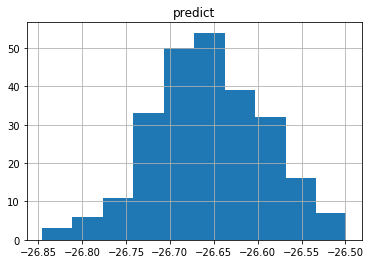

In [259]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

In [260]:
b

array([-26.64229968, -26.71641999, -26.708649  , -26.71515188,
       -26.63658053, -26.64446274, -26.64020086, -26.71253869,
       -26.66806547, -26.6756639 , -26.65211953, -26.64890615,
       -26.65344326, -26.61857664, -26.56154821, -26.57349536,
       -26.59273975, -26.64060133, -26.63128295, -26.66378233,
       -26.69216267, -26.72992689, -26.71783875, -26.6885868 ,
       -26.61967933, -26.58579422, -26.63610436, -26.69308651,
       -26.7082924 , -26.64246799, -26.54135393, -26.54918815,
       -26.64174458, -26.72843558, -26.78074026, -26.69889125,
       -26.73783544, -26.65964022, -26.65177147, -26.68606529,
       -26.67097812, -26.69366353, -26.6849714 , -26.6581517 ,
       -26.5768978 , -26.57849511, -26.66287907, -26.70672685,
       -26.70472282, -26.69631531, -26.64723116, -26.68017371,
       -26.64785677, -26.59564131, -26.63087327, -26.58388114,
       -26.62635637, -26.76022761, -26.7412088 , -26.68790975,
       -26.69833714, -26.70706475, -26.68660787, -26.66

In [262]:
def trade(x, treshold):
    ans = 0
    if abs(x) > treshold:
        if x > 0:
            ans = 1
        else:
            ans = -1
    return 0



preds = list(map(lambda x: trade(x, 200), b))

In [263]:
print(preds)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Returns  0.00 %
Number of trades:  251
Number of short trades:  0
Number of long trades:  0
Earnings per trade:  0.00
Earnings per short trade:  0.00
Earnings per long trade:  0.00


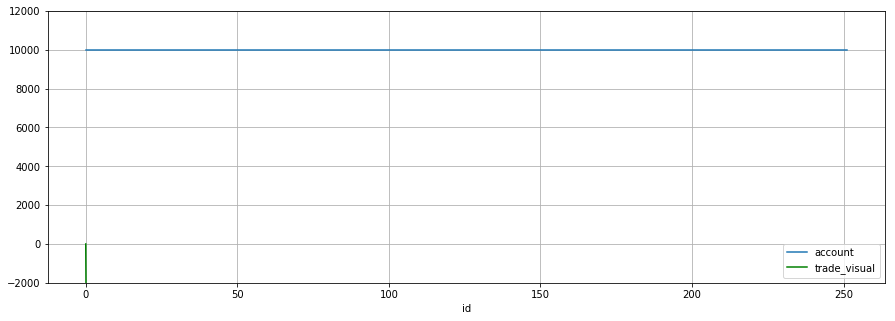

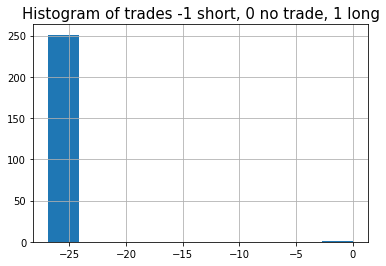

In [264]:
gold_account_reg = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True)

### H2O short trade

In [268]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_short_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_short_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_short_test.csv", header=1)

# Identify predictors and response
# model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
# aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1234)
aml = H2OAutoML(max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_4_AutoML_20190206_143654,0.519649,0.652706,0.498539,0.472855,0.223592
GBM_grid_1_AutoML_20190206_143654_model_7,0.517231,0.749949,0.5,0.498757,0.248758
GBM_1_AutoML_20190206_143654,0.514903,0.63345,0.499635,0.467266,0.218337
DRF_1_AutoML_20190206_143654,0.514799,0.644456,0.49188,0.470246,0.221131
GBM_grid_1_AutoML_20190206_143654_model_6,0.510856,0.603947,0.5,0.454695,0.206748
GBM_grid_1_AutoML_20190206_143654_model_9,0.508572,0.950786,0.495041,0.523258,0.273799
GBM_5_AutoML_20190206_143654,0.507968,0.616868,0.496502,0.460257,0.211836
GBM_grid_1_AutoML_20190206_143654_model_5,0.50742,0.604007,0.494704,0.454722,0.206772
DeepLearning_grid_1_AutoML_20190206_143654_model_1,0.504488,1.99432,0.5,0.587026,0.344599
GBM_3_AutoML_20190206_143654,0.503352,0.648492,0.495926,0.472189,0.222962


deeplearning prediction progress: |███████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f019da3e0b8>]],
      dtype=object)

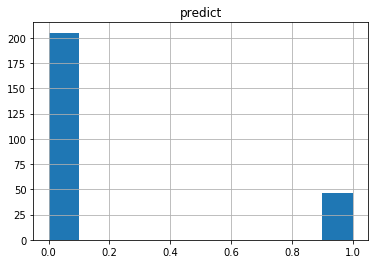

In [272]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = list(map(lambda x: -1 if x > 0 else 0, a.predict.values))
a.hist()

Returns  55.33 %
Number of trades:  46
Number of short trades:  46
Number of long trades:  0
Earnings per trade:  120.28
Earnings per short trade:  120.28
Earnings per long trade:  0.00


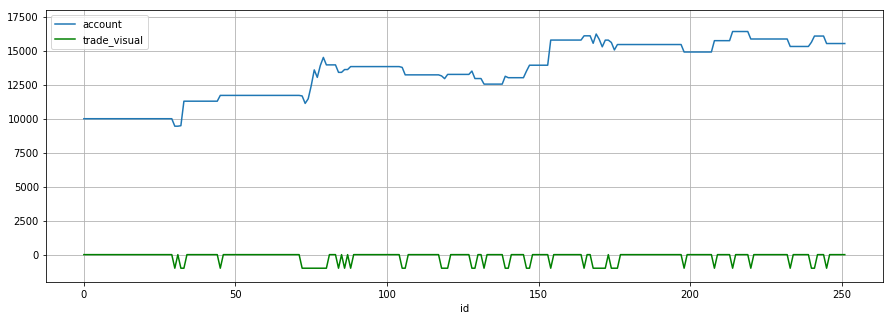

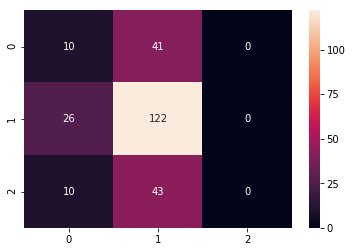

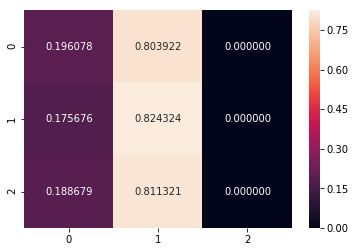

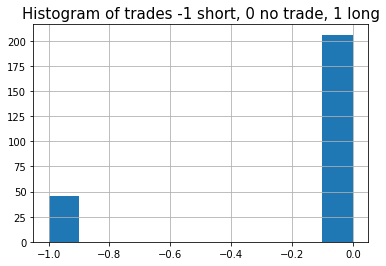

In [273]:
gold_account = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800)

In [271]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/corn_pca_short_train.csv", header=1)
validation = h2o.import_file("data/corn_pca_short_validation.csv", header=1)
test = h2o.import_file("data/corn_pca_short_test.csv", header=1)

# Identify predictors and response
# model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
DeepLearning_grid_1_AutoML_20190206_144702_model_1,0.543327,1.68694,0.470287,0.553125,0.305947
GBM_grid_1_AutoML_20190206_144702_model_3,0.542602,0.598815,0.473194,0.452171,0.204458
GBM_5_AutoML_20190206_144702,0.533986,0.608311,0.498179,0.456043,0.207975
GBM_grid_1_AutoML_20190206_144702_model_5,0.533266,0.599328,0.459379,0.452441,0.204703
DeepLearning_grid_1_AutoML_20190206_144702_model_2,0.533252,1.19789,0.474727,0.539521,0.291083
GBM_1_AutoML_20190206_144702,0.530715,0.622389,0.487948,0.461382,0.212874
DRF_1_AutoML_20190206_144702,0.528342,0.660491,0.5,0.464089,0.215378
DeepLearning_grid_1_AutoML_20190206_144702_model_3,0.526542,0.922937,0.491005,0.522084,0.272572
GBM_4_AutoML_20190206_144702,0.52617,0.641655,0.499272,0.465791,0.216961
GBM_3_AutoML_20190206_144702,0.525998,0.635475,0.499636,0.464675,0.215923


gbm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f019d96b080>]],
      dtype=object)

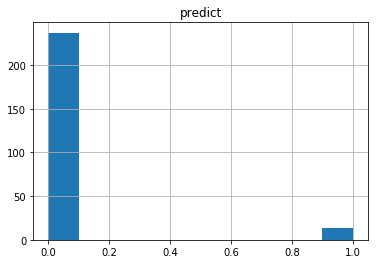

In [275]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.map(lambda x: -1 if x > 0 else 0).values
a.hist()

Returns  -2.01 %
Number of trades:  14
Number of short trades:  14
Number of long trades:  0
Earnings per trade:  -14.38
Earnings per short trade:  -14.38
Earnings per long trade:  0.00


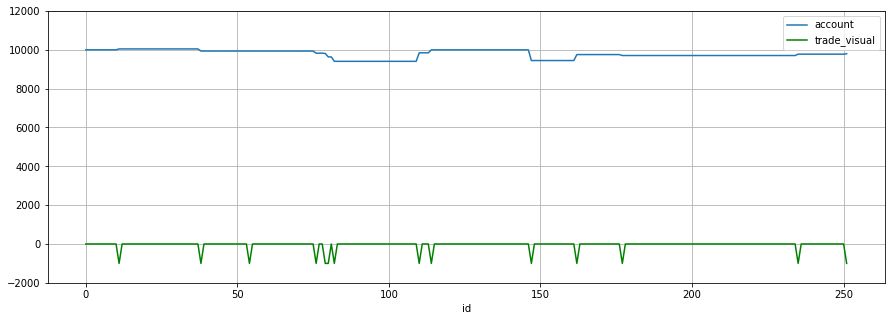

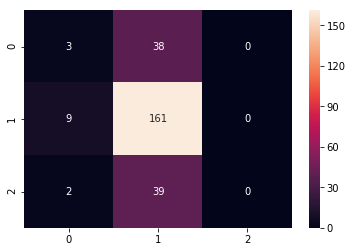

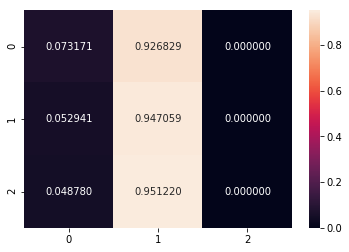

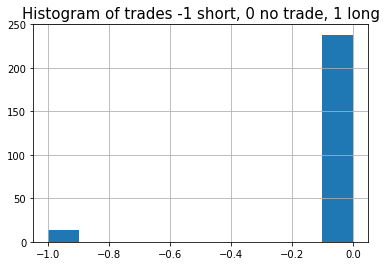

In [276]:
corn_account = get_account(b, corn_gains.loc[corn_gains.index > validate_date], corn_label_validate, stop_loss_long=300, stop_loss_short=300)

In [274]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/corn_pca_long_train.csv", header=1)
validation = h2o.import_file("data/corn_pca_long_validation.csv", header=1)
test = h2o.import_file("data/corn_pca_long_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_1_AutoML_20190206_153221,0.545483,0.631149,0.486863,0.466671,0.217782
StackedEnsemble_BestOfFamily_AutoML_20190206_153221,0.540689,0.613244,0.481929,0.459616,0.211247
GBM_4_AutoML_20190206_153221,0.53766,0.651727,0.498509,0.47314,0.223861
GBM_5_AutoML_20190206_153221,0.532961,0.623489,0.499627,0.464026,0.21532
StackedEnsemble_AllModels_AutoML_20190206_153221,0.530353,0.614125,0.485388,0.46001,0.211609
GBM_grid_1_AutoML_20190206_153221_model_5,0.528271,0.61419,0.473213,0.460061,0.211656
GBM_grid_1_AutoML_20190206_153221_model_3,0.525618,0.614071,0.475957,0.459999,0.211599
GBM_grid_1_AutoML_20190206_153221_model_1,0.523735,0.614736,0.499254,0.460275,0.211853
XRT_1_AutoML_20190206_153221,0.521799,0.642431,0.495296,0.47096,0.221803
GBM_3_AutoML_20190206_153221,0.518723,0.646368,0.480335,0.472626,0.223375


gbm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f019db85898>]],
      dtype=object)

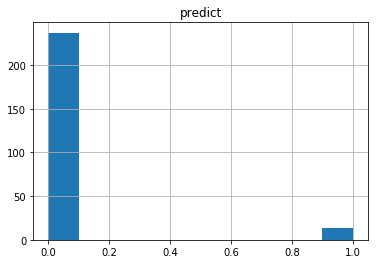

In [277]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

Returns  -10.61 %
Number of trades:  14
Number of short trades:  0
Number of long trades:  14
Earnings per trade:  -75.78
Earnings per short trade:  0.00
Earnings per long trade:  -75.78


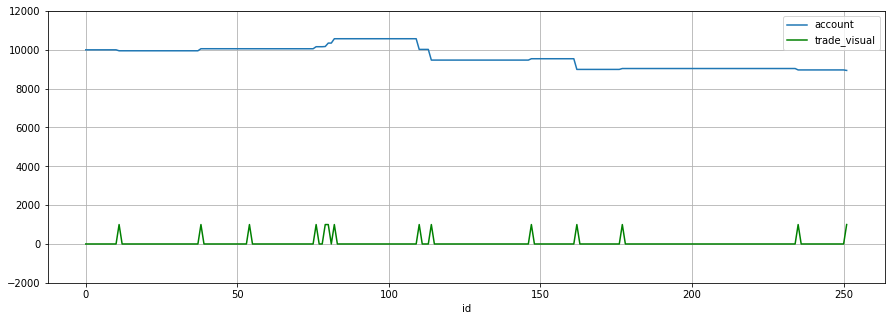

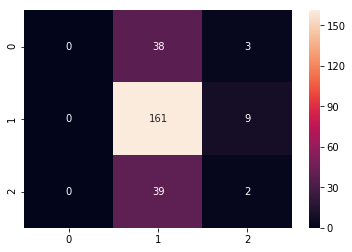

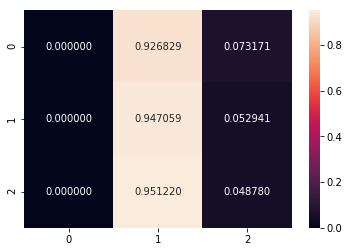

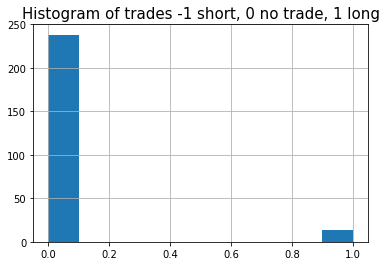

In [278]:
corn_account = get_account(b, corn_gains.loc[corn_gains.index > validate_date], corn_label_validate, stop_loss_long=300, stop_loss_short=300)

In [280]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/coffee_pca_long_train.csv", header=1)
validation = h2o.import_file("data/coffee_pca_long_validation.csv", header=1)
test = h2o.import_file("data/coffee_pca_long_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
DeepLearning_grid_1_AutoML_20190206_154250_model_1,0.546312,1.67939,0.5,0.599151,0.358982
GLM_grid_1_AutoML_20190206_154250_model_1,0.527217,0.658517,0.5,0.482574,0.232877
GBM_5_AutoML_20190206_154250,0.519542,0.668057,0.493053,0.486933,0.237104
DeepLearning_grid_1_AutoML_20190206_154250_model_3,0.518888,0.768196,0.5,0.518282,0.268616
GBM_1_AutoML_20190206_154250,0.518702,0.686336,0.5,0.49393,0.243967
DeepLearning_grid_1_AutoML_20190206_154250_model_2,0.515933,1.07564,0.5,0.564106,0.318216
GBM_4_AutoML_20190206_154250,0.514719,0.703042,0.499587,0.500172,0.250172
GBM_2_AutoML_20190206_154250,0.510637,0.691967,0.499053,0.496575,0.246587
GBM_grid_1_AutoML_20190206_154250_model_2,0.509639,1.26803,0.491646,0.576808,0.332708
DeepLearning_1_AutoML_20190206_154250,0.505536,0.798137,0.497815,0.525787,0.276452


deeplearning prediction progress: |███████████████████████████████████████| 100%
Returns  10.53 %
Number of trades:  61
Number of short trades:  0
Number of long trades:  61
Earnings per trade:  17.27
Earnings per short trade:  0.00
Earnings per long trade:  17.27


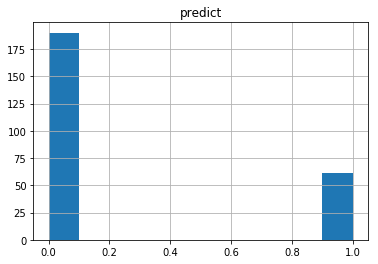

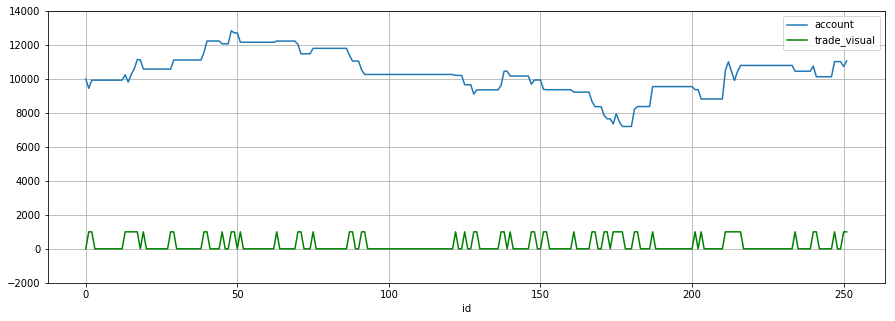

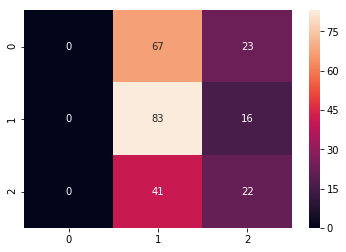

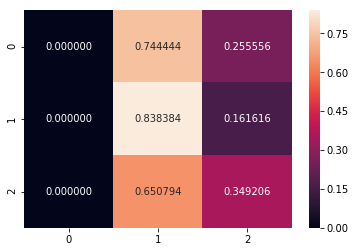

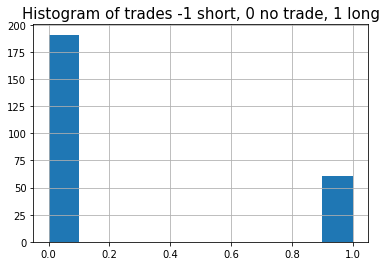

In [281]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

coffee_account = get_account(b, coffee_gains.loc[coffee_gains.index > validate_date], coffee_label_validate, stop_loss_long=800, stop_loss_short=800)

In [282]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/coffee_pca_short_train.csv", header=1)
validation = h2o.import_file("data/coffee_pca_long_validation.csv", header=1)
test = h2o.import_file("data/coffee_pca_short_test.csv", header=1)

# Identify predictors and response
# model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
DeepLearning_grid_1_AutoML_20190206_155230_model_1,0.513351,1.90511,0.5,0.615571,0.378928
DeepLearning_grid_1_AutoML_20190206_155230_model_2,0.512589,1.19957,0.5,0.57938,0.335681
GBM_2_AutoML_20190206_155230,0.511064,0.698649,0.497471,0.500544,0.250544
GBM_4_AutoML_20190206_155230,0.506362,0.716539,0.5,0.506089,0.256126
GBM_3_AutoML_20190206_155230,0.502403,0.706331,0.5,0.502838,0.252846
DeepLearning_grid_1_AutoML_20190206_155230_model_3,0.499069,1.12472,0.495441,0.577226,0.333189
GLM_grid_1_AutoML_20190206_155230_model_1,0.498935,0.666653,0.498733,0.486688,0.236866
XRT_1_AutoML_20190206_155230,0.498353,0.7057,0.498987,0.503283,0.253294
GBM_grid_1_AutoML_20190206_155230_model_2,0.497287,1.33192,0.5,0.5906,0.348809
StackedEnsemble_AllModels_AutoML_20190206_155230,0.497095,0.666139,0.5,0.486434,0.236618


deeplearning prediction progress: |███████████████████████████████████████| 100%
Returns  204.45 %
Number of trades:  251
Number of short trades:  251
Number of long trades:  0
Earnings per trade:  81.45
Earnings per short trade:  81.45
Earnings per long trade:  0.00


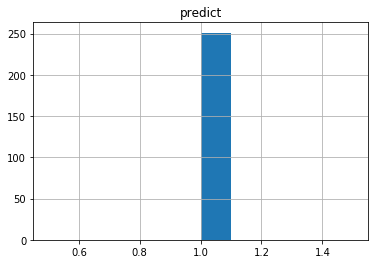

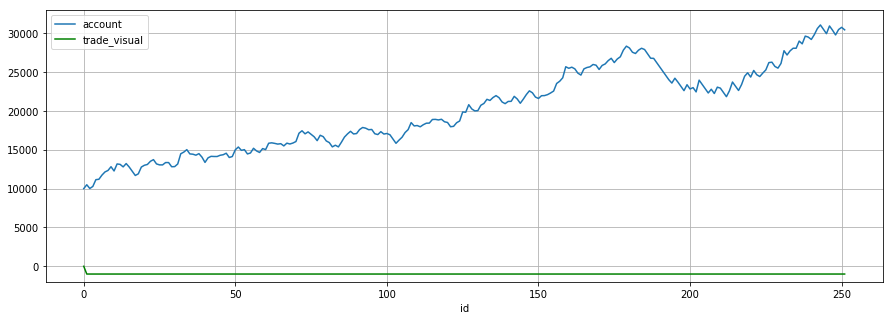

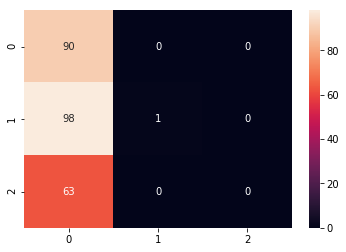

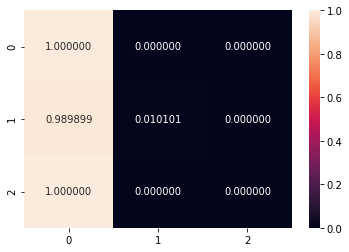

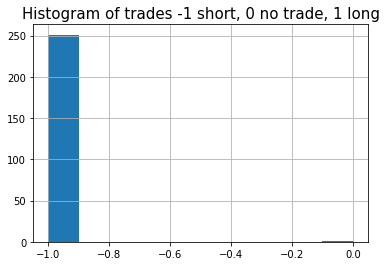

In [283]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.map(lambda x: -1 if x == 1 else 0).values
a.hist()

coffee_account = get_account(b, coffee_gains.loc[coffee_gains.index > validate_date], coffee_label_validate, stop_loss_long=800, stop_loss_short=800)

In [284]:
# mean reversal
# Compute the z-scores for each day using the historical data up to that day
def mean_reversal_account(df, df_gains, trade_days=1):
    account = 10000
    direction = gold['mean_direction'].values[0]
    dct = {}
    dct['account'] = [account]
    trade = 0
    for d, v in zip(df['mean_direction'].values, gold_gains.values):
        if d >= 0 and direction <= 0:
            account -= v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        elif d <= 0 and direction >= 0:
            direction = d
            account += v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        dct['account'].append(account)
        if account <= 0:
            break
    return pd.DataFrame.from_dict(dct)

def mean_calculation(df, big_range, small_range):
    big_mean = 'mean_' + str(big_range)
    small_mean = 'mean_' + str(small_range)
    df[big_mean] = df.rolling(str(big_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df[small_mean] = df.rolling(str(small_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df['mean_direction'] =  df[small_mean] - df[big_mean]
    return df

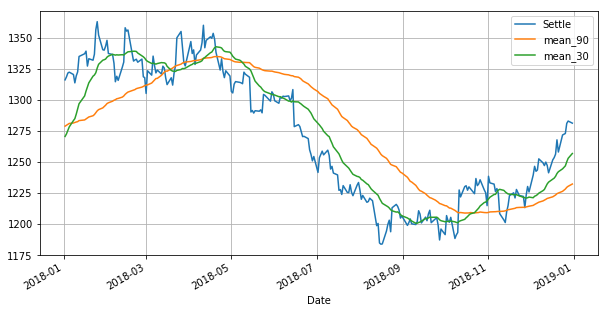

In [285]:
gold = mean_calculation(gold, 90, 30)
gold[['Settle', 'mean_90', 'mean_30']].loc[gold.index > validate_date].plot(figsize=(10,5), grid=True)

In [286]:
nasdaq_amount = 10000/nasdaq.loc[(nasdaq.index >= '2018-01-02') & (nasdaq.index < '2018-01-03')].Settle.values[0]

nasdaq = nasdaq.loc[(nasdaq.index <= '2018-12-30')]

In [287]:
nasdaq.loc[(nasdaq.index >= '2018-01-02') & (nasdaq.index < '2018-01-03')].Settle.values[0]

6514.75

In [288]:
nasdaq_amount

1.5349783184312522

In [295]:
gold_mean = mean_reversal_account(gold.loc[gold.index > validate_date], gold_gains.loc[gold_gains.index > validate_date], trade_days=5)
gold_mean['base'] = gold_mean.account.apply(lambda x: 10000)
gold_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
gold_mean['Nasdaq'] = gold_mean['Nasdaq']*nasdaq_amount

# gold_account_nn = get_performance(gold_clf_reg_nn
pd.concat([gold_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
           gold_account_nn.rename(columns={'account': 'Model Shorts'})[['Model Shorts']],
          ], 
          axis=1).plot(figsize=(10,5), grid=True)

KeyError: "['Model Shorts'] not in index"

In [290]:
gold_mean.head()

,account,base,Nasdaq
0,10000.0,10000,9894.853985
1,9667.5,10000,9837.292298
2,9667.5,10000,10000.000000
3,9667.5,10000,10107.064738
4,9667.5,10000,10136.229326


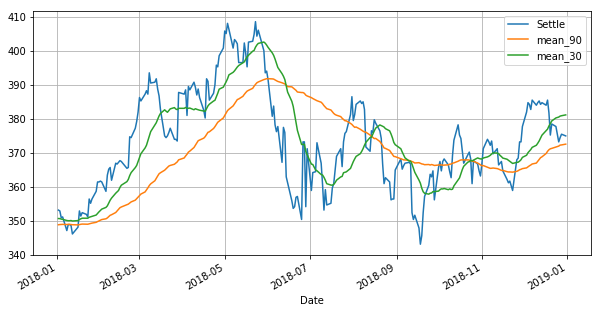

In [291]:
corn = mean_calculation(corn, 90, 30)
corn[['Settle', 'mean_90', 'mean_30']].loc[corn.index > validate_date].plot(figsize=(10,5), grid=True)

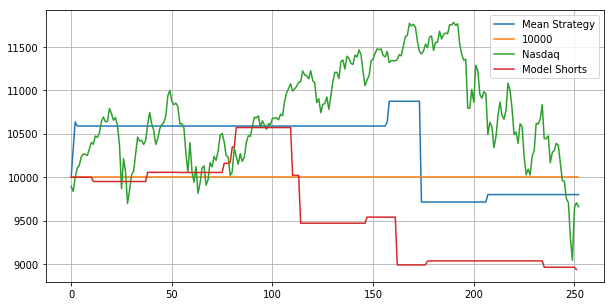

In [292]:
corn_mean = mean_reversal_account(corn.loc[corn.index > validate_date], corn_gains.loc[corn_gains.index > validate_date], trade_days=3)
corn_mean['base'] = corn_mean.account.apply(lambda x: 10000)
corn_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
corn_mean['Nasdaq'] = corn_mean['Nasdaq']*nasdaq_amount

pd.concat([corn_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
           corn_account.rename(columns={'account': 'Model Shorts'})[['Model Shorts']]], 
          axis=1).plot(figsize=(10,5), grid=True)

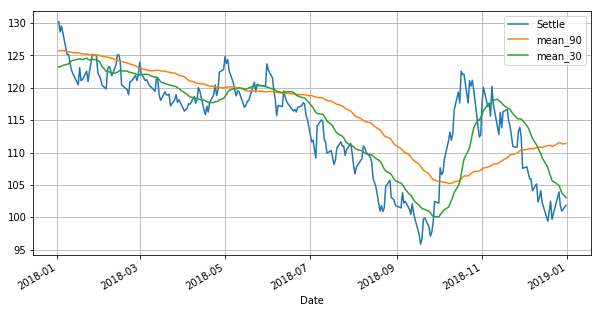

In [293]:
coffee = mean_calculation(coffee, 90, 30)
coffee[['Settle', 'mean_90', 'mean_30']].loc[coffee.index > validate_date].plot(figsize=(10,5), grid=True)

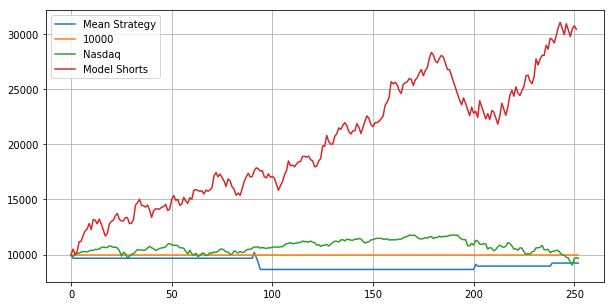

In [294]:
coffee_mean = mean_reversal_account(coffee.loc[coffee.index > validate_date], 
                                    coffee_gains.loc[coffee_gains.index > validate_date], 
                                    trade_days=5)
coffee_mean['base'] = coffee_mean.account.apply(lambda x: 10000)
coffee_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
coffee_mean['Nasdaq'] = coffee_mean['Nasdaq']*nasdaq_amount

pd.concat([coffee_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
           coffee_account.rename(columns={'account': 'Model Shorts'})[['Model Shorts']],
          ], 
          axis=1).plot(figsize=(10,5), grid=True)